In [1]:
import time
import os
import pickle
from pathlib import Path
import json
from typing import List, Optional
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import optuna
from optuna.visualization.matplotlib import (plot_param_importances, plot_contour, plot_optimization_history,
                                            plot_slice, plot_parallel_coordinate, plot_rank)
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

/Users/edwardyao/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 440

DIR = os.getcwd()
TRAIN_FEATURES_PATH = DIR + "/data" + "/train_features_X4juyT6.csv"
TRAIN_LABELS_PATH = DIR + "/data" + "/train_labels_JxtENGl.csv"
SVC_TUNING_DIR = DIR + "/tuning" + "/svm"

# encoded paths
#DBERTA_CME_PATH = DIR + "/data" + "/cme_deberta_enc.npy"
GTE_CME_PATH = DIR + "/data" + "/cme_gte_enc.npy"
GTE_LE_PATH = DIR + "/data" + "/le_gte_enc.npy"

In [3]:
train_features_df = pd.read_csv(TRAIN_FEATURES_PATH)
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

In [4]:
def save_study_charts(study: optuna.study,
                      study_name: str,
                      dir: str) -> None:

    # save charts of trials
    fig = plt.figure(figsize=(8,8))
    plot_optimization_history(study)
    plt.savefig(f"{dir}/{study_name}_opt_hist.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_parallel_coordinate(study)
    plt.savefig(f"{dir}/{study_name}_parallel_coord.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_param_importances(study)
    plt.savefig(f"{dir}/{study_name}_param_importances.png")

    plt.clf()
    fig = plt.figure(figsize=(12,12))
    plot_rank(study)
    plt.savefig(f"{dir}/{study_name}_rank.png")

    plt.clf()
    fig = plt.figure()
    plot_slice(study)
    plt.savefig(f"{dir}/{study_name}_slice.png")

In [5]:
def multi_f1_binary(preds: np.ndarray, actuals: np.ndarray) -> float:
    
    preds, actuals = preds.T, actuals.T # (tasks, samples)
    per_task_f1 = []
    for p, a in zip(preds, actuals):
        per_task_f1.append(f1_score(a, p, average="binary"))
    
    return np.sum(per_task_f1)

def multi_var_f1(binary_preds: np.ndarray, 
                 binary_actuals: np.ndarray,
                 weapon_preds: np.ndarray, 
                 weapon_actuals: np.ndarray,
                 location_preds: np.ndarray,
                 loaction_actuals: np.ndarray) -> float:
    
    num_tasks = binary_preds.shape[-1] + 2
    
    weapon_micro_f1 = f1_score(weapon_actuals, weapon_preds, average="micro")
    location_micro_f1 = f1_score(location_actuals, location_preds, average="micro")
    binary_f1 = multi_f1_binary(binary_preds, binary_actuals)
    
    return (weapon_micro_f1 + location_micro_f1 + binary_f1) / num_tasks

In [6]:
def split_data(text_df, 
               labels_df,
               test_perc=0.15, 
               val_perc=0.15, 
               test_seed=42, 
               val_seed=74) -> tuple[pd.DataFrame]:
    
    val_size = int(len(text_df) * val_perc)
    X_tr, X_te, y_tr, y_te = train_test_split(text_df, labels_df, test_size=test_perc, shuffle=True, 
                                             random_state=test_seed, stratify=labels_df)
    #val_perc = val_size // len(X_tr)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_size, shuffle=True,
                                               random_state=val_seed, stratify=y_tr)
    
    #y_tr_sub, y_val_sub, y_te_sub = y_tr[features], y_val[features], y_te[features]
    
    return X_tr, X_val, X_te, y_tr, y_val, y_te

#### Load GTE CME Encoding

In [4]:
gte_cme_features = np.load(GTE_CME_PATH)

# add uid to encoded array as df
# gte_cme_features_df = pd.DataFrame(gte_cme_features)
# gte_cme_features_df["uid"] = train_labels_df["uid"].values

#### Load GTE LE Encoding

In [7]:
# gte_le_features = np.load(GTE_LE_PATH)

# # add uid to encoded array as df
# gte_le_features_df = pd.DataFrame(gte_le_features)
# gte_le_features_df["uid"] = train_labels_df["uid"].values

In [5]:
def sample_svm_params(trial: optuna.trial) -> dict:
    
    C_reg = trial.suggest_float("C", 1.0, 10.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
    
    return {"C": C_reg, "kernel": kernel}

In [6]:
# def TreeObjective(trial: optuna.trial,
#                   seed: int,
#                   X_train: np.ndarray,
#                   X_val: np.ndarray,
#                   y_train: np.ndarray,
#                   y_val: np.ndarray,
#                   algo) -> float:
    
    
#     params = sample_svm_params(trial)
#     model = algo(**params, seed=seed).fit(X_train, y_train)
    
#     preds = model.predict(X_val)[:, None]
    
#     return multi_f1_binary(preds=preds, actuals=y_val) / y_train.shape[-1]

def TreeObjective(trial: optuna.trial,
                  seed: int,
                  X_train: np.ndarray,
                  X_val: np.ndarray,
                  y_train: np.ndarray,
                  y_val: np.ndarray,
                  algo) -> float:
    
    
    params = sample_svm_params(trial)
    model = algo(**params, random_state=seed).fit(X_train, y_train)

    preds = model.predict(X_val)
    
    return f1_score(y_val, preds)

def MicroTreeObjective(trial: optuna.trial,
                  seed: int,
                  X_train: np.ndarray,
                  X_val: np.ndarray,
                  y_train: np.ndarray,
                  y_val: np.ndarray,
                  algo) -> float:
    
    params = sample_svm_params(trial)
    model = algo(**params, random_state=seed).fit(X_train, y_train)
    preds = model.predict(X_val)
    
    return f1_score(y_val, preds, average='micro')

# Tuning All Using 5-Fold CV w/ CME Features

In [7]:
cme_scaler = StandardScaler()
gte_cme_feats_scaled = cme_scaler.fit_transform(gte_cme_features)

In [8]:
# get feature names
categories = list(train_labels_df.columns.values)[1:] # good

f1_per_cat = {}

for cat in categories:
    
    fold_f1_scores = []
    
    feat_names = [cat]
    y = train_labels_df[feat_names].values[:,0] # good
    if len(np.unique(y)) > 2:
        y -= 1
    #gte_cme_features
    skf = StratifiedKFold(n_splits=5, random_state=386, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(gte_cme_feats_scaled, y)):
        
        study_name = f"svm_study_gte_cme_{i}thfoldcv_{cat}"
        storage_name = optuna.storages.JournalStorage(
            optuna.storages.journal.JournalFileBackend(f"./optuna_journal_storage_svm_gte_cme_{i}thfoldcv_{cat}.log")
            )
        
        X_train, y_train = gte_cme_feats_scaled[train_index, :], y[train_index]
        X_test, y_test = gte_cme_feats_scaled[test_index, :], y[test_index]
        
        clf = SVC
        
        # check for a saved sampler
        try:
            sampler = pickle.load(open(f"{SVC_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
        except (OSError, IOError) as e:
            sampler = TPESampler(seed=SEED)

        pruner = MedianPruner()
        
        # create study and optimize
        study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

        if len(np.unique(y)) == 2: # looks good
            study.optimize(lambda trial: TreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=200, timeout=3000)
        else:
            study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=200, timeout=3000)
        
        trial = study.best_trial
        fold_f1_scores.append(trial.value)
        
    f1_per_cat[cat] = fold_f1_scores
        

[I 2024-10-15 19:25:43,802] Using an existing study with name 'svm_study_gte_cme_0thfoldcv_DepressedMood' instead of creating a new one.
[I 2024-10-15 19:26:48,837] Trial 7 finished with value: 0.44692737430167595 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 1 with value: 0.4594594594594595.
[I 2024-10-15 19:30:11,604] Trial 8 finished with value: 0.4584837545126354 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 1 with value: 0.4594594594594595.
[I 2024-10-15 19:30:16,729] Trial 9 finished with value: 0.3368421052631579 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 1 with value: 0.4594594594594595.
[I 2024-10-15 19:36:52,725] Trial 10 finished with value: 0.4563279857397504 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 1 with value: 0.4594594594594595.
[I 2024-10-15 19:36:57,948] Trial 11 finished with value: 0.4029126213592233 and parameters: {'C': 5.927665509726741, '

[I 2024-10-15 20:03:54,127] Trial 51 finished with value: 0.47863247863247865 and parameters: {'C': 4.755502014046527, 'kernel': 'rbf'}. Best is trial 47 with value: 0.47863247863247865.
[I 2024-10-15 20:03:59,377] Trial 52 finished with value: 0.4753747323340471 and parameters: {'C': 4.601804477263891, 'kernel': 'rbf'}. Best is trial 47 with value: 0.47863247863247865.
[I 2024-10-15 20:04:04,684] Trial 53 finished with value: 0.4625267665952891 and parameters: {'C': 6.443337360440047, 'kernel': 'rbf'}. Best is trial 47 with value: 0.47863247863247865.
[I 2024-10-15 20:04:10,437] Trial 54 finished with value: 0.47863247863247865 and parameters: {'C': 4.729417552939295, 'kernel': 'rbf'}. Best is trial 47 with value: 0.47863247863247865.
[I 2024-10-15 20:04:15,571] Trial 55 finished with value: 0.47186147186147187 and parameters: {'C': 4.060074476963744, 'kernel': 'rbf'}. Best is trial 47 with value: 0.47863247863247865.
[I 2024-10-15 20:04:20,659] Trial 56 finished with value: 0.4786324

[I 2024-10-15 20:30:46,378] Trial 11 finished with value: 0.46476190476190476 and parameters: {'C': 1.0906212330286236, 'kernel': 'linear'}. Best is trial 9 with value: 0.4667931688804554.
[I 2024-10-15 20:31:39,673] Trial 12 finished with value: 0.4580152671755725 and parameters: {'C': 1.5877459166761332, 'kernel': 'linear'}. Best is trial 9 with value: 0.4667931688804554.
[I 2024-10-15 20:32:14,779] Trial 13 finished with value: 0.4588910133843212 and parameters: {'C': 1.0215894220348583, 'kernel': 'linear'}. Best is trial 9 with value: 0.4667931688804554.
[I 2024-10-15 20:33:13,085] Trial 14 finished with value: 0.45977011494252873 and parameters: {'C': 1.7486764557469041, 'kernel': 'linear'}. Best is trial 9 with value: 0.4667931688804554.
[I 2024-10-15 20:33:57,189] Trial 15 finished with value: 0.46476190476190476 and parameters: {'C': 1.3067758965778447, 'kernel': 'linear'}. Best is trial 9 with value: 0.4667931688804554.
[I 2024-10-15 20:35:13,939] Trial 16 finished with value:

[I 2024-10-15 21:23:47,747] Trial 15 finished with value: 0.4585152838427948 and parameters: {'C': 3.1026759508555695, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4585152838427948.
[I 2024-10-15 21:23:52,996] Trial 16 finished with value: 0.46120689655172414 and parameters: {'C': 3.5106802021892967, 'kernel': 'rbf'}. Best is trial 16 with value: 0.46120689655172414.
[I 2024-10-15 21:23:58,082] Trial 17 finished with value: 0.45493562231759654 and parameters: {'C': 3.818120474648068, 'kernel': 'rbf'}. Best is trial 16 with value: 0.46120689655172414.
[I 2024-10-15 21:24:03,311] Trial 18 finished with value: 0.46320346320346323 and parameters: {'C': 3.381601692584941, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:24:08,693] Trial 19 finished with value: 0.46153846153846156 and parameters: {'C': 9.084585412126241, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:24:13,892] Trial 20 finished with value: 0.46153

[I 2024-10-15 21:42:53,278] Trial 60 finished with value: 0.45951859956236324 and parameters: {'C': 2.874141986471923, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:42:58,261] Trial 61 finished with value: 0.445859872611465 and parameters: {'C': 4.177699377990274, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:43:03,299] Trial 62 finished with value: 0.462882096069869 and parameters: {'C': 3.2653370562197725, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:43:08,878] Trial 63 finished with value: 0.462882096069869 and parameters: {'C': 3.2989118728281834, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:43:15,031] Trial 64 finished with value: 0.462882096069869 and parameters: {'C': 3.255887549735214, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:43:21,443] Trial 65 finished with value: 0.45356371490

[I 2024-10-15 21:50:22,074] Trial 104 finished with value: 0.4539614561027837 and parameters: {'C': 3.8622820847939408, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:50:26,946] Trial 105 finished with value: 0.46187363834422657 and parameters: {'C': 3.304880785849899, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:50:31,882] Trial 106 finished with value: 0.4588744588744589 and parameters: {'C': 3.5510143328625317, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:52:38,886] Trial 107 finished with value: 0.42412451361867703 and parameters: {'C': 2.942341927476657, 'kernel': 'linear'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:52:45,109] Trial 108 finished with value: 0.45089285714285715 and parameters: {'C': 2.53411956408846, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:52:52,123] Trial 109 finished with value:

[I 2024-10-15 21:58:23,208] Trial 148 finished with value: 0.4608695652173913 and parameters: {'C': 3.326458950929073, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 21:58:29,348] Trial 149 finished with value: 0.45951859956236324 and parameters: {'C': 3.0872292410174285, 'kernel': 'rbf'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 22:01:24,724] Trial 150 finished with value: 0.42003853564547206 and parameters: {'C': 3.825600384912676, 'kernel': 'linear'}. Best is trial 18 with value: 0.46320346320346323.
[I 2024-10-15 22:01:24,732] A new study created in Journal with name: svm_study_gte_cme_3thfoldcv_DepressedMood
[I 2024-10-15 22:02:10,725] Trial 0 finished with value: 0.43410852713178294 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.43410852713178294.
[I 2024-10-15 22:04:32,498] Trial 1 finished with value: 0.444022770398482 and parameters: {'C': 4.131878079505722, 'kernel': 'linear

[I 2024-10-15 22:25:07,363] Trial 41 finished with value: 0.4652173913043478 and parameters: {'C': 8.960370890254527, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:25:10,578] Trial 42 finished with value: 0.45217391304347826 and parameters: {'C': 7.49792482663565, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:25:13,840] Trial 43 finished with value: 0.4652173913043478 and parameters: {'C': 9.03563227147077, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:25:17,006] Trial 44 finished with value: 0.46187363834422657 and parameters: {'C': 8.759153710604743, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:25:19,881] Trial 45 finished with value: 0.40930232558139534 and parameters: {'C': 5.939117686513037, 'kernel': 'poly'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:25:22,873] Trial 46 finished with value: 0.4275534441805

[I 2024-10-15 22:39:08,391] Trial 86 finished with value: 0.45217391304347826 and parameters: {'C': 7.552421655493078, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:39:11,699] Trial 87 finished with value: 0.46187363834422657 and parameters: {'C': 9.567841300280957, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:39:14,851] Trial 88 finished with value: 0.4027777777777778 and parameters: {'C': 8.158564294626572, 'kernel': 'poly'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:39:18,134] Trial 89 finished with value: 0.46187363834422657 and parameters: {'C': 8.647174116796878, 'kernel': 'rbf'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:44:56,109] Trial 90 finished with value: 0.44274809160305345 and parameters: {'C': 6.75043598359427, 'kernel': 'linear'}. Best is trial 32 with value: 0.4652173913043478.
[I 2024-10-15 22:45:01,299] Trial 91 finished with value: 0.46521739

[I 2024-10-15 23:09:09,197] Trial 20 finished with value: 0.5063291139240507 and parameters: {'C': 6.684379422204461, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5206073752711496.
[I 2024-10-15 23:09:14,506] Trial 21 finished with value: 0.5204301075268817 and parameters: {'C': 4.246042109329964, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5206073752711496.
[I 2024-10-15 23:09:19,660] Trial 22 finished with value: 0.5204301075268817 and parameters: {'C': 4.066607595021455, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5206073752711496.
[I 2024-10-15 23:09:24,922] Trial 23 finished with value: 0.5185185185185185 and parameters: {'C': 3.52539043946715, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5206073752711496.
[I 2024-10-15 23:09:30,302] Trial 24 finished with value: 0.5170940170940171 and parameters: {'C': 4.682072248977661, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5206073752711496.
[I 2024-10-15 23:09:35,473] Trial 25 finished with value: 0.5094736842105263

[I 2024-10-15 23:38:45,665] Trial 65 finished with value: 0.5096359743040685 and parameters: {'C': 5.069235198722489, 'kernel': 'rbf'}. Best is trial 27 with value: 0.5226781857451404.
[I 2024-10-15 23:38:50,980] Trial 66 finished with value: 0.521551724137931 and parameters: {'C': 3.946503006952876, 'kernel': 'rbf'}. Best is trial 27 with value: 0.5226781857451404.
[I 2024-10-15 23:38:56,220] Trial 67 finished with value: 0.5095541401273885 and parameters: {'C': 5.577961732912479, 'kernel': 'rbf'}. Best is trial 27 with value: 0.5226781857451404.
[I 2024-10-15 23:39:01,548] Trial 68 finished with value: 0.5204301075268817 and parameters: {'C': 4.100757140519885, 'kernel': 'rbf'}. Best is trial 27 with value: 0.5226781857451404.
[I 2024-10-15 23:39:06,929] Trial 69 finished with value: 0.521551724137931 and parameters: {'C': 3.9411636582116425, 'kernel': 'rbf'}. Best is trial 27 with value: 0.5226781857451404.
[I 2024-10-15 23:39:12,091] Trial 70 finished with value: 0.5161290322580645

[I 2024-10-15 23:49:10,386] Trial 16 finished with value: 0.5921787709497207 and parameters: {'C': 2.6318794051775316, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:49:14,691] Trial 17 finished with value: 0.5888888888888889 and parameters: {'C': 2.705830097615168, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:49:19,014] Trial 18 finished with value: 0.580110497237569 and parameters: {'C': 3.7677169364510683, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:49:23,180] Trial 19 finished with value: 0.5955056179775281 and parameters: {'C': 2.362967188651851, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:49:27,880] Trial 20 finished with value: 0.5831062670299727 and parameters: {'C': 9.979707435450774, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:49:32,046] Trial 21 finished with value: 0.5955056179775281 an

[I 2024-10-15 23:54:37,590] Trial 61 finished with value: 0.5994397759103641 and parameters: {'C': 2.4713936195859327, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:54:41,830] Trial 62 finished with value: 0.5994397759103641 and parameters: {'C': 2.4950937953978785, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:54:45,989] Trial 63 finished with value: 0.5994397759103641 and parameters: {'C': 2.465072160658993, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:54:50,498] Trial 64 finished with value: 0.5738161559888579 and parameters: {'C': 3.4057084113357488, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:54:54,611] Trial 65 finished with value: 0.5895316804407713 and parameters: {'C': 2.7980373611217098, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:54:58,999] Trial 66 finished with value: 0.5777777777777777

[I 2024-10-15 23:58:44,809] Trial 106 finished with value: 0.5955056179775281 and parameters: {'C': 2.367261673186685, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:58:49,553] Trial 107 finished with value: 0.5885558583106267 and parameters: {'C': 6.5973914840374235, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:58:53,950] Trial 108 finished with value: 0.5259938837920489 and parameters: {'C': 2.2537189479058655, 'kernel': 'poly'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:59:18,812] Trial 109 finished with value: 0.48758465011286684 and parameters: {'C': 1.8789269805396043, 'kernel': 'linear'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:59:23,139] Trial 110 finished with value: 0.5777777777777777 and parameters: {'C': 3.0661106938851326, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-15 23:59:27,067] Trial 111 finished with value: 0.59943

[I 2024-10-16 00:03:01,404] Trial 151 finished with value: 0.5994397759103641 and parameters: {'C': 2.462654180805414, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:03:05,496] Trial 152 finished with value: 0.5915492957746479 and parameters: {'C': 2.3105775154169135, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:03:09,538] Trial 153 finished with value: 0.5921787709497207 and parameters: {'C': 2.594422898873137, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:03:13,666] Trial 154 finished with value: 0.5994397759103641 and parameters: {'C': 2.4211057010765087, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:03:17,996] Trial 155 finished with value: 0.5895316804407713 and parameters: {'C': 2.8455102183501046, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:03:22,035] Trial 156 finished with value: 0.58757062146

[I 2024-10-16 00:06:57,787] Trial 196 finished with value: 0.5895316804407713 and parameters: {'C': 2.8343173150641796, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:07:01,876] Trial 197 finished with value: 0.5915492957746479 and parameters: {'C': 2.30150429244349, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:07:06,000] Trial 198 finished with value: 0.5994397759103641 and parameters: {'C': 2.4169386299074147, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:07:09,966] Trial 199 finished with value: 0.5955056179775281 and parameters: {'C': 2.5672101103198646, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5994397759103641.
[I 2024-10-16 00:07:09,974] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_MentalIllnessTreatmentCurrnt
[I 2024-10-16 00:07:31,995] Trial 0 finished with value: 0.5466970387243736 and parameters: {'C': 1.485452044038716, 'kernel': 'lin

[I 2024-10-16 00:15:04,602] Trial 40 finished with value: 0.5587583148558758 and parameters: {'C': 2.2018377359228327, 'kernel': 'linear'}. Best is trial 28 with value: 0.6324786324786325.
[I 2024-10-16 00:15:08,606] Trial 41 finished with value: 0.625 and parameters: {'C': 2.3361773148528076, 'kernel': 'rbf'}. Best is trial 28 with value: 0.6324786324786325.
[I 2024-10-16 00:15:13,101] Trial 42 finished with value: 0.6145552560646901 and parameters: {'C': 3.8262363935282386, 'kernel': 'rbf'}. Best is trial 28 with value: 0.6324786324786325.
[I 2024-10-16 00:15:17,461] Trial 43 finished with value: 0.6312849162011173 and parameters: {'C': 3.0701281327361274, 'kernel': 'rbf'}. Best is trial 28 with value: 0.6324786324786325.
[I 2024-10-16 00:15:21,628] Trial 44 finished with value: 0.6309859154929578 and parameters: {'C': 2.648458110217259, 'kernel': 'rbf'}. Best is trial 28 with value: 0.6324786324786325.
[I 2024-10-16 00:15:26,088] Trial 45 finished with value: 0.565597667638484 and p

[I 2024-10-16 00:19:40,983] Trial 85 finished with value: 0.6225895316804407 and parameters: {'C': 3.3936980087917785, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:19:45,291] Trial 86 finished with value: 0.6295264623955432 and parameters: {'C': 2.9085954921162402, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:19:49,520] Trial 87 finished with value: 0.6348314606741573 and parameters: {'C': 2.6100841534465578, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:19:53,718] Trial 88 finished with value: 0.6309859154929578 and parameters: {'C': 2.5921037810534564, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:19:58,165] Trial 89 finished with value: 0.5588235294117647 and parameters: {'C': 3.942691825239364, 'kernel': 'poly'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:20:02,340] Trial 90 finished with value: 0.625 and pa

[I 2024-10-16 00:24:18,899] Trial 130 finished with value: 0.6333333333333333 and parameters: {'C': 2.926463230431036, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:24:23,231] Trial 131 finished with value: 0.6333333333333333 and parameters: {'C': 2.9282881932983473, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:24:27,708] Trial 132 finished with value: 0.6212534059945504 and parameters: {'C': 3.575433191844356, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:24:32,027] Trial 133 finished with value: 0.6312849162011173 and parameters: {'C': 3.103773883163461, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:24:36,259] Trial 134 finished with value: 0.6309859154929578 and parameters: {'C': 2.665890466820511, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:24:40,578] Trial 135 finished with value: 0.62952646

[I 2024-10-16 00:28:30,761] Trial 174 finished with value: 0.6312849162011173 and parameters: {'C': 3.157284912404713, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:28:34,947] Trial 175 finished with value: 0.6309859154929578 and parameters: {'C': 2.623470753728149, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:28:39,418] Trial 176 finished with value: 0.6246575342465753 and parameters: {'C': 3.4700754584492013, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:28:43,698] Trial 177 finished with value: 0.6312849162011173 and parameters: {'C': 2.840529827670352, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:28:48,048] Trial 178 finished with value: 0.631578947368421 and parameters: {'C': 3.247166910169415, 'kernel': 'rbf'}. Best is trial 79 with value: 0.6350974930362117.
[I 2024-10-16 00:28:52,292] Trial 179 finished with value: 0.633053221

[I 2024-10-16 00:34:21,960] Trial 18 finished with value: 0.5802469135802469 and parameters: {'C': 1.058888864859459, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6024096385542169.
[I 2024-10-16 00:34:25,330] Trial 19 finished with value: 0.5981873111782477 and parameters: {'C': 1.4738376444416348, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6024096385542169.
[I 2024-10-16 00:34:29,525] Trial 20 finished with value: 0.5971830985915493 and parameters: {'C': 2.5369654954964034, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6024096385542169.
[I 2024-10-16 00:34:33,041] Trial 21 finished with value: 0.5988372093023255 and parameters: {'C': 2.0392341010827617, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6024096385542169.
[I 2024-10-16 00:34:36,393] Trial 22 finished with value: 0.6011904761904762 and parameters: {'C': 1.665617238775054, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6024096385542169.
[I 2024-10-16 00:34:39,773] Trial 23 finished with value: 0.602409638554

[I 2024-10-16 00:39:32,911] Trial 63 finished with value: 0.5957446808510638 and parameters: {'C': 1.4092056898870795, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:39:36,418] Trial 64 finished with value: 0.5982404692082112 and parameters: {'C': 1.9340180302210452, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:39:39,702] Trial 65 finished with value: 0.5846153846153846 and parameters: {'C': 1.1352526853559801, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:39:42,993] Trial 66 finished with value: 0.588957055214724 and parameters: {'C': 1.2839858449880759, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:39:46,386] Trial 67 finished with value: 0.6047904191616766 and parameters: {'C': 1.5786547048282205, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:39:49,812] Trial 68 finished with value: 0.60355029585

[I 2024-10-16 00:42:44,433] Trial 108 finished with value: 0.4721311475409836 and parameters: {'C': 1.3167721444124805, 'kernel': 'poly'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:42:47,919] Trial 109 finished with value: 0.6017699115044248 and parameters: {'C': 1.763443493841562, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:42:52,248] Trial 110 finished with value: 0.585635359116022 and parameters: {'C': 3.8324919798825814, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:42:55,681] Trial 111 finished with value: 0.6029850746268657 and parameters: {'C': 1.6052556158126525, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:42:59,054] Trial 112 finished with value: 0.6024096385542169 and parameters: {'C': 1.5066858871156057, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:43:02,504] Trial 113 finished with value: 0.60355

[I 2024-10-16 00:45:53,325] Trial 152 finished with value: 0.5981873111782477 and parameters: {'C': 1.4884520252900966, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:45:56,798] Trial 153 finished with value: 0.5964912280701754 and parameters: {'C': 1.7998499216586925, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:46:00,121] Trial 154 finished with value: 0.5932721712538226 and parameters: {'C': 1.3456493624943848, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:46:03,497] Trial 155 finished with value: 0.6047904191616766 and parameters: {'C': 1.566694135698468, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:46:06,518] Trial 156 finished with value: 0.5981873111782477 and parameters: {'C': 1.4679120521280804, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:46:09,934] Trial 157 finished with value: 0.60298

[I 2024-10-16 00:48:38,339] Trial 196 finished with value: 0.5 and parameters: {'C': 1.520996498440629, 'kernel': 'poly'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:48:41,762] Trial 197 finished with value: 0.5981873111782477 and parameters: {'C': 1.464902893938621, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:48:45,004] Trial 198 finished with value: 0.6017699115044248 and parameters: {'C': 1.6888888964564333, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:48:48,357] Trial 199 finished with value: 0.5932721712538226 and parameters: {'C': 1.3901262724178394, 'kernel': 'rbf'}. Best is trial 42 with value: 0.6066066066066066.
[I 2024-10-16 00:48:48,365] A new study created in Journal with name: svm_study_gte_cme_3thfoldcv_MentalIllnessTreatmentCurrnt
[I 2024-10-16 00:49:10,557] Trial 0 finished with value: 0.5188679245283019 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Bes

[I 2024-10-16 00:55:26,020] Trial 40 finished with value: 0.5023474178403756 and parameters: {'C': 2.7368301563045643, 'kernel': 'linear'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:55:29,294] Trial 41 finished with value: 0.5680473372781065 and parameters: {'C': 1.5988331154136537, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:55:32,478] Trial 42 finished with value: 0.5621301775147929 and parameters: {'C': 1.2457856807487582, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:55:35,870] Trial 43 finished with value: 0.5614035087719298 and parameters: {'C': 1.954411251344122, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:55:39,187] Trial 44 finished with value: 0.5680473372781065 and parameters: {'C': 1.6966906309853367, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:55:43,196] Trial 45 finished with value: 0.41811846

[I 2024-10-16 00:58:39,980] Trial 85 finished with value: 0.5680473372781065 and parameters: {'C': 1.6162328751398918, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:58:58,080] Trial 86 finished with value: 0.5233644859813084 and parameters: {'C': 1.198471853103665, 'kernel': 'linear'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:59:02,723] Trial 87 finished with value: 0.5604395604395604 and parameters: {'C': 6.872393807476649, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:59:05,936] Trial 88 finished with value: 0.5621301775147929 and parameters: {'C': 1.320669782350239, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:59:09,082] Trial 89 finished with value: 0.5647058823529412 and parameters: {'C': 1.8127472779166371, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 00:59:13,423] Trial 90 finished with value: 0.5454545454

[I 2024-10-16 01:02:06,834] Trial 129 finished with value: 0.5621301775147929 and parameters: {'C': 1.2780240642762064, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:02:10,040] Trial 130 finished with value: 0.5637982195845698 and parameters: {'C': 1.3583264563567057, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:02:13,309] Trial 131 finished with value: 0.5680473372781065 and parameters: {'C': 1.5164449597377836, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:02:16,543] Trial 132 finished with value: 0.5680473372781065 and parameters: {'C': 1.603140375988772, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:02:19,863] Trial 133 finished with value: 0.5680473372781065 and parameters: {'C': 1.6422953564281313, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:02:23,181] Trial 134 finished with value: 0.56804

[I 2024-10-16 01:06:11,240] Trial 173 finished with value: 0.5680473372781065 and parameters: {'C': 1.620168127962236, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:06:14,294] Trial 174 finished with value: 0.5621301775147929 and parameters: {'C': 1.3053076717264689, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:06:17,636] Trial 175 finished with value: 0.5663716814159292 and parameters: {'C': 1.72193536231187, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:06:20,650] Trial 176 finished with value: 0.5680473372781065 and parameters: {'C': 1.5069164863834783, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:06:23,884] Trial 177 finished with value: 0.5680473372781065 and parameters: {'C': 1.425103776760118, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5680473372781065.
[I 2024-10-16 01:06:27,184] Trial 178 finished with value: 0.56804733

[I 2024-10-16 01:11:46,992] Trial 17 finished with value: 0.5625 and parameters: {'C': 3.8712186377446027, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5714285714285714.
[I 2024-10-16 01:11:51,170] Trial 18 finished with value: 0.5673352435530086 and parameters: {'C': 2.4461405128663034, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5714285714285714.
[I 2024-10-16 01:11:55,456] Trial 19 finished with value: 0.5681818181818182 and parameters: {'C': 4.148908970730744, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5714285714285714.
[I 2024-10-16 01:12:00,012] Trial 20 finished with value: 0.5658263305322129 and parameters: {'C': 9.979707435450774, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5714285714285714.
[I 2024-10-16 01:12:04,517] Trial 21 finished with value: 0.5625 and parameters: {'C': 3.8359640869703, 'kernel': 'rbf'}. Best is trial 16 with value: 0.5714285714285714.
[I 2024-10-16 01:12:08,683] Trial 22 finished with value: 0.5632183908045977 and parameters: {'C': 

[I 2024-10-16 01:19:42,734] Trial 62 finished with value: 0.5730659025787965 and parameters: {'C': 2.319182540428234, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:19:46,918] Trial 63 finished with value: 0.5714285714285714 and parameters: {'C': 2.385129285946732, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:19:50,355] Trial 64 finished with value: 0.5476190476190477 and parameters: {'C': 1.8003548854367841, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:19:53,739] Trial 65 finished with value: 0.5421686746987951 and parameters: {'C': 1.5796245987673105, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:19:57,684] Trial 66 finished with value: 0.5632183908045977 and parameters: {'C': 2.4942566893033256, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:20:01,173] Trial 67 finished with value: 0.554572271386

[I 2024-10-16 01:23:36,565] Trial 107 finished with value: 0.5632183908045977 and parameters: {'C': 2.520701871722253, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:23:40,809] Trial 108 finished with value: 0.5584045584045584 and parameters: {'C': 3.1316899155841473, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:23:44,905] Trial 109 finished with value: 0.5706051873198847 and parameters: {'C': 2.3009033323022074, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:23:49,418] Trial 110 finished with value: 0.4984423676012461 and parameters: {'C': 2.1923671619299996, 'kernel': 'poly'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:23:53,624] Trial 111 finished with value: 0.5730659025787965 and parameters: {'C': 2.3506232576678134, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:23:57,496] Trial 112 finished with value: 0.5730

[I 2024-10-16 01:27:26,488] Trial 152 finished with value: 0.5730659025787965 and parameters: {'C': 2.351169814246793, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:27:30,658] Trial 153 finished with value: 0.5673352435530086 and parameters: {'C': 2.4441371632304394, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:27:34,734] Trial 154 finished with value: 0.5706051873198847 and parameters: {'C': 2.2224154220576957, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:27:38,998] Trial 155 finished with value: 0.5616045845272206 and parameters: {'C': 2.6250651183138975, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:27:42,185] Trial 156 finished with value: 0.565597667638484 and parameters: {'C': 2.054516985662884, 'kernel': 'rbf'}. Best is trial 56 with value: 0.5730659025787965.
[I 2024-10-16 01:27:46,302] Trial 157 finished with value: 0.5730659

[I 2024-10-16 01:32:21,028] Trial 197 finished with value: 0.5616045845272206 and parameters: {'C': 2.647926049102131, 'kernel': 'rbf'}. Best is trial 161 with value: 0.5747126436781609.
[I 2024-10-16 01:32:25,129] Trial 198 finished with value: 0.5706051873198847 and parameters: {'C': 2.28430122689481, 'kernel': 'rbf'}. Best is trial 161 with value: 0.5747126436781609.
[I 2024-10-16 01:32:53,513] Trial 199 finished with value: 0.4766355140186916 and parameters: {'C': 2.524147972364407, 'kernel': 'linear'}. Best is trial 161 with value: 0.5747126436781609.
[I 2024-10-16 01:32:53,524] A new study created in Journal with name: svm_study_gte_cme_0thfoldcv_HistoryMentalIllnessTreatmnt
[I 2024-10-16 01:33:29,074] Trial 0 finished with value: 0.6754098360655738 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.6754098360655738.
[I 2024-10-16 01:35:03,208] Trial 1 finished with value: 0.6601307189542484 and parameters: {'C': 4.131878079505722, 'kernel

[I 2024-10-16 01:43:00,668] Trial 41 finished with value: 0.7312614259597806 and parameters: {'C': 1.1635286911830731, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:43:05,126] Trial 42 finished with value: 0.7344028520499108 and parameters: {'C': 2.1270563877048336, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:43:10,141] Trial 43 finished with value: 0.7065026362038664 and parameters: {'C': 7.536820036117721, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:43:13,996] Trial 44 finished with value: 0.7381818181818182 and parameters: {'C': 1.4185275389654326, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:43:18,812] Trial 45 finished with value: 0.6578449905482041 and parameters: {'C': 1.855152123732003, 'kernel': 'poly'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:43:22,716] Trial 46 finished with value: 0.73818181818

[I 2024-10-16 01:55:26,238] Trial 86 finished with value: 0.7335766423357665 and parameters: {'C': 1.2109750494922302, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 01:55:31,367] Trial 87 finished with value: 0.6833631484794276 and parameters: {'C': 6.872393807476649, 'kernel': 'poly'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 02:15:58,181] Trial 88 finished with value: 0.7381818181818182 and parameters: {'C': 1.4735761778459562, 'kernel': 'rbf'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 03:08:11,838] Trial 89 finished with value: 0.6710097719869706 and parameters: {'C': 1.5980242082775526, 'kernel': 'linear'}. Best is trial 18 with value: 0.7381818181818182.
[I 2024-10-16 03:08:11,847] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_HistoryMentalIllnessTreatmnt
[I 2024-10-16 04:22:19,797] Trial 0 finished with value: 0.5916398713826366 and parameters: {'C': 1.485452044038716, 'kernel':

[I 2024-10-16 06:52:06,131] Trial 36 finished with value: 0.6410256410256411 and parameters: {'C': 4.052730513378223, 'kernel': 'poly'}. Best is trial 16 with value: 0.6892857142857143.
[I 2024-10-16 06:52:10,829] Trial 37 finished with value: 0.6845878136200717 and parameters: {'C': 2.614804641788275, 'kernel': 'rbf'}. Best is trial 16 with value: 0.6892857142857143.
[I 2024-10-16 06:52:15,662] Trial 38 finished with value: 0.6273764258555133 and parameters: {'C': 2.2049181410885668, 'kernel': 'poly'}. Best is trial 16 with value: 0.6892857142857143.
[I 2024-10-16 06:52:20,818] Trial 39 finished with value: 0.6820603907637656 and parameters: {'C': 6.083504205737918, 'kernel': 'rbf'}. Best is trial 16 with value: 0.6892857142857143.
[I 2024-10-16 06:53:29,745] Trial 40 finished with value: 0.5878489326765188 and parameters: {'C': 4.852168375238503, 'kernel': 'linear'}. Best is trial 16 with value: 0.6892857142857143.
[I 2024-10-16 06:53:32,506] Trial 41 finished with value: 0.689285714

[I 2024-10-16 06:56:06,088] Trial 81 finished with value: 0.6931407942238267 and parameters: {'C': 2.3682111679769604, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:56:08,779] Trial 82 finished with value: 0.6810035842293907 and parameters: {'C': 3.0461794078218336, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:56:11,302] Trial 83 finished with value: 0.6847826086956522 and parameters: {'C': 2.092527280966226, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:56:13,894] Trial 84 finished with value: 0.6931407942238267 and parameters: {'C': 2.3546352663677843, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:56:16,476] Trial 85 finished with value: 0.6918918918918919 and parameters: {'C': 2.3863864327901383, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:56:19,080] Trial 86 finished with value: 0.68222621184

[I 2024-10-16 06:59:06,237] Trial 125 finished with value: 0.6895306859205776 and parameters: {'C': 2.223204414746559, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:59:08,868] Trial 126 finished with value: 0.6881720430107527 and parameters: {'C': 2.4559106354773816, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:59:11,493] Trial 127 finished with value: 0.6931407942238267 and parameters: {'C': 2.332286939152419, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:59:14,196] Trial 128 finished with value: 0.6810035842293907 and parameters: {'C': 2.7792345566205223, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:59:16,447] Trial 129 finished with value: 0.6860254083484574 and parameters: {'C': 1.7803881921814813, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 06:59:19,089] Trial 130 finished with value: 0.684587

[I 2024-10-16 07:03:37,318] Trial 169 finished with value: 0.6871609403254972 and parameters: {'C': 2.130383615321679, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 07:03:40,169] Trial 170 finished with value: 0.6918918918918919 and parameters: {'C': 2.3957465547653816, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 07:03:43,015] Trial 171 finished with value: 0.6931407942238267 and parameters: {'C': 2.3509737603658576, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 07:03:45,817] Trial 172 finished with value: 0.6834532374100719 and parameters: {'C': 2.5517995326923133, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 07:03:48,575] Trial 173 finished with value: 0.6895306859205776 and parameters: {'C': 2.254103187521369, 'kernel': 'rbf'}. Best is trial 49 with value: 0.6931407942238267.
[I 2024-10-16 07:03:51,494] Trial 174 finished with value: 0.691891

[I 2024-10-16 07:10:00,214] Trial 13 finished with value: 0.6782945736434108 and parameters: {'C': 1.0480342039072668, 'kernel': 'rbf'}. Best is trial 12 with value: 0.7063197026022305.
[I 2024-10-16 07:10:02,539] Trial 14 finished with value: 0.7063197026022305 and parameters: {'C': 1.7486764557469041, 'kernel': 'rbf'}. Best is trial 12 with value: 0.7063197026022305.
[I 2024-10-16 07:10:04,838] Trial 15 finished with value: 0.6977611940298507 and parameters: {'C': 1.611594629923817, 'kernel': 'rbf'}. Best is trial 12 with value: 0.7063197026022305.
[I 2024-10-16 07:10:07,032] Trial 16 finished with value: 0.6769825918762089 and parameters: {'C': 1.0016843195424663, 'kernel': 'rbf'}. Best is trial 12 with value: 0.7063197026022305.
[I 2024-10-16 07:10:09,875] Trial 17 finished with value: 0.7129798903107861 and parameters: {'C': 3.497615108443221, 'kernel': 'rbf'}. Best is trial 17 with value: 0.7129798903107861.
[I 2024-10-16 07:10:12,757] Trial 18 finished with value: 0.711678832116

[I 2024-10-16 07:15:54,192] Trial 58 finished with value: 0.7011070110701108 and parameters: {'C': 2.7213568718354644, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:17:23,721] Trial 59 finished with value: 0.6321070234113713 and parameters: {'C': 4.220160751213133, 'kernel': 'linear'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:17:26,766] Trial 60 finished with value: 0.7087198515769945 and parameters: {'C': 2.211682856979748, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:17:29,705] Trial 61 finished with value: 0.7142857142857143 and parameters: {'C': 3.512231809644148, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:17:32,716] Trial 62 finished with value: 0.7142857142857143 and parameters: {'C': 3.545664795045793, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:17:35,885] Trial 63 finished with value: 0.71167883211

[I 2024-10-16 07:21:38,392] Trial 103 finished with value: 0.7116788321167883 and parameters: {'C': 3.7701860756223557, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:21:41,318] Trial 104 finished with value: 0.7142857142857143 and parameters: {'C': 3.57151887363763, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:21:44,268] Trial 105 finished with value: 0.7030965391621129 and parameters: {'C': 4.160006032175388, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:21:47,244] Trial 106 finished with value: 0.708256880733945 and parameters: {'C': 3.1455412424413116, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:21:50,266] Trial 107 finished with value: 0.6970802919708029 and parameters: {'C': 4.518147374645062, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:21:53,811] Trial 108 finished with value: 0.652509652

[I 2024-10-16 07:25:23,091] Trial 147 finished with value: 0.6795366795366795 and parameters: {'C': 1.1448298562702668, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:25:25,880] Trial 148 finished with value: 0.7034990791896869 and parameters: {'C': 2.949527686504447, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:25:28,722] Trial 149 finished with value: 0.7142857142857143 and parameters: {'C': 3.5806143969730346, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:25:31,612] Trial 150 finished with value: 0.708029197080292 and parameters: {'C': 3.9206502333221307, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:25:34,449] Trial 151 finished with value: 0.7142857142857143 and parameters: {'C': 3.5801929834808726, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:25:37,282] Trial 152 finished with value: 0.710622

[I 2024-10-16 07:28:10,518] Trial 191 finished with value: 0.7142857142857143 and parameters: {'C': 3.582198894271991, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:28:13,356] Trial 192 finished with value: 0.7142857142857143 and parameters: {'C': 3.5615290037443756, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:28:16,192] Trial 193 finished with value: 0.7106227106227107 and parameters: {'C': 3.3887325698456814, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:28:19,061] Trial 194 finished with value: 0.7116788321167883 and parameters: {'C': 3.7726337970405983, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:28:21,891] Trial 195 finished with value: 0.708256880733945 and parameters: {'C': 3.1693219407399873, 'kernel': 'rbf'}. Best is trial 28 with value: 0.7142857142857143.
[I 2024-10-16 07:29:09,764] Trial 196 finished with value: 0.636515

[I 2024-10-16 07:36:57,444] Trial 34 finished with value: 0.41578947368421054 and parameters: {'C': 4.494524078873304, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:37:35,846] Trial 35 finished with value: 0.4186046511627907 and parameters: {'C': 7.3028934785141, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:37:38,384] Trial 36 finished with value: 0.22535211267605634 and parameters: {'C': 3.0589124495983877, 'kernel': 'poly'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:37:56,080] Trial 37 finished with value: 0.41688654353562005 and parameters: {'C': 2.4474037556311483, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:37:58,443] Trial 38 finished with value: 0.12834224598930483 and parameters: {'C': 1.0327636399362041, 'kernel': 'poly'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:38:23,074] Trial 39 finished with value: 0

[I 2024-10-16 07:46:43,889] Trial 78 finished with value: 0.42133333333333334 and parameters: {'C': 2.8208641046215646, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:47:00,525] Trial 79 finished with value: 0.41578947368421054 and parameters: {'C': 2.5936136146737847, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:47:16,532] Trial 80 finished with value: 0.425531914893617 and parameters: {'C': 2.0113009597216185, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:47:31,454] Trial 81 finished with value: 0.4244031830238727 and parameters: {'C': 1.9815444430397111, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:47:44,948] Trial 82 finished with value: 0.4244031830238727 and parameters: {'C': 1.857030017415321, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 07:48:08,209] Trial 83 finished with valu

[I 2024-10-16 08:03:01,418] Trial 122 finished with value: 0.42328042328042326 and parameters: {'C': 2.0801537165064796, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:03:22,472] Trial 123 finished with value: 0.425531914893617 and parameters: {'C': 2.0044118336481795, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:03:44,096] Trial 124 finished with value: 0.42328042328042326 and parameters: {'C': 1.816656591166238, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:04:06,516] Trial 125 finished with value: 0.42216358839050133 and parameters: {'C': 2.156007429981871, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:04:29,968] Trial 126 finished with value: 0.41688654353562005 and parameters: {'C': 2.351406165279511, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:04:33,292] Trial 127 finished wit

[I 2024-10-16 08:18:26,894] Trial 166 finished with value: 0.42328042328042326 and parameters: {'C': 1.8152001661958872, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:18:52,474] Trial 167 finished with value: 0.425531914893617 and parameters: {'C': 2.0684289919719054, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:19:15,169] Trial 168 finished with value: 0.41688654353562005 and parameters: {'C': 2.2867518124993613, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:19:41,426] Trial 169 finished with value: 0.41798941798941797 and parameters: {'C': 2.4360943018504972, 'kernel': 'linear'}. Best is trial 33 with value: 0.4266666666666667.
[I 2024-10-16 08:19:41,435] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_SuicideAttemptHistory
[I 2024-10-16 08:19:59,132] Trial 0 finished with value: 0.47262247838616717 and parameters: {'C': 1.485452044038716, 

[I 2024-10-16 08:31:57,276] Trial 40 finished with value: 0.4553314121037464 and parameters: {'C': 1.0189032505646098, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:32:14,085] Trial 41 finished with value: 0.4699140401146132 and parameters: {'C': 1.561185925886936, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:32:32,421] Trial 42 finished with value: 0.4624277456647399 and parameters: {'C': 1.29269192028573, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:32:50,399] Trial 43 finished with value: 0.47262247838616717 and parameters: {'C': 1.5080725335573948, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:33:12,829] Trial 44 finished with value: 0.45938375350140054 and parameters: {'C': 1.8468684400558106, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:33:17,415] Trial 45 finished with value

[I 2024-10-16 08:45:27,120] Trial 84 finished with value: 0.4685714285714286 and parameters: {'C': 1.5948637592491752, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:45:44,578] Trial 85 finished with value: 0.4624277456647399 and parameters: {'C': 1.2882707255521695, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:46:03,232] Trial 86 finished with value: 0.4553314121037464 and parameters: {'C': 1.1581992616499706, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:46:07,842] Trial 87 finished with value: 0.275 and parameters: {'C': 6.872393807476649, 'kernel': 'poly'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:46:26,270] Trial 88 finished with value: 0.46418338108882523 and parameters: {'C': 1.4255254233267631, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:46:45,149] Trial 89 finished with value: 0.4672364672

[I 2024-10-16 08:58:02,823] Trial 128 finished with value: 0.45 and parameters: {'C': 1.9817164342817184, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:58:22,613] Trial 129 finished with value: 0.46418338108882523 and parameters: {'C': 1.3912475054146698, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:58:40,550] Trial 130 finished with value: 0.4610951008645533 and parameters: {'C': 1.3306686739048208, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:58:57,898] Trial 131 finished with value: 0.47262247838616717 and parameters: {'C': 1.4889557483207245, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:59:15,979] Trial 132 finished with value: 0.4699140401146132 and parameters: {'C': 1.5365779215911033, 'kernel': 'linear'}. Best is trial 0 with value: 0.47262247838616717.
[I 2024-10-16 08:59:34,917] Trial 133 finished with value: 0.4

[I 2024-10-16 09:12:20,287] Trial 4 finished with value: 0.2627118644067797 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.4431818181818182.
[I 2024-10-16 09:12:23,918] Trial 5 finished with value: 0.2242152466367713 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.4431818181818182.
[I 2024-10-16 09:12:28,220] Trial 6 finished with value: 0.24892703862660945 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.4431818181818182.
[I 2024-10-16 09:12:32,282] Trial 7 finished with value: 0.34854771784232363 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4431818181818182.
[I 2024-10-16 09:12:37,091] Trial 8 finished with value: 0.24680851063829787 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 0 with value: 0.4431818181818182.
[I 2024-10-16 09:12:54,134] Trial 9 finished with value: 0.4553314121037464 an

[I 2024-10-16 09:25:14,580] Trial 48 finished with value: 0.4450704225352113 and parameters: {'C': 1.6688833100981346, 'kernel': 'linear'}. Best is trial 23 with value: 0.45664739884393063.
[I 2024-10-16 09:25:34,466] Trial 49 finished with value: 0.4431818181818182 and parameters: {'C': 1.504532724071137, 'kernel': 'linear'}. Best is trial 23 with value: 0.45664739884393063.
[I 2024-10-16 09:25:38,520] Trial 50 finished with value: 0.11458333333333333 and parameters: {'C': 1.0145065542218608, 'kernel': 'poly'}. Best is trial 23 with value: 0.45664739884393063.
[I 2024-10-16 09:25:55,681] Trial 51 finished with value: 0.4495677233429395 and parameters: {'C': 1.260969572970463, 'kernel': 'linear'}. Best is trial 23 with value: 0.45664739884393063.
[I 2024-10-16 09:26:12,357] Trial 52 finished with value: 0.45664739884393063 and parameters: {'C': 1.22191351142143, 'kernel': 'linear'}. Best is trial 23 with value: 0.45664739884393063.
[I 2024-10-16 09:26:28,218] Trial 53 finished with val

[I 2024-10-16 10:14:56,940] Trial 14 finished with value: 0.4444444444444444 and parameters: {'C': 3.0212454373033535, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4444444444444444.
[I 2024-10-16 10:15:00,708] Trial 15 finished with value: 0.44357976653696496 and parameters: {'C': 3.732757792677221, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4444444444444444.
[I 2024-10-16 10:15:04,714] Trial 16 finished with value: 0.45136186770428016 and parameters: {'C': 3.7801167177141233, 'kernel': 'rbf'}. Best is trial 16 with value: 0.45136186770428016.
[I 2024-10-16 10:15:08,764] Trial 17 finished with value: 0.44357976653696496 and parameters: {'C': 3.645299901236465, 'kernel': 'rbf'}. Best is trial 16 with value: 0.45136186770428016.
[I 2024-10-16 10:15:12,777] Trial 18 finished with value: 0.4444444444444444 and parameters: {'C': 8.011591641613615, 'kernel': 'rbf'}. Best is trial 16 with value: 0.45136186770428016.
[I 2024-10-16 10:15:16,687] Trial 19 finished with value: 0.4409448

[I 2024-10-16 10:23:42,514] Trial 59 finished with value: 0.3867403314917127 and parameters: {'C': 6.678031990598018, 'kernel': 'linear'}. Best is trial 20 with value: 0.4580152671755725.
[I 2024-10-16 10:23:46,048] Trial 60 finished with value: 0.4180327868852459 and parameters: {'C': 2.1537936839003673, 'kernel': 'rbf'}. Best is trial 20 with value: 0.4580152671755725.
[I 2024-10-16 10:23:50,181] Trial 61 finished with value: 0.4580152671755725 and parameters: {'C': 4.623615124200221, 'kernel': 'rbf'}. Best is trial 20 with value: 0.4580152671755725.
[I 2024-10-16 10:23:54,228] Trial 62 finished with value: 0.44696969696969696 and parameters: {'C': 5.693609022500887, 'kernel': 'rbf'}. Best is trial 20 with value: 0.4580152671755725.
[I 2024-10-16 10:23:57,973] Trial 63 finished with value: 0.453125 and parameters: {'C': 4.081289710667315, 'kernel': 'rbf'}. Best is trial 20 with value: 0.4580152671755725.
[I 2024-10-16 10:24:01,911] Trial 64 finished with value: 0.4453125 and paramete

[I 2024-10-16 10:28:43,531] Trial 104 finished with value: 0.453125 and parameters: {'C': 3.8419752111996033, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:28:47,852] Trial 105 finished with value: 0.4580152671755725 and parameters: {'C': 4.462371938753046, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:29:48,928] Trial 106 finished with value: 0.36768802228412256 and parameters: {'C': 4.104827539772477, 'kernel': 'linear'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:29:53,183] Trial 107 finished with value: 0.44357976653696496 and parameters: {'C': 3.7512686767600596, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:29:56,157] Trial 108 finished with value: 0.2815533980582524 and parameters: {'C': 1.1783898604840712, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:29:59,966] Trial 109 finished with value: 0.443579

[I 2024-10-16 10:33:44,605] Trial 149 finished with value: 0.453125 and parameters: {'C': 3.8549856482310894, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:33:49,049] Trial 150 finished with value: 0.35294117647058826 and parameters: {'C': 4.287842109552755, 'kernel': 'poly'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:33:53,114] Trial 151 finished with value: 0.4580152671755725 and parameters: {'C': 4.513772223203657, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:33:57,510] Trial 152 finished with value: 0.45038167938931295 and parameters: {'C': 5.137966197262296, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:34:02,167] Trial 153 finished with value: 0.44696969696969696 and parameters: {'C': 5.559043706175614, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:34:06,655] Trial 154 finished with value: 0.458015267

[I 2024-10-16 10:37:48,056] Trial 194 finished with value: 0.4580152671755725 and parameters: {'C': 4.535843812878498, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:37:52,128] Trial 195 finished with value: 0.4555984555984556 and parameters: {'C': 4.307686261282658, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:37:56,076] Trial 196 finished with value: 0.4580152671755725 and parameters: {'C': 4.659449224623608, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:37:59,811] Trial 197 finished with value: 0.45136186770428016 and parameters: {'C': 4.15209870993707, 'kernel': 'rbf'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:38:49,561] Trial 198 finished with value: 0.3707865168539326 and parameters: {'C': 3.7824266119119145, 'kernel': 'linear'}. Best is trial 86 with value: 0.46153846153846156.
[I 2024-10-16 10:38:53,454] Trial 199 finished with value: 0.

[I 2024-10-16 10:54:52,901] Trial 39 finished with value: 0.48128342245989303 and parameters: {'C': 1.6220011257273979, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 10:56:01,772] Trial 40 finished with value: 0.46112600536193027 and parameters: {'C': 4.453297903549231, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 10:56:19,317] Trial 41 finished with value: 0.489247311827957 and parameters: {'C': 1.3718734890690587, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 10:56:35,755] Trial 42 finished with value: 0.49595687331536387 and parameters: {'C': 1.167710940371785, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 10:56:40,215] Trial 43 finished with value: 0.2616822429906542 and parameters: {'C': 2.061195182810855, 'kernel': 'poly'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 10:57:05,970] Trial 44 finished with va

[I 2024-10-16 11:09:48,124] Trial 83 finished with value: 0.489247311827957 and parameters: {'C': 1.2080134183880928, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 11:10:05,289] Trial 84 finished with value: 0.49865951742627346 and parameters: {'C': 1.4545123053194298, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 11:10:27,693] Trial 85 finished with value: 0.4787234042553192 and parameters: {'C': 1.6575641172542057, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 11:10:47,156] Trial 86 finished with value: 0.48663101604278075 and parameters: {'C': 1.5589963198255319, 'kernel': 'linear'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 11:10:51,425] Trial 87 finished with value: 0.21674876847290642 and parameters: {'C': 1.4937448692433843, 'kernel': 'poly'}. Best is trial 16 with value: 0.49865951742627346.
[I 2024-10-16 11:11:55,578] Trial 88 finished with

[I 2024-10-16 11:23:34,715] Trial 127 finished with value: 0.2079207920792079 and parameters: {'C': 1.457351649978591, 'kernel': 'poly'}. Best is trial 91 with value: 0.5013333333333333.
[I 2024-10-16 11:23:53,793] Trial 128 finished with value: 0.48257372654155495 and parameters: {'C': 1.6100441951393674, 'kernel': 'linear'}. Best is trial 91 with value: 0.5013333333333333.
[I 2024-10-16 11:24:10,257] Trial 129 finished with value: 0.489247311827957 and parameters: {'C': 1.3172908292954404, 'kernel': 'linear'}. Best is trial 91 with value: 0.5013333333333333.
[I 2024-10-16 11:25:25,979] Trial 130 finished with value: 0.46236559139784944 and parameters: {'C': 4.888742279097191, 'kernel': 'linear'}. Best is trial 91 with value: 0.5013333333333333.
[I 2024-10-16 11:25:43,270] Trial 131 finished with value: 0.49732620320855614 and parameters: {'C': 1.4035492730974577, 'kernel': 'linear'}. Best is trial 91 with value: 0.5013333333333333.
[I 2024-10-16 11:26:00,670] Trial 132 finished with 

[I 2024-10-16 11:47:04,533] Trial 27 finished with value: 0.5866666666666667 and parameters: {'C': 1.6794177754063742, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6010362694300518.
[I 2024-10-16 11:49:13,982] Trial 28 finished with value: 0.5897810218978102 and parameters: {'C': 2.7159940424530657, 'kernel': 'linear'}. Best is trial 19 with value: 0.6010362694300518.
[I 2024-10-16 11:49:18,382] Trial 29 finished with value: 0.5979381443298969 and parameters: {'C': 1.4017628187774045, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6010362694300518.
[I 2024-10-16 11:50:19,756] Trial 30 finished with value: 0.5887573964497042 and parameters: {'C': 1.4209719434849526, 'kernel': 'linear'}. Best is trial 19 with value: 0.6010362694300518.
[I 2024-10-16 11:50:24,585] Trial 31 finished with value: 0.5866666666666667 and parameters: {'C': 1.7101860239985556, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6010362694300518.
[I 2024-10-16 11:50:28,960] Trial 32 finished with value: 0.6 an

[I 2024-10-16 12:01:17,963] Trial 72 finished with value: 0.5927099841521395 and parameters: {'C': 4.454054852366429, 'kernel': 'rbf'}. Best is trial 34 with value: 0.6020761245674741.
[I 2024-10-16 12:01:22,704] Trial 73 finished with value: 0.6003159557661928 and parameters: {'C': 6.010438710788008, 'kernel': 'rbf'}. Best is trial 34 with value: 0.6020761245674741.
[I 2024-10-16 12:01:28,262] Trial 74 finished with value: 0.5990491283676703 and parameters: {'C': 5.116548071066912, 'kernel': 'rbf'}. Best is trial 34 with value: 0.6020761245674741.
[I 2024-10-16 12:01:33,595] Trial 75 finished with value: 0.5782747603833865 and parameters: {'C': 5.541602527258586, 'kernel': 'poly'}. Best is trial 34 with value: 0.6020761245674741.
[I 2024-10-16 12:01:38,872] Trial 76 finished with value: 0.5923566878980892 and parameters: {'C': 4.152665481353753, 'kernel': 'rbf'}. Best is trial 34 with value: 0.6020761245674741.
[I 2024-10-16 12:07:31,487] Trial 77 finished with value: 0.59216255442670

[I 2024-10-16 12:34:59,821] Trial 5 finished with value: 0.5728813559322034 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 4 with value: 0.5833333333333334.
[I 2024-10-16 12:35:04,955] Trial 6 finished with value: 0.5780730897009967 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 4 with value: 0.5833333333333334.
[I 2024-10-16 12:35:10,250] Trial 7 finished with value: 0.6377295492487479 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6377295492487479.
[I 2024-10-16 12:35:15,083] Trial 8 finished with value: 0.58 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.6377295492487479.
[I 2024-10-16 12:36:10,347] Trial 9 finished with value: 0.5966514459665144 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.6377295492487479.
[I 2024-10-16 12:36:15,271] Trial 10 finished with value: 0.6352941176470588 and parameters:

[I 2024-10-16 12:56:57,439] Trial 50 finished with value: 0.5752961082910322 and parameters: {'C': 3.0851455352023223, 'kernel': 'poly'}. Best is trial 44 with value: 0.6481178396072013.
[I 2024-10-16 12:57:02,326] Trial 51 finished with value: 0.64891846921797 and parameters: {'C': 3.1636618240324665, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 12:57:06,900] Trial 52 finished with value: 0.64891846921797 and parameters: {'C': 3.1273584107966514, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 12:57:12,074] Trial 53 finished with value: 0.6478405315614618 and parameters: {'C': 3.1195993613290613, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 12:57:17,060] Trial 54 finished with value: 0.6398659966499163 and parameters: {'C': 2.1868625289825574, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 12:57:22,989] Trial 55 finished with value: 0.64891846921797 and pa

[I 2024-10-16 13:07:53,911] Trial 95 finished with value: 0.6398659966499163 and parameters: {'C': 2.3187508619170902, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 13:10:55,709] Trial 96 finished with value: 0.5784615384615385 and parameters: {'C': 3.54683033078214, 'kernel': 'linear'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 13:11:01,260] Trial 97 finished with value: 0.64891846921797 and parameters: {'C': 3.1745409243227085, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 13:11:06,868] Trial 98 finished with value: 0.6467661691542289 and parameters: {'C': 3.2284256937772087, 'kernel': 'rbf'}. Best is trial 51 with value: 0.64891846921797.
[I 2024-10-16 13:11:06,880] A new study created in Journal with name: svm_study_gte_cme_2thfoldcv_SuicideThoughtHistory
[I 2024-10-16 13:12:18,179] Trial 0 finished with value: 0.5683890577507599 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is

[I 2024-10-16 13:38:45,948] Trial 41 finished with value: 0.5967741935483871 and parameters: {'C': 3.1575389432654224, 'kernel': 'rbf'}. Best is trial 27 with value: 0.6.
[I 2024-10-16 13:38:51,159] Trial 42 finished with value: 0.5967741935483871 and parameters: {'C': 2.936607277276603, 'kernel': 'rbf'}. Best is trial 27 with value: 0.6.
[I 2024-10-16 13:38:56,607] Trial 43 finished with value: 0.5746753246753247 and parameters: {'C': 3.8180849508270382, 'kernel': 'rbf'}. Best is trial 27 with value: 0.6.
[I 2024-10-16 13:39:01,729] Trial 44 finished with value: 0.5967741935483871 and parameters: {'C': 3.116881705165935, 'kernel': 'rbf'}. Best is trial 27 with value: 0.6.
[I 2024-10-16 13:39:06,949] Trial 45 finished with value: 0.5489566613162119 and parameters: {'C': 2.74175229385854, 'kernel': 'poly'}. Best is trial 27 with value: 0.6.
[I 2024-10-16 13:39:12,364] Trial 46 finished with value: 0.5876623376623377 and parameters: {'C': 2.416814115588997, 'kernel': 'rbf'}. Best is tria

[I 2024-10-16 14:43:06,806] Trial 27 finished with value: 0.6039603960396039 and parameters: {'C': 4.764986675595152, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6056572379367721.
[I 2024-10-16 14:43:09,988] Trial 28 finished with value: 0.5860927152317881 and parameters: {'C': 6.751883959469642, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6056572379367721.
[I 2024-10-16 14:50:35,826] Trial 29 finished with value: 0.5388127853881278 and parameters: {'C': 9.931689410856547, 'kernel': 'linear'}. Best is trial 19 with value: 0.6056572379367721.
[I 2024-10-16 14:52:42,279] Trial 30 finished with value: 0.5362095531587057 and parameters: {'C': 3.4163071659359, 'kernel': 'linear'}. Best is trial 19 with value: 0.6056572379367721.
[I 2024-10-16 14:52:45,421] Trial 31 finished with value: 0.6046511627906976 and parameters: {'C': 4.627679395766692, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6056572379367721.
[I 2024-10-16 14:52:48,562] Trial 32 finished with value: 0.60666666666

[I 2024-10-16 15:00:40,649] Trial 72 finished with value: 0.6066666666666667 and parameters: {'C': 4.373093673847095, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:00:43,794] Trial 73 finished with value: 0.5996649916247906 and parameters: {'C': 3.8895585663061927, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:00:46,898] Trial 74 finished with value: 0.5983193277310924 and parameters: {'C': 3.385808059253265, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:00:50,050] Trial 75 finished with value: 0.6043405676126878 and parameters: {'C': 4.272970962263098, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:02:49,330] Trial 76 finished with value: 0.5401234567901234 and parameters: {'C': 3.0983199716204806, 'kernel': 'linear'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:02:52,505] Trial 77 finished with value: 0.5860927152

[I 2024-10-16 15:09:49,984] Trial 117 finished with value: 0.6006600660066007 and parameters: {'C': 5.278383523112949, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:09:52,712] Trial 118 finished with value: 0.5434380776340111 and parameters: {'C': 1.0714115837685214, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:09:55,850] Trial 119 finished with value: 0.6066666666666667 and parameters: {'C': 4.335160301731646, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:09:59,004] Trial 120 finished with value: 0.6066666666666667 and parameters: {'C': 4.330561011281949, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:10:02,152] Trial 121 finished with value: 0.6066666666666667 and parameters: {'C': 4.312045284044641, 'kernel': 'rbf'}. Best is trial 32 with value: 0.6066666666666667.
[I 2024-10-16 15:10:05,286] Trial 122 finished with value: 0.60434056

[I 2024-10-16 15:17:21,513] A new study created in Journal with name: svm_study_gte_cme_4thfoldcv_SuicideThoughtHistory
[I 2024-10-16 15:17:51,225] Trial 0 finished with value: 0.5855161787365177 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.5855161787365177.
[I 2024-10-16 15:20:26,231] Trial 1 finished with value: 0.5671191553544495 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.5855161787365177.
[I 2024-10-16 15:20:29,086] Trial 2 finished with value: 0.5757575757575758 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.5855161787365177.
[I 2024-10-16 15:25:07,172] Trial 3 finished with value: 0.56797583081571 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.5855161787365177.
[I 2024-10-16 15:25:10,220] Trial 4 finished with value: 0.5709515859766278 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best

[I 2024-10-16 15:33:36,464] Trial 44 finished with value: 0.5952380952380952 and parameters: {'C': 2.1609065336798525, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:33:39,281] Trial 45 finished with value: 0.5565217391304348 and parameters: {'C': 1.6813100683306856, 'kernel': 'poly'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:33:42,011] Trial 46 finished with value: 0.6051282051282051 and parameters: {'C': 1.37504998767477, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:33:44,711] Trial 47 finished with value: 0.5813148788927336 and parameters: {'C': 1.1347896783191078, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:33:47,397] Trial 48 finished with value: 0.5818815331010453 and parameters: {'C': 1.0308348737163895, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:33:50,114] Trial 49 finished with value: 0.60273972602

[I 2024-10-16 15:41:13,112] Trial 89 finished with value: 0.5766312594840668 and parameters: {'C': 2.9222232164457616, 'kernel': 'linear'}. Best is trial 23 with value: 0.6051282051282051.
[I 2024-10-16 15:41:18,625] Trial 90 finished with value: 0.6062602965403624 and parameters: {'C': 3.317441891903857, 'kernel': 'rbf'}. Best is trial 90 with value: 0.6062602965403624.
[I 2024-10-16 15:41:24,106] Trial 91 finished with value: 0.6052631578947368 and parameters: {'C': 3.384956667840688, 'kernel': 'rbf'}. Best is trial 90 with value: 0.6062602965403624.
[I 2024-10-16 15:41:29,711] Trial 92 finished with value: 0.6062602965403624 and parameters: {'C': 3.3003208031516316, 'kernel': 'rbf'}. Best is trial 90 with value: 0.6062602965403624.
[I 2024-10-16 15:41:34,877] Trial 93 finished with value: 0.6039603960396039 and parameters: {'C': 3.232090215795714, 'kernel': 'rbf'}. Best is trial 90 with value: 0.6062602965403624.
[I 2024-10-16 15:41:39,816] Trial 94 finished with value: 0.6062602965

[I 2024-10-16 15:47:03,464] Trial 134 finished with value: 0.6062602965403624 and parameters: {'C': 4.011216937530124, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:47:08,930] Trial 135 finished with value: 0.6062602965403624 and parameters: {'C': 3.4889618881259925, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:47:14,041] Trial 136 finished with value: 0.5823627287853578 and parameters: {'C': 3.7980404672184287, 'kernel': 'poly'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:47:19,621] Trial 137 finished with value: 0.6062602965403624 and parameters: {'C': 3.2631626307153607, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:47:25,220] Trial 138 finished with value: 0.6052631578947368 and parameters: {'C': 4.522219776995831, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:47:30,600] Trial 139 finished with value: 0.

[I 2024-10-16 15:58:57,974] Trial 178 finished with value: 0.6075533661740559 and parameters: {'C': 4.687089254984039, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:59:03,404] Trial 179 finished with value: 0.6075533661740559 and parameters: {'C': 4.646433270848926, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:59:08,985] Trial 180 finished with value: 0.6052631578947368 and parameters: {'C': 4.568547147249372, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:59:14,315] Trial 181 finished with value: 0.6075533661740559 and parameters: {'C': 4.7647984120867175, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:59:19,876] Trial 182 finished with value: 0.6075533661740559 and parameters: {'C': 4.6686746192470885, 'kernel': 'rbf'}. Best is trial 107 with value: 0.6075533661740559.
[I 2024-10-16 15:59:25,432] Trial 183 finished with value: 0.60

[I 2024-10-16 16:04:48,260] Trial 23 finished with value: 0.56957928802589 and parameters: {'C': 7.542259060014584, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:04:52,896] Trial 24 finished with value: 0.564935064935065 and parameters: {'C': 6.857301827670981, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:04:57,516] Trial 25 finished with value: 0.564935064935065 and parameters: {'C': 7.076477642945564, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:05:02,163] Trial 26 finished with value: 0.56957928802589 and parameters: {'C': 7.5488347703158425, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:05:06,594] Trial 27 finished with value: 0.5490196078431373 and parameters: {'C': 4.6772766611883245, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:05:11,202] Trial 28 finished with value: 0.564935064935065 and parameter

[I 2024-10-16 16:13:02,749] Trial 68 finished with value: 0.49635036496350365 and parameters: {'C': 8.602475935723774, 'kernel': 'poly'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:13:07,389] Trial 69 finished with value: 0.5620915032679739 and parameters: {'C': 5.163860947836669, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:14:06,742] Trial 70 finished with value: 0.4690721649484536 and parameters: {'C': 6.577548884058389, 'kernel': 'linear'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:14:11,331] Trial 71 finished with value: 0.56957928802589 and parameters: {'C': 7.48112263870019, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:14:16,015] Trial 72 finished with value: 0.564935064935065 and parameters: {'C': 7.137126465558523, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:14:20,664] Trial 73 finished with value: 0.5631067961165048 and par

[I 2024-10-16 16:18:53,201] Trial 113 finished with value: 0.56957928802589 and parameters: {'C': 7.650569060562591, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:18:57,654] Trial 114 finished with value: 0.56957928802589 and parameters: {'C': 8.555653931410362, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:19:02,264] Trial 115 finished with value: 0.564935064935065 and parameters: {'C': 7.202102109389896, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:19:06,798] Trial 116 finished with value: 0.5631067961165048 and parameters: {'C': 9.146539468125704, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:19:11,158] Trial 117 finished with value: 0.49635036496350365 and parameters: {'C': 8.200772301379752, 'kernel': 'poly'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:19:15,837] Trial 118 finished with value: 0.56957928802589 and par

[I 2024-10-16 16:23:56,653] Trial 158 finished with value: 0.56957928802589 and parameters: {'C': 8.234172218261628, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:24:01,076] Trial 159 finished with value: 0.56957928802589 and parameters: {'C': 7.2384393932372415, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:24:05,602] Trial 160 finished with value: 0.56957928802589 and parameters: {'C': 8.843168167643537, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:24:10,189] Trial 161 finished with value: 0.56957928802589 and parameters: {'C': 7.604924621136528, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:24:14,823] Trial 162 finished with value: 0.564935064935065 and parameters: {'C': 6.813049884483867, 'kernel': 'rbf'}. Best is trial 18 with value: 0.56957928802589.
[I 2024-10-16 16:24:19,421] Trial 163 finished with value: 0.56957928802589 and paramete

[I 2024-10-16 16:30:39,167] Trial 3 finished with value: 0.4962025316455696 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.5038560411311054.
[I 2024-10-16 16:30:43,685] Trial 4 finished with value: 0.43795620437956206 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.5038560411311054.
[I 2024-10-16 16:30:48,131] Trial 5 finished with value: 0.42748091603053434 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.5038560411311054.
[I 2024-10-16 16:30:52,712] Trial 6 finished with value: 0.43956043956043955 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.5038560411311054.
[I 2024-10-16 16:30:56,629] Trial 7 finished with value: 0.5684931506849316 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5684931506849316.
[I 2024-10-16 16:31:01,158] Trial 8 finished with value: 0.43956043956043955

[I 2024-10-16 16:38:52,600] Trial 48 finished with value: 0.5508196721311476 and parameters: {'C': 5.719580415972984, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:38:56,997] Trial 49 finished with value: 0.5676567656765676 and parameters: {'C': 7.99968195763287, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:39:01,532] Trial 50 finished with value: 0.4460431654676259 and parameters: {'C': 9.975202534841872, 'kernel': 'poly'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:39:06,189] Trial 51 finished with value: 0.5723684210526315 and parameters: {'C': 9.331092527394228, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:39:10,623] Trial 52 finished with value: 0.5723684210526315 and parameters: {'C': 9.435265857809567, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:39:15,248] Trial 53 finished with value: 0.572368421052631

[I 2024-10-16 16:45:46,319] Trial 93 finished with value: 0.5723684210526315 and parameters: {'C': 9.450215976692109, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:45:50,879] Trial 94 finished with value: 0.5723684210526315 and parameters: {'C': 8.860216026046144, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:45:55,554] Trial 95 finished with value: 0.5723684210526315 and parameters: {'C': 8.443726042626107, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:46:00,112] Trial 96 finished with value: 0.5676567656765676 and parameters: {'C': 7.779015232611322, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:46:04,734] Trial 97 finished with value: 0.5723684210526315 and parameters: {'C': 9.119391061786887, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:46:08,900] Trial 98 finished with value: 0.436363636363636

[I 2024-10-16 16:51:36,003] Trial 138 finished with value: 0.5723684210526315 and parameters: {'C': 9.485686475316966, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:51:40,588] Trial 139 finished with value: 0.5676567656765676 and parameters: {'C': 7.804232261231903, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:51:44,364] Trial 140 finished with value: 0.5644599303135889 and parameters: {'C': 2.214710004573924, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:51:48,937] Trial 141 finished with value: 0.5723684210526315 and parameters: {'C': 9.103765981455457, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:51:53,379] Trial 142 finished with value: 0.5723684210526315 and parameters: {'C': 9.979272275379095, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:51:57,945] Trial 143 finished with value: 0.572368421

[I 2024-10-16 16:57:56,048] Trial 183 finished with value: 0.5723684210526315 and parameters: {'C': 9.608733858442182, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:58:00,118] Trial 184 finished with value: 0.5723684210526315 and parameters: {'C': 8.356677430591539, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:58:04,241] Trial 185 finished with value: 0.5676567656765676 and parameters: {'C': 7.645526631993009, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:58:08,084] Trial 186 finished with value: 0.5723684210526315 and parameters: {'C': 9.970618319204913, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:58:12,103] Trial 187 finished with value: 0.5723684210526315 and parameters: {'C': 9.16888514723619, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5723684210526315.
[I 2024-10-16 16:58:16,069] Trial 188 finished with value: 0.5723684210

[I 2024-10-16 17:04:20,401] Trial 27 finished with value: 0.5111821086261981 and parameters: {'C': 7.082159498886799, 'kernel': 'rbf'}. Best is trial 16 with value: 0.538961038961039.
[I 2024-10-16 17:04:41,191] Trial 28 finished with value: 0.49222797927461137 and parameters: {'C': 1.6723979422469677, 'kernel': 'linear'}. Best is trial 16 with value: 0.538961038961039.
[I 2024-10-16 17:04:45,450] Trial 29 finished with value: 0.532051282051282 and parameters: {'C': 3.4151309422375573, 'kernel': 'rbf'}. Best is trial 16 with value: 0.538961038961039.
[I 2024-10-16 17:05:11,132] Trial 30 finished with value: 0.5051020408163265 and parameters: {'C': 2.692301080201328, 'kernel': 'linear'}. Best is trial 16 with value: 0.538961038961039.
[I 2024-10-16 17:05:15,308] Trial 31 finished with value: 0.5372168284789643 and parameters: {'C': 2.9050012497566895, 'kernel': 'rbf'}. Best is trial 16 with value: 0.538961038961039.
[I 2024-10-16 17:05:19,181] Trial 32 finished with value: 0.53511705685

[I 2024-10-16 17:09:23,385] Trial 72 finished with value: 0.5372168284789643 and parameters: {'C': 2.963820801589062, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:09:27,118] Trial 73 finished with value: 0.532051282051282 and parameters: {'C': 3.4542263059237923, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:09:31,320] Trial 74 finished with value: 0.5206349206349207 and parameters: {'C': 9.825381725971424, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:09:35,272] Trial 75 finished with value: 0.46545454545454545 and parameters: {'C': 2.7930917536396027, 'kernel': 'poly'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:09:39,464] Trial 76 finished with value: 0.538961038961039 and parameters: {'C': 3.0560438559582135, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:10:13,240] Trial 77 finished with value: 0.493573264781

[I 2024-10-16 17:13:37,118] Trial 117 finished with value: 0.5372168284789643 and parameters: {'C': 3.174915176939985, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:13:41,178] Trial 118 finished with value: 0.5364238410596026 and parameters: {'C': 2.507451262161185, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:13:45,533] Trial 119 finished with value: 0.532051282051282 and parameters: {'C': 3.437792670612797, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:13:49,694] Trial 120 finished with value: 0.5407166123778502 and parameters: {'C': 2.7489109183460476, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:13:53,653] Trial 121 finished with value: 0.538961038961039 and parameters: {'C': 2.7634178817961788, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:13:57,527] Trial 122 finished with value: 0.537216828

[I 2024-10-16 17:17:00,126] Trial 161 finished with value: 0.5372168284789643 and parameters: {'C': 2.901207721109207, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:17:03,976] Trial 162 finished with value: 0.5359477124183006 and parameters: {'C': 2.6825980070727033, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:17:08,207] Trial 163 finished with value: 0.538961038961039 and parameters: {'C': 3.101796249463682, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:17:12,412] Trial 164 finished with value: 0.538961038961039 and parameters: {'C': 2.793774031985683, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:17:16,487] Trial 165 finished with value: 0.5328947368421053 and parameters: {'C': 2.545023025155155, 'kernel': 'rbf'}. Best is trial 62 with value: 0.5407166123778502.
[I 2024-10-16 17:17:44,173] Trial 166 finished with value: 0.5 and para

[I 2024-10-16 17:22:25,622] Trial 5 finished with value: 0.44029850746268656 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 4 with value: 0.49469964664310956.
[I 2024-10-16 17:22:29,403] Trial 6 finished with value: 0.4876325088339223 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 4 with value: 0.49469964664310956.
[I 2024-10-16 17:22:33,450] Trial 7 finished with value: 0.541095890410959 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.541095890410959.
[I 2024-10-16 17:22:38,046] Trial 8 finished with value: 0.48936170212765956 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.541095890410959.
[I 2024-10-16 17:22:54,096] Trial 9 finished with value: 0.46900269541778977 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.541095890410959.
[I 2024-10-16 17:22:57,375] Trial 10 finished with value: 0.5403508771929825 

[I 2024-10-16 17:29:49,953] Trial 50 finished with value: 0.4419475655430712 and parameters: {'C': 2.704366714934023, 'kernel': 'poly'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:29:54,074] Trial 51 finished with value: 0.5592105263157895 and parameters: {'C': 7.40966337746833, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:29:58,557] Trial 52 finished with value: 0.5562913907284768 and parameters: {'C': 5.628629876303345, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:30:02,945] Trial 53 finished with value: 0.5592105263157895 and parameters: {'C': 8.040880996135975, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:30:07,443] Trial 54 finished with value: 0.5573770491803278 and parameters: {'C': 9.000226020400124, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:30:11,566] Trial 55 finished with value: 0.559210526315789

[I 2024-10-16 17:36:19,687] Trial 95 finished with value: 0.5592105263157895 and parameters: {'C': 6.651313686867799, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:36:24,130] Trial 96 finished with value: 0.5581395348837209 and parameters: {'C': 4.416753837561203, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:36:28,728] Trial 97 finished with value: 0.5610561056105611 and parameters: {'C': 6.05121732464312, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:36:33,074] Trial 98 finished with value: 0.5592105263157895 and parameters: {'C': 7.08210616594274, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:36:37,631] Trial 99 finished with value: 0.5592105263157895 and parameters: {'C': 8.640755210719005, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:36:42,201] Trial 100 finished with value: 0.5592105263157895

[I 2024-10-16 17:41:27,871] Trial 140 finished with value: 0.5436241610738255 and parameters: {'C': 3.6492675268133095, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:41:32,186] Trial 141 finished with value: 0.5610561056105611 and parameters: {'C': 6.218853905597236, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:41:36,234] Trial 142 finished with value: 0.5610561056105611 and parameters: {'C': 6.10030956674368, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:41:40,283] Trial 143 finished with value: 0.5592105263157895 and parameters: {'C': 6.665745020162534, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:41:44,596] Trial 144 finished with value: 0.5592105263157895 and parameters: {'C': 7.19839749253668, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:41:48,697] Trial 145 finished with value: 0.5562913907

[I 2024-10-16 17:45:44,654] Trial 185 finished with value: 0.5592105263157895 and parameters: {'C': 6.805843675382182, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:45:49,210] Trial 186 finished with value: 0.5610561056105611 and parameters: {'C': 6.5045322237057555, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:45:53,522] Trial 187 finished with value: 0.5581395348837209 and parameters: {'C': 5.320368679731148, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:46:56,520] Trial 188 finished with value: 0.4534005037783375 and parameters: {'C': 6.018295968087909, 'kernel': 'linear'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:47:01,037] Trial 189 finished with value: 0.5562913907284768 and parameters: {'C': 5.55164024057535, 'kernel': 'rbf'}. Best is trial 28 with value: 0.5610561056105611.
[I 2024-10-16 17:47:05,580] Trial 190 finished with value: 0.559210

[I 2024-10-16 17:52:28,062] Trial 29 finished with value: 0.4605263157894737 and parameters: {'C': 9.931689410856547, 'kernel': 'rbf'}. Best is trial 27 with value: 0.46864686468646866.
[I 2024-10-16 17:52:31,925] Trial 30 finished with value: 0.46621621621621623 and parameters: {'C': 2.8072664698006635, 'kernel': 'rbf'}. Best is trial 27 with value: 0.46864686468646866.
[I 2024-10-16 17:52:35,498] Trial 31 finished with value: 0.46621621621621623 and parameters: {'C': 2.8264015502913242, 'kernel': 'rbf'}. Best is trial 27 with value: 0.46864686468646866.
[I 2024-10-16 17:52:39,695] Trial 32 finished with value: 0.46621621621621623 and parameters: {'C': 2.8077985734853343, 'kernel': 'rbf'}. Best is trial 27 with value: 0.46864686468646866.
[I 2024-10-16 17:52:43,865] Trial 33 finished with value: 0.4610169491525424 and parameters: {'C': 2.665566062919116, 'kernel': 'rbf'}. Best is trial 27 with value: 0.46864686468646866.
[I 2024-10-16 17:52:47,138] Trial 34 finished with value: 0.4507

[I 2024-10-16 17:57:39,975] Trial 73 finished with value: 0.4713804713804714 and parameters: {'C': 2.9860883999078123, 'kernel': 'rbf'}. Best is trial 43 with value: 0.47297297297297297.
[I 2024-10-16 17:57:44,060] Trial 74 finished with value: 0.4557823129251701 and parameters: {'C': 2.6050280668044197, 'kernel': 'rbf'}. Best is trial 43 with value: 0.47297297297297297.
[I 2024-10-16 17:57:47,647] Trial 75 finished with value: 0.46464646464646464 and parameters: {'C': 3.278380180638158, 'kernel': 'rbf'}. Best is trial 43 with value: 0.47297297297297297.
[I 2024-10-16 17:57:51,592] Trial 76 finished with value: 0.3511450381679389 and parameters: {'C': 4.323791499595832, 'kernel': 'poly'}. Best is trial 43 with value: 0.47297297297297297.
[I 2024-10-16 17:57:55,782] Trial 77 finished with value: 0.46153846153846156 and parameters: {'C': 3.9274079879228148, 'kernel': 'rbf'}. Best is trial 43 with value: 0.47297297297297297.
[I 2024-10-16 17:57:59,802] Trial 78 finished with value: 0.4610

[I 2024-10-16 18:02:18,262] Trial 117 finished with value: 0.4282115869017632 and parameters: {'C': 4.333069510638686, 'kernel': 'linear'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:02:22,713] Trial 118 finished with value: 0.46308724832214765 and parameters: {'C': 3.8674621741404267, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:02:26,456] Trial 119 finished with value: 0.4713804713804714 and parameters: {'C': 2.9808029913685123, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:02:30,087] Trial 120 finished with value: 0.46464646464646464 and parameters: {'C': 3.477808472252023, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:02:33,608] Trial 121 finished with value: 0.4713804713804714 and parameters: {'C': 3.0857359330606235, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:02:37,399] Trial 122 finished with value: 0.4

[I 2024-10-16 18:05:45,897] Trial 161 finished with value: 0.4713804713804714 and parameters: {'C': 3.1772850969134914, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:05:49,556] Trial 162 finished with value: 0.4713804713804714 and parameters: {'C': 3.0457659812419964, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:05:53,174] Trial 163 finished with value: 0.47297297297297297 and parameters: {'C': 3.14681643909394, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:05:57,419] Trial 164 finished with value: 0.46464646464646464 and parameters: {'C': 3.2880757627132033, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:06:01,606] Trial 165 finished with value: 0.4713804713804714 and parameters: {'C': 2.9196034280770005, 'kernel': 'rbf'}. Best is trial 91 with value: 0.4781144781144781.
[I 2024-10-16 18:06:05,812] Trial 166 finished with value: 0.4729

[I 2024-10-16 18:11:06,451] Trial 5 finished with value: 0.792156862745098 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 4 with value: 0.7931488801054019.
[I 2024-10-16 18:11:11,456] Trial 6 finished with value: 0.7947368421052632 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 6 with value: 0.7947368421052632.
[I 2024-10-16 18:11:16,243] Trial 7 finished with value: 0.8273092369477911 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.8273092369477911.
[I 2024-10-16 18:11:21,425] Trial 8 finished with value: 0.7931488801054019 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.8273092369477911.
[I 2024-10-16 18:11:35,790] Trial 9 finished with value: 0.7369791666666666 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.8273092369477911.
[I 2024-10-16 18:11:39,723] Trial 10 finished with value: 0.8274932614555256 an

[I 2024-10-16 18:16:17,581] Trial 50 finished with value: 0.7942332896461337 and parameters: {'C': 2.6567981734083825, 'kernel': 'poly'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:16:22,247] Trial 51 finished with value: 0.8288770053475936 and parameters: {'C': 2.2500919928135192, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:16:26,732] Trial 52 finished with value: 0.8284182305630027 and parameters: {'C': 2.0650335549853587, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:16:30,650] Trial 53 finished with value: 0.8274932614555256 and parameters: {'C': 1.8303262901882418, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:16:35,206] Trial 54 finished with value: 0.8273092369477911 and parameters: {'C': 2.1728624974176807, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:16:39,069] Trial 55 finished with value: 0.824797843

[I 2024-10-16 18:20:53,612] Trial 95 finished with value: 0.8284182305630027 and parameters: {'C': 2.12986675940845, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:20:58,126] Trial 96 finished with value: 0.8288770053475936 and parameters: {'C': 2.2344894068228265, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:21:02,649] Trial 97 finished with value: 0.8299866131191432 and parameters: {'C': 2.308443276285054, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:21:07,337] Trial 98 finished with value: 0.8262032085561497 and parameters: {'C': 2.6995169938041457, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:21:11,905] Trial 99 finished with value: 0.8299866131191432 and parameters: {'C': 2.2974865001173046, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:21:15,802] Trial 100 finished with value: 0.827493261455

[I 2024-10-16 18:24:58,598] Trial 139 finished with value: 0.8266666666666667 and parameters: {'C': 3.0488199477544136, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:25:03,183] Trial 140 finished with value: 0.8273092369477911 and parameters: {'C': 2.6174216760826714, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:25:07,490] Trial 141 finished with value: 0.8288770053475936 and parameters: {'C': 2.2569713317926507, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:25:11,235] Trial 142 finished with value: 0.8288770053475936 and parameters: {'C': 2.200056492762079, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:25:14,739] Trial 143 finished with value: 0.8284182305630027 and parameters: {'C': 2.123922277959303, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:25:18,258] Trial 144 finished with value: 0.827309

[I 2024-10-16 18:28:30,226] Trial 183 finished with value: 0.8273092369477911 and parameters: {'C': 2.5105136525758875, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:28:34,675] Trial 184 finished with value: 0.8284182305630027 and parameters: {'C': 2.1186816654962293, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:28:39,302] Trial 185 finished with value: 0.8288770053475936 and parameters: {'C': 2.3428231842987746, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:28:43,844] Trial 186 finished with value: 0.8299866131191432 and parameters: {'C': 2.2245846507698017, 'kernel': 'rbf'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:28:48,691] Trial 187 finished with value: 0.7926509186351706 and parameters: {'C': 2.445250841522156, 'kernel': 'poly'}. Best is trial 32 with value: 0.8299866131191432.
[I 2024-10-16 18:28:53,221] Trial 188 finished with value: 0.8274

[I 2024-10-16 18:34:18,147] Trial 27 finished with value: 0.8363636363636363 and parameters: {'C': 2.523457660058074, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:34:23,002] Trial 28 finished with value: 0.8305304010349288 and parameters: {'C': 3.55102310921999, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:34:40,902] Trial 29 finished with value: 0.7653701380175659 and parameters: {'C': 1.4094227086114257, 'kernel': 'linear'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:34:56,062] Trial 30 finished with value: 0.7703889585947302 and parameters: {'C': 1.2205414801078194, 'kernel': 'linear'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:34:59,963] Trial 31 finished with value: 0.8342105263157895 and parameters: {'C': 1.7172468815240525, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:35:04,492] Trial 32 finished with value: 0.835509138381

[I 2024-10-16 18:38:54,308] Trial 72 finished with value: 0.8368421052631579 and parameters: {'C': 1.6544435081870765, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:38:58,179] Trial 73 finished with value: 0.837696335078534 and parameters: {'C': 1.8314818474249255, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:39:02,115] Trial 74 finished with value: 0.837696335078534 and parameters: {'C': 1.8297545909941364, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:39:05,964] Trial 75 finished with value: 0.8342105263157895 and parameters: {'C': 1.4355665630008925, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:39:28,995] Trial 76 finished with value: 0.76 and parameters: {'C': 2.075267576018463, 'kernel': 'linear'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:39:33,654] Trial 77 finished with value: 0.8359375 and parameters: {'C':

[I 2024-10-16 18:42:57,686] Trial 117 finished with value: 0.8363636363636363 and parameters: {'C': 2.5226446439016166, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:43:02,220] Trial 118 finished with value: 0.835509138381201 and parameters: {'C': 2.0660815710041582, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:43:06,134] Trial 119 finished with value: 0.836173001310616 and parameters: {'C': 1.7735897492212471, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:43:10,536] Trial 120 finished with value: 0.836173001310616 and parameters: {'C': 1.9379223950509752, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:43:14,471] Trial 121 finished with value: 0.837696335078534 and parameters: {'C': 1.8328533890972516, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:43:18,396] Trial 122 finished with value: 0.8376963350785

[I 2024-10-16 18:46:51,368] Trial 162 finished with value: 0.837696335078534 and parameters: {'C': 1.8494119904758746, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:46:55,158] Trial 163 finished with value: 0.835742444152431 and parameters: {'C': 1.7270336890896334, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:46:59,565] Trial 164 finished with value: 0.836173001310616 and parameters: {'C': 1.9341124910948762, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:47:04,074] Trial 165 finished with value: 0.835509138381201 and parameters: {'C': 2.0965310837588356, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:47:09,061] Trial 166 finished with value: 0.8262548262548263 and parameters: {'C': 5.630340037386162, 'kernel': 'rbf'}. Best is trial 12 with value: 0.837696335078534.
[I 2024-10-16 18:47:12,752] Trial 167 finished with value: 0.83684210526315

[I 2024-10-16 18:52:01,042] Trial 6 finished with value: 0.7926509186351706 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 4 with value: 0.7942332896461337.
[I 2024-10-16 18:52:05,777] Trial 7 finished with value: 0.808454425363276 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.808454425363276.
[I 2024-10-16 18:52:10,837] Trial 8 finished with value: 0.7926509186351706 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.808454425363276.
[I 2024-10-16 18:52:27,148] Trial 9 finished with value: 0.7573062261753494 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.808454425363276.
[I 2024-10-16 18:52:31,442] Trial 10 finished with value: 0.8078947368421052 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 7 with value: 0.808454425363276.
[I 2024-10-16 18:52:35,872] Trial 11 finished with value: 0.8078947368421052 and par

[I 2024-10-16 18:56:46,583] Trial 51 finished with value: 0.8089591567852438 and parameters: {'C': 1.156104214943422, 'kernel': 'rbf'}. Best is trial 12 with value: 0.80946123521682.
[I 2024-10-16 18:56:50,382] Trial 52 finished with value: 0.8089591567852438 and parameters: {'C': 1.0805444777732935, 'kernel': 'rbf'}. Best is trial 12 with value: 0.80946123521682.
[I 2024-10-16 18:56:54,176] Trial 53 finished with value: 0.8068331143232589 and parameters: {'C': 1.2517458695047488, 'kernel': 'rbf'}. Best is trial 12 with value: 0.80946123521682.
[I 2024-10-16 18:56:58,059] Trial 54 finished with value: 0.80946123521682 and parameters: {'C': 1.5725104499632778, 'kernel': 'rbf'}. Best is trial 12 with value: 0.80946123521682.
[I 2024-10-16 18:57:01,945] Trial 55 finished with value: 0.80946123521682 and parameters: {'C': 1.5318383664911306, 'kernel': 'rbf'}. Best is trial 12 with value: 0.80946123521682.
[I 2024-10-16 18:57:05,662] Trial 56 finished with value: 0.8083989501312336 and para

[I 2024-10-16 19:01:57,211] Trial 96 finished with value: 0.7144686299615877 and parameters: {'C': 4.779846070267799, 'kernel': 'linear'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:02:02,258] Trial 97 finished with value: 0.8095872170439414 and parameters: {'C': 4.850644836255524, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:02:07,189] Trial 98 finished with value: 0.8095872170439414 and parameters: {'C': 4.768817660067989, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:02:12,097] Trial 99 finished with value: 0.8095872170439414 and parameters: {'C': 4.859126165497892, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:02:17,071] Trial 100 finished with value: 0.8074369189907038 and parameters: {'C': 4.13949758891182, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:02:22,075] Trial 101 finished with value: 0.80958721704

[I 2024-10-16 19:06:20,189] Trial 141 finished with value: 0.8100929614873837 and parameters: {'C': 5.247390567261679, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:06:25,062] Trial 142 finished with value: 0.8058510638297872 and parameters: {'C': 5.79320779170882, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:06:30,119] Trial 143 finished with value: 0.8111702127659575 and parameters: {'C': 5.07446549378969, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:06:35,176] Trial 144 finished with value: 0.8111702127659575 and parameters: {'C': 5.0330929176398636, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:06:40,004] Trial 145 finished with value: 0.8074369189907038 and parameters: {'C': 4.571328240041597, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:07:21,185] Trial 146 finished with value: 0.7235668789

[I 2024-10-16 19:11:26,262] Trial 185 finished with value: 0.8095872170439414 and parameters: {'C': 4.780210440381882, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:11:31,291] Trial 186 finished with value: 0.8069241011984021 and parameters: {'C': 5.447783085669255, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:11:36,337] Trial 187 finished with value: 0.8111702127659575 and parameters: {'C': 5.080257058252718, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:11:41,418] Trial 188 finished with value: 0.8085106382978723 and parameters: {'C': 5.358073412030254, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:11:46,230] Trial 189 finished with value: 0.8074369189907038 and parameters: {'C': 4.525974511978976, 'kernel': 'rbf'}. Best is trial 75 with value: 0.8111702127659575.
[I 2024-10-16 19:11:51,298] Trial 190 finished with value: 0.809587217

[I 2024-10-16 19:17:41,185] Trial 29 finished with value: 0.75 and parameters: {'C': 4.418507460486075, 'kernel': 'linear'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:18:37,603] Trial 30 finished with value: 0.7399741267787839 and parameters: {'C': 6.381619131653708, 'kernel': 'linear'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:18:42,534] Trial 31 finished with value: 0.8241469816272966 and parameters: {'C': 8.30639465129051, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:18:47,747] Trial 32 finished with value: 0.8241469816272966 and parameters: {'C': 8.700347125791156, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:18:52,886] Trial 33 finished with value: 0.8247694334650857 and parameters: {'C': 4.868098100304778, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:18:57,774] Trial 34 finished with value: 0.8247694334650857 and par

[I 2024-10-16 19:24:34,130] Trial 74 finished with value: 0.8221343873517787 and parameters: {'C': 5.38538460039844, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:24:39,200] Trial 75 finished with value: 0.8247694334650857 and parameters: {'C': 4.219947660232643, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:25:36,561] Trial 76 finished with value: 0.7416020671834626 and parameters: {'C': 6.452040805237153, 'kernel': 'linear'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:25:41,570] Trial 77 finished with value: 0.8247694334650857 and parameters: {'C': 4.596378635924133, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:25:45,491] Trial 78 finished with value: 0.8232189973614775 and parameters: {'C': 6.1748292794617905, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:25:49,362] Trial 79 finished with value: 0.822134387351

[I 2024-10-16 19:30:38,287] Trial 119 finished with value: 0.8247694334650857 and parameters: {'C': 4.311266058321541, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:30:43,425] Trial 120 finished with value: 0.7974025974025974 and parameters: {'C': 3.9942628619443745, 'kernel': 'poly'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:30:48,752] Trial 121 finished with value: 0.8247694334650857 and parameters: {'C': 6.772401469664613, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:30:53,907] Trial 122 finished with value: 0.8247694334650857 and parameters: {'C': 6.460940192379536, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:30:58,832] Trial 123 finished with value: 0.8232189973614775 and parameters: {'C': 6.062736029529708, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:31:04,005] Trial 124 finished with value: 0.8236842

[I 2024-10-16 19:35:44,581] Trial 164 finished with value: 0.8236842105263158 and parameters: {'C': 4.492311216768439, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:35:49,607] Trial 165 finished with value: 0.821664464993395 and parameters: {'C': 3.5733107195340876, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:35:54,633] Trial 166 finished with value: 0.8232189973614775 and parameters: {'C': 3.8302786583017654, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:35:59,406] Trial 167 finished with value: 0.821664464993395 and parameters: {'C': 3.38613417341571, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:36:04,414] Trial 168 finished with value: 0.8247694334650857 and parameters: {'C': 4.294686278082984, 'kernel': 'rbf'}. Best is trial 27 with value: 0.8247694334650857.
[I 2024-10-16 19:36:09,270] Trial 169 finished with value: 0.8185430463

[I 2024-10-16 19:41:22,930] Trial 8 finished with value: 0.7917205692108668 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.8226018396846255.
[I 2024-10-16 19:41:37,465] Trial 9 finished with value: 0.7639593908629442 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.8226018396846255.
[I 2024-10-16 19:41:41,380] Trial 10 finished with value: 0.8226018396846255 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 7 with value: 0.8226018396846255.
[I 2024-10-16 19:41:45,314] Trial 11 finished with value: 0.8226018396846255 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 7 with value: 0.8226018396846255.
[I 2024-10-16 19:41:49,214] Trial 12 finished with value: 0.820580474934037 and parameters: {'C': 1.8705536606901743, 'kernel': 'rbf'}. Best is trial 7 with value: 0.8226018396846255.
[I 2024-10-16 19:41:52,742] Trial 13 finished with value: 0.816 and parameter

[I 2024-10-16 19:45:52,938] Trial 53 finished with value: 0.8210526315789474 and parameters: {'C': 2.5751401468846113, 'kernel': 'rbf'}. Best is trial 22 with value: 0.8241469816272966.
[I 2024-10-16 19:45:57,363] Trial 54 finished with value: 0.8252299605781866 and parameters: {'C': 2.0858393284115153, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:46:01,179] Trial 55 finished with value: 0.8227513227513228 and parameters: {'C': 1.5663030994660747, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:46:05,850] Trial 56 finished with value: 0.8184210526315789 and parameters: {'C': 2.86917569764638, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:46:09,429] Trial 57 finished with value: 0.8201058201058201 and parameters: {'C': 1.7307323273186765, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:46:13,944] Trial 58 finished with value: 0.823684210526

[I 2024-10-16 19:49:44,701] Trial 98 finished with value: 0.8169761273209549 and parameters: {'C': 1.5092392344004126, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:49:48,634] Trial 99 finished with value: 0.8221343873517787 and parameters: {'C': 1.9087835104017403, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:49:52,204] Trial 100 finished with value: 0.8201058201058201 and parameters: {'C': 1.6754833826449038, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:49:55,982] Trial 101 finished with value: 0.8252299605781866 and parameters: {'C': 2.0850172853269604, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:49:59,509] Trial 102 finished with value: 0.8226018396846255 and parameters: {'C': 1.9793055711931924, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:50:03,930] Trial 103 finished with value: 0.825229

[I 2024-10-16 19:53:19,845] Trial 142 finished with value: 0.8236842105263158 and parameters: {'C': 2.2269060761544797, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:53:24,243] Trial 143 finished with value: 0.8252299605781866 and parameters: {'C': 2.1056430062274742, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:53:28,797] Trial 144 finished with value: 0.8226018396846255 and parameters: {'C': 2.436309460295557, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:53:32,742] Trial 145 finished with value: 0.8221343873517787 and parameters: {'C': 1.9270777075722743, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:53:36,388] Trial 146 finished with value: 0.821664464993395 and parameters: {'C': 1.7741222399042846, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:53:40,746] Trial 147 finished with value: 0.824146

[I 2024-10-16 19:56:39,750] Trial 186 finished with value: 0.8241469816272966 and parameters: {'C': 2.0245943639485127, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:56:43,640] Trial 187 finished with value: 0.820580474934037 and parameters: {'C': 1.7956336711501242, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:56:47,743] Trial 188 finished with value: 0.8236842105263158 and parameters: {'C': 2.220433100541937, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:56:52,801] Trial 189 finished with value: 0.7973856209150327 and parameters: {'C': 2.3497759242602743, 'kernel': 'poly'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:56:56,656] Trial 190 finished with value: 0.8221343873517787 and parameters: {'C': 1.9322482716882246, 'kernel': 'rbf'}. Best is trial 54 with value: 0.8252299605781866.
[I 2024-10-16 19:57:00,752] Trial 191 finished with value: 0.82522

[I 2024-10-16 19:58:57,349] Trial 30 finished with value: 0.48 and parameters: {'C': 1.6196930305966557, 'kernel': 'linear'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 19:58:58,867] Trial 31 finished with value: 0.5614035087719298 and parameters: {'C': 3.648798314195612, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 19:59:00,316] Trial 32 finished with value: 0.5508982035928144 and parameters: {'C': 2.6317548849870755, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 19:59:02,312] Trial 33 finished with value: 0.5529411764705883 and parameters: {'C': 4.485513030286316, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 19:59:03,832] Trial 34 finished with value: 0.5529411764705883 and parameters: {'C': 3.9356523186365044, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 19:59:05,766] Trial 35 finished with value: 0.48221343873517786 and p

[I 2024-10-16 20:00:14,896] Trial 75 finished with value: 0.5529411764705883 and parameters: {'C': 4.886638977153078, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:00:16,893] Trial 76 finished with value: 0.5529411764705883 and parameters: {'C': 4.34887863594021, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:00:18,437] Trial 77 finished with value: 0.5614035087719298 and parameters: {'C': 3.8570367063585804, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:00:19,921] Trial 78 finished with value: 0.5476190476190477 and parameters: {'C': 2.915054113244204, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:00:21,383] Trial 79 finished with value: 0.5508982035928144 and parameters: {'C': 2.656276884699088, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:00:23,500] Trial 80 finished with value: 0.338235294117647

[I 2024-10-16 20:01:30,149] Trial 120 finished with value: 0.48221343873517786 and parameters: {'C': 2.698528613043703, 'kernel': 'linear'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:01:31,699] Trial 121 finished with value: 0.5614035087719298 and parameters: {'C': 3.6437988067982694, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:01:33,224] Trial 122 finished with value: 0.5614035087719298 and parameters: {'C': 3.184127456728807, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:01:34,865] Trial 123 finished with value: 0.5614035087719298 and parameters: {'C': 3.7785463790539273, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:01:36,557] Trial 124 finished with value: 0.5614035087719298 and parameters: {'C': 3.5583839168656595, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:01:38,610] Trial 125 finished with value: 0.55

[I 2024-10-16 20:02:41,169] Trial 164 finished with value: 0.5614035087719298 and parameters: {'C': 3.6127483682066197, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:02:42,679] Trial 165 finished with value: 0.5614035087719298 and parameters: {'C': 3.195384847315827, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:02:44,877] Trial 166 finished with value: 0.36363636363636365 and parameters: {'C': 3.4221807327534566, 'kernel': 'poly'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:02:46,413] Trial 167 finished with value: 0.5614035087719298 and parameters: {'C': 3.6107168074966967, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:02:47,958] Trial 168 finished with value: 0.5614035087719298 and parameters: {'C': 3.876159829551522, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5614035087719298.
[I 2024-10-16 20:02:49,461] Trial 169 finished with value: 0.5529

[I 2024-10-16 20:03:55,553] Trial 8 finished with value: 0.3673469387755102 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.525.
[I 2024-10-16 20:03:57,421] Trial 9 finished with value: 0.46551724137931033 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.525.
[I 2024-10-16 20:03:58,866] Trial 10 finished with value: 0.5 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 7 with value: 0.525.
[I 2024-10-16 20:04:00,303] Trial 11 finished with value: 0.5 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 7 with value: 0.525.
[I 2024-10-16 20:04:01,730] Trial 12 finished with value: 0.49032258064516127 and parameters: {'C': 1.8705536606901743, 'kernel': 'rbf'}. Best is trial 7 with value: 0.525.
[I 2024-10-16 20:04:03,027] Trial 13 finished with value: 0.3971631205673759 and parameters: {'C': 1.0640677393706723, 'kernel': 'rbf'}. Best is trial 7 with value: 0.52

[I 2024-10-16 20:05:19,936] Trial 53 finished with value: 0.5365853658536586 and parameters: {'C': 5.063060571495253, 'kernel': 'rbf'}. Best is trial 31 with value: 0.5454545454545454.
[I 2024-10-16 20:05:21,495] Trial 54 finished with value: 0.5333333333333333 and parameters: {'C': 3.6549010843822947, 'kernel': 'rbf'}. Best is trial 31 with value: 0.5454545454545454.
[I 2024-10-16 20:05:23,590] Trial 55 finished with value: 0.5333333333333333 and parameters: {'C': 5.6648702069256895, 'kernel': 'rbf'}. Best is trial 31 with value: 0.5454545454545454.
[I 2024-10-16 20:05:25,189] Trial 56 finished with value: 0.5333333333333333 and parameters: {'C': 4.110976734641275, 'kernel': 'rbf'}. Best is trial 31 with value: 0.5454545454545454.
[I 2024-10-16 20:05:26,736] Trial 57 finished with value: 0.5398773006134969 and parameters: {'C': 3.112112496824189, 'kernel': 'rbf'}. Best is trial 31 with value: 0.5454545454545454.
[I 2024-10-16 20:05:28,784] Trial 58 finished with value: 0.5153374233128

[I 2024-10-16 20:06:47,773] Trial 98 finished with value: 0.5365853658536586 and parameters: {'C': 3.5847380233910475, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:06:49,845] Trial 99 finished with value: 0.5153374233128835 and parameters: {'C': 6.331101093090608, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:06:51,874] Trial 100 finished with value: 0.5333333333333333 and parameters: {'C': 5.752552468165159, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:06:53,910] Trial 101 finished with value: 0.5454545454545454 and parameters: {'C': 4.952881733313684, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:06:55,473] Trial 102 finished with value: 0.5333333333333333 and parameters: {'C': 4.25011397023005, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:06:57,524] Trial 103 finished with value: 0.53333333333

[I 2024-10-16 20:08:15,505] Trial 142 finished with value: 0.5333333333333333 and parameters: {'C': 5.308481360470233, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:08:17,530] Trial 143 finished with value: 0.5454545454545454 and parameters: {'C': 5.0178907013773495, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:08:19,617] Trial 144 finished with value: 0.5333333333333333 and parameters: {'C': 4.305457935754369, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:08:21,630] Trial 145 finished with value: 0.5454545454545454 and parameters: {'C': 4.765028298862548, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:08:23,169] Trial 146 finished with value: 0.5333333333333333 and parameters: {'C': 4.095763588882486, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:08:25,197] Trial 147 finished with value: 0.53333333

[I 2024-10-16 20:09:42,165] Trial 186 finished with value: 0.5333333333333333 and parameters: {'C': 5.500661563089071, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:09:44,197] Trial 187 finished with value: 0.5333333333333333 and parameters: {'C': 5.197452516748631, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:09:46,083] Trial 188 finished with value: 0.45493562231759654 and parameters: {'C': 4.231890609871892, 'kernel': 'linear'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:09:48,087] Trial 189 finished with value: 0.5421686746987951 and parameters: {'C': 4.6094056487364705, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:09:50,107] Trial 190 finished with value: 0.5454545454545454 and parameters: {'C': 4.891662589551073, 'kernel': 'rbf'}. Best is trial 61 with value: 0.5487804878048781.
[I 2024-10-16 20:09:52,147] Trial 191 finished with value: 0.5454

[I 2024-10-16 20:11:04,155] Trial 30 finished with value: 0.3829787234042553 and parameters: {'C': 1.6196930305966557, 'kernel': 'linear'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:11:05,755] Trial 31 finished with value: 0.5032258064516129 and parameters: {'C': 2.7428198813832547, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:11:07,350] Trial 32 finished with value: 0.5032258064516129 and parameters: {'C': 2.5567181256412654, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:11:09,017] Trial 33 finished with value: 0.49673202614379086 and parameters: {'C': 2.2205420186797244, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:11:11,388] Trial 34 finished with value: 0.4936708860759494 and parameters: {'C': 3.889023305591961, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:11:13,424] Trial 35 finished with value: 0.382978723404

[I 2024-10-16 20:12:23,339] Trial 75 finished with value: 0.48 and parameters: {'C': 1.9968658870248546, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:12:24,896] Trial 76 finished with value: 0.4936708860759494 and parameters: {'C': 3.4735391746913815, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:12:26,467] Trial 77 finished with value: 0.5032258064516129 and parameters: {'C': 2.8530922047516105, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:12:28,001] Trial 78 finished with value: 0.5032258064516129 and parameters: {'C': 2.5856247934495804, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:12:30,254] Trial 79 finished with value: 0.3111111111111111 and parameters: {'C': 3.1816276331999562, 'kernel': 'poly'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:12:32,141] Trial 80 finished with value: 0.3829787234042553 and paramet

[I 2024-10-16 20:13:36,674] Trial 120 finished with value: 0.48 and parameters: {'C': 1.9971834666974646, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:13:38,168] Trial 121 finished with value: 0.4935064935064935 and parameters: {'C': 2.373002477348242, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:13:39,653] Trial 122 finished with value: 0.5032258064516129 and parameters: {'C': 2.4414169403345003, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:13:41,185] Trial 123 finished with value: 0.5032258064516129 and parameters: {'C': 2.6172861001529664, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:13:42,782] Trial 124 finished with value: 0.5032258064516129 and parameters: {'C': 3.1045101708550944, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:13:44,300] Trial 125 finished with value: 0.5032258064516129 and par

[I 2024-10-16 20:14:48,762] Trial 165 finished with value: 0.5031446540880503 and parameters: {'C': 3.560014226801351, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:14:50,256] Trial 166 finished with value: 0.5032258064516129 and parameters: {'C': 2.562459209371542, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:14:51,794] Trial 167 finished with value: 0.5032258064516129 and parameters: {'C': 2.8507370101115797, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:14:53,687] Trial 168 finished with value: 0.3829787234042553 and parameters: {'C': 3.027216719980224, 'kernel': 'linear'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:14:55,285] Trial 169 finished with value: 0.4935064935064935 and parameters: {'C': 2.4113848464607113, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5032258064516129.
[I 2024-10-16 20:14:56,830] Trial 170 finished with value: 0.503225806

[I 2024-10-16 20:16:05,706] Trial 9 finished with value: 0.48739495798319327 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.5662650602409639.
[I 2024-10-16 20:16:07,367] Trial 10 finished with value: 0.5609756097560976 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5662650602409639.
[I 2024-10-16 20:16:08,835] Trial 11 finished with value: 0.5609756097560976 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5662650602409639.
[I 2024-10-16 20:16:10,269] Trial 12 finished with value: 0.5644171779141104 and parameters: {'C': 1.8705536606901743, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5662650602409639.
[I 2024-10-16 20:16:11,571] Trial 13 finished with value: 0.4413793103448276 and parameters: {'C': 1.0574006846305044, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5662650602409639.
[I 2024-10-16 20:16:13,137] Trial 14 finished with value: 0.5798816568047

[I 2024-10-16 20:17:36,472] Trial 54 finished with value: 0.5795454545454546 and parameters: {'C': 8.849897419468986, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:17:38,594] Trial 55 finished with value: 0.5795454545454546 and parameters: {'C': 7.720093044504784, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:17:40,741] Trial 56 finished with value: 0.5747126436781609 and parameters: {'C': 7.112191443777706, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:17:42,802] Trial 57 finished with value: 0.5664739884393064 and parameters: {'C': 4.230069324270412, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:17:44,908] Trial 58 finished with value: 0.5747126436781609 and parameters: {'C': 5.026401914611564, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:17:47,252] Trial 59 finished with value: 0.487394957983193

[I 2024-10-16 20:18:59,867] Trial 99 finished with value: 0.5795454545454546 and parameters: {'C': 7.612098934127696, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:19:02,010] Trial 100 finished with value: 0.5780346820809249 and parameters: {'C': 6.187373818306958, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:19:03,585] Trial 101 finished with value: 0.5798816568047337 and parameters: {'C': 3.504103269770772, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:19:05,128] Trial 102 finished with value: 0.5714285714285714 and parameters: {'C': 2.857211604263432, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:19:06,688] Trial 103 finished with value: 0.5798816568047337 and parameters: {'C': 3.415118849384796, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:19:08,229] Trial 104 finished with value: 0.5714285714

[I 2024-10-16 20:20:17,783] Trial 143 finished with value: 0.5714285714285714 and parameters: {'C': 2.816666610156252, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:20:19,352] Trial 144 finished with value: 0.5714285714285714 and parameters: {'C': 3.113085877473321, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:20:20,928] Trial 145 finished with value: 0.5798816568047337 and parameters: {'C': 3.5556937853892356, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:20:23,040] Trial 146 finished with value: 0.5780346820809249 and parameters: {'C': 6.571546295604142, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:20:24,372] Trial 147 finished with value: 0.4697986577181208 and parameters: {'C': 1.1448298562702668, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:20:26,689] Trial 148 finished with value: 0.3310344

[I 2024-10-16 20:21:36,412] Trial 187 finished with value: 0.5714285714285714 and parameters: {'C': 3.288125162241229, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:21:38,476] Trial 188 finished with value: 0.5764705882352941 and parameters: {'C': 3.823457105968055, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:21:40,037] Trial 189 finished with value: 0.5798816568047337 and parameters: {'C': 3.028286126238085, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:21:41,622] Trial 190 finished with value: 0.5798816568047337 and parameters: {'C': 3.5928304490644467, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:21:43,201] Trial 191 finished with value: 0.5798816568047337 and parameters: {'C': 2.9715333203083176, 'kernel': 'rbf'}. Best is trial 20 with value: 0.5828571428571429.
[I 2024-10-16 20:21:44,773] Trial 192 finished with value: 0.5714285

[I 2024-10-16 20:23:01,021] Trial 31 finished with value: 0.6127167630057804 and parameters: {'C': 4.802355720276486, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:23:03,205] Trial 32 finished with value: 0.6127167630057804 and parameters: {'C': 4.925760386764369, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:23:05,325] Trial 33 finished with value: 0.5964912280701754 and parameters: {'C': 7.335249774552974, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:23:07,410] Trial 34 finished with value: 0.6046511627906976 and parameters: {'C': 5.728822554891493, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:23:09,587] Trial 35 finished with value: 0.5079365079365079 and parameters: {'C': 4.616963725825601, 'kernel': 'linear'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:23:12,025] Trial 36 finished with value: 0.323943661971

[I 2024-10-16 20:24:35,457] Trial 76 finished with value: 0.6081871345029239 and parameters: {'C': 3.8534467177171012, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:24:37,701] Trial 77 finished with value: 0.6046511627906976 and parameters: {'C': 6.320295721990707, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:24:39,869] Trial 78 finished with value: 0.6127167630057804 and parameters: {'C': 5.127341345650013, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:24:41,419] Trial 79 finished with value: 0.6081871345029239 and parameters: {'C': 3.4467474541561525, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:24:43,736] Trial 80 finished with value: 0.3561643835616438 and parameters: {'C': 4.401856225706707, 'kernel': 'poly'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:24:45,821] Trial 81 finished with value: 0.612716763005

[I 2024-10-16 20:26:09,499] Trial 121 finished with value: 0.6127167630057804 and parameters: {'C': 4.783665918914183, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:26:12,062] Trial 122 finished with value: 0.6127167630057804 and parameters: {'C': 5.374725067489831, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:26:14,177] Trial 123 finished with value: 0.6127167630057804 and parameters: {'C': 4.93930572305842, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:26:16,437] Trial 124 finished with value: 0.6127167630057804 and parameters: {'C': 4.659637569793144, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:26:18,778] Trial 125 finished with value: 0.6127167630057804 and parameters: {'C': 5.192455157729181, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:26:20,867] Trial 126 finished with value: 0.6046511627

[I 2024-10-16 20:27:46,624] Trial 166 finished with value: 0.38666666666666666 and parameters: {'C': 5.630340037386162, 'kernel': 'poly'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:27:48,947] Trial 167 finished with value: 0.6127167630057804 and parameters: {'C': 4.913635285393676, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:27:51,535] Trial 168 finished with value: 0.6127167630057804 and parameters: {'C': 4.709537504076891, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:27:53,898] Trial 169 finished with value: 0.6127167630057804 and parameters: {'C': 5.320735150457246, 'kernel': 'rbf'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:27:56,326] Trial 170 finished with value: 0.5079365079365079 and parameters: {'C': 2.3957465547653816, 'kernel': 'linear'}. Best is trial 23 with value: 0.6127167630057804.
[I 2024-10-16 20:27:58,772] Trial 171 finished with value: 0.612

[I 2024-10-16 20:31:06,099] Trial 10 finished with value: 0.7400379506641366 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7400379506641366.
[I 2024-10-16 20:31:08,660] Trial 11 finished with value: 0.7400379506641366 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7400379506641366.
[I 2024-10-16 20:31:10,962] Trial 12 finished with value: 0.7400379506641366 and parameters: {'C': 1.7205173684144388, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7400379506641366.
[I 2024-10-16 20:31:13,263] Trial 13 finished with value: 0.7400379506641366 and parameters: {'C': 1.9313858744214243, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7400379506641366.
[I 2024-10-16 20:31:15,406] Trial 14 finished with value: 0.73046875 and parameters: {'C': 1.0295114218737107, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7400379506641366.
[I 2024-10-16 20:31:18,212] Trial 15 finished with value: 0.7350746268656716 an

[I 2024-10-16 20:34:33,799] Trial 55 finished with value: 0.7386363636363636 and parameters: {'C': 2.0156619565848364, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:34:36,579] Trial 56 finished with value: 0.7382297551789078 and parameters: {'C': 2.5239160133717458, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:34:38,891] Trial 57 finished with value: 0.7311411992263056 and parameters: {'C': 1.188426570055345, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:34:41,115] Trial 58 finished with value: 0.73046875 and parameters: {'C': 1.0352633666070796, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:34:53,659] Trial 59 finished with value: 0.6561954624781849 and parameters: {'C': 1.3725335752248693, 'kernel': 'linear'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:34:55,951] Trial 60 finished with value: 0.7376425855513308

[I 2024-10-16 20:37:08,273] Trial 100 finished with value: 0.7424242424242424 and parameters: {'C': 1.7449720574969452, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:37:10,652] Trial 101 finished with value: 0.7400379506641366 and parameters: {'C': 1.7283490633514451, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:37:12,930] Trial 102 finished with value: 0.7424242424242424 and parameters: {'C': 1.7839356543352136, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:37:15,368] Trial 103 finished with value: 0.7424242424242424 and parameters: {'C': 1.7772157030469347, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:37:17,995] Trial 104 finished with value: 0.7372400756143668 and parameters: {'C': 2.0395267284120475, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:37:20,363] Trial 105 finished with value: 0.7272

[I 2024-10-16 20:39:23,474] Trial 144 finished with value: 0.7372400756143668 and parameters: {'C': 2.054725539701522, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:39:25,924] Trial 145 finished with value: 0.7400379506641366 and parameters: {'C': 1.706897760019731, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:39:28,207] Trial 146 finished with value: 0.7265774378585086 and parameters: {'C': 1.6012270795151609, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:39:30,453] Trial 147 finished with value: 0.7283236994219653 and parameters: {'C': 1.497182724183049, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:39:32,788] Trial 148 finished with value: 0.7400379506641366 and parameters: {'C': 1.899663050388443, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:39:35,536] Trial 149 finished with value: 0.74242424

[I 2024-10-16 20:41:22,785] Trial 188 finished with value: 0.7400379506641366 and parameters: {'C': 1.8063632701641172, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:41:25,287] Trial 189 finished with value: 0.732824427480916 and parameters: {'C': 1.6462725388631139, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:41:27,834] Trial 190 finished with value: 0.7386363636363636 and parameters: {'C': 1.8804005467046312, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:41:30,387] Trial 191 finished with value: 0.7424242424242424 and parameters: {'C': 1.7821368947766407, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:41:32,920] Trial 192 finished with value: 0.7400379506641366 and parameters: {'C': 1.6982243011754592, 'kernel': 'rbf'}. Best is trial 20 with value: 0.7424242424242424.
[I 2024-10-16 20:41:35,484] Trial 193 finished with value: 0.74242

[I 2024-10-16 20:46:05,037] Trial 32 finished with value: 0.7444444444444445 and parameters: {'C': 1.525758504789468, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7582417582417582.
[I 2024-10-16 20:46:08,158] Trial 33 finished with value: 0.7472527472527473 and parameters: {'C': 2.579474086329689, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7582417582417582.
[I 2024-10-16 20:46:11,397] Trial 34 finished with value: 0.7486437613019892 and parameters: {'C': 3.7155324880750333, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7582417582417582.
[I 2024-10-16 20:46:41,983] Trial 35 finished with value: 0.67003367003367 and parameters: {'C': 3.0668809797907572, 'kernel': 'linear'}. Best is trial 10 with value: 0.7582417582417582.
[I 2024-10-16 20:46:45,223] Trial 36 finished with value: 0.6961325966850829 and parameters: {'C': 9.536624123035793, 'kernel': 'poly'}. Best is trial 10 with value: 0.7582417582417582.
[I 2024-10-16 20:46:48,560] Trial 37 finished with value: 0.74234234234

[I 2024-10-16 20:49:44,093] Trial 77 finished with value: 0.7591240875912408 and parameters: {'C': 2.141906184124568, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:49:47,354] Trial 78 finished with value: 0.7591240875912408 and parameters: {'C': 2.137577334155746, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:49:49,867] Trial 79 finished with value: 0.7421150278293135 and parameters: {'C': 1.494801335422017, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:49:52,563] Trial 80 finished with value: 0.7472118959107806 and parameters: {'C': 1.3707552044631033, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:49:55,101] Trial 81 finished with value: 0.753199268738574 and parameters: {'C': 1.8912071532056474, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:49:58,036] Trial 82 finished with value: 0.75912408759124

[I 2024-10-16 20:52:39,463] Trial 122 finished with value: 0.7591240875912408 and parameters: {'C': 2.117000413928124, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:52:42,418] Trial 123 finished with value: 0.753199268738574 and parameters: {'C': 2.5119281469145336, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:52:45,409] Trial 124 finished with value: 0.7472527472527473 and parameters: {'C': 2.6432932544324492, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:52:48,379] Trial 125 finished with value: 0.7568555758683729 and parameters: {'C': 2.2515295757509275, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:52:51,268] Trial 126 finished with value: 0.7568555758683729 and parameters: {'C': 2.0459657810374323, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:52:54,526] Trial 127 finished with value: 0.746858

[I 2024-10-16 20:54:53,869] Trial 166 finished with value: 0.7472527472527473 and parameters: {'C': 2.6101350110932207, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:54:56,846] Trial 167 finished with value: 0.7591240875912408 and parameters: {'C': 2.1624864678149964, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:55:22,356] Trial 168 finished with value: 0.6869712351945855 and parameters: {'C': 2.048154665787247, 'kernel': 'linear'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:55:25,345] Trial 169 finished with value: 0.7568555758683729 and parameters: {'C': 2.357559510254969, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:55:27,970] Trial 170 finished with value: 0.7463235294117647 and parameters: {'C': 1.7920430382502093, 'kernel': 'rbf'}. Best is trial 71 with value: 0.7591240875912408.
[I 2024-10-16 20:55:30,852] Trial 171 finished with value: 0.759

[I 2024-10-16 21:00:38,139] Trial 10 finished with value: 0.7364620938628159 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7364620938628159.
[I 2024-10-16 21:00:42,484] Trial 11 finished with value: 0.7387387387387387 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:00:46,696] Trial 12 finished with value: 0.7243243243243244 and parameters: {'C': 1.7205173684144388, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:00:51,520] Trial 13 finished with value: 0.7351351351351352 and parameters: {'C': 1.9313858744214243, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:00:56,084] Trial 14 finished with value: 0.7252747252747253 and parameters: {'C': 1.0295114218737107, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:01:02,166] Trial 15 finished with value: 0.70503597122

[I 2024-10-16 21:05:42,624] Trial 55 finished with value: 0.737410071942446 and parameters: {'C': 2.0629842775095093, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:05:48,219] Trial 56 finished with value: 0.7230215827338129 and parameters: {'C': 2.3817306278249335, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:05:52,142] Trial 57 finished with value: 0.7256317689530686 and parameters: {'C': 1.6214270267525637, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:05:57,679] Trial 58 finished with value: 0.7148014440433214 and parameters: {'C': 2.559373742749143, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:06:02,934] Trial 59 finished with value: 0.7122302158273381 and parameters: {'C': 2.8398039115601645, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:06:35,476] Trial 60 finished with value: 0.657097288676

[I 2024-10-16 21:10:39,256] Trial 100 finished with value: 0.7387387387387387 and parameters: {'C': 1.9986907257952649, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:10:44,377] Trial 101 finished with value: 0.7360861759425493 and parameters: {'C': 2.083200218196166, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:10:49,187] Trial 102 finished with value: 0.7279279279279279 and parameters: {'C': 1.777108668773002, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:10:53,512] Trial 103 finished with value: 0.7292418772563177 and parameters: {'C': 1.862292054979361, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:10:58,463] Trial 104 finished with value: 0.725314183123878 and parameters: {'C': 2.3318543668586313, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:11:03,066] Trial 105 finished with value: 0.73153153

[I 2024-10-16 21:15:06,224] Trial 144 finished with value: 0.7315315315315315 and parameters: {'C': 2.134998101636957, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:15:10,989] Trial 145 finished with value: 0.7262773722627737 and parameters: {'C': 1.1456451053585206, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:15:16,686] Trial 146 finished with value: 0.7387387387387387 and parameters: {'C': 2.052662524896888, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:15:22,072] Trial 147 finished with value: 0.725314183123878 and parameters: {'C': 2.37455000044484, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:15:26,777] Trial 148 finished with value: 0.7351351351351352 and parameters: {'C': 1.952241556739473, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:15:31,686] Trial 149 finished with value: 0.7256317689

[I 2024-10-16 21:19:12,532] Trial 188 finished with value: 0.7292418772563177 and parameters: {'C': 1.8614292793382354, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:19:17,649] Trial 189 finished with value: 0.7360861759425493 and parameters: {'C': 2.092395507582796, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:19:51,301] Trial 190 finished with value: 0.6517571884984026 and parameters: {'C': 2.3295853471382078, 'kernel': 'linear'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:19:56,188] Trial 191 finished with value: 0.7387387387387387 and parameters: {'C': 1.996422714215284, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:20:00,590] Trial 192 finished with value: 0.7351351351351352 and parameters: {'C': 1.9384054667416235, 'kernel': 'rbf'}. Best is trial 11 with value: 0.7387387387387387.
[I 2024-10-16 21:20:06,155] Trial 193 finished with value: 0.738

[I 2024-10-16 21:25:58,291] Trial 32 finished with value: 0.7298747763864043 and parameters: {'C': 1.7937960238635693, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:26:02,441] Trial 33 finished with value: 0.7414104882459313 and parameters: {'C': 2.3657761623143605, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:26:06,797] Trial 34 finished with value: 0.7410071942446043 and parameters: {'C': 2.197600566182401, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:26:26,071] Trial 35 finished with value: 0.6541737649063032 and parameters: {'C': 1.3733369944407239, 'kernel': 'linear'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:26:32,290] Trial 36 finished with value: 0.6461538461538462 and parameters: {'C': 3.3114266948388282, 'kernel': 'poly'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:26:36,769] Trial 37 finished with value: 0.7360861

[I 2024-10-16 21:30:59,197] Trial 77 finished with value: 0.7311827956989247 and parameters: {'C': 1.7368942855084832, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:31:04,510] Trial 78 finished with value: 0.7360861759425493 and parameters: {'C': 2.878936112723125, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:31:09,000] Trial 79 finished with value: 0.7315315315315315 and parameters: {'C': 1.54035945101931, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:31:13,860] Trial 80 finished with value: 0.7366548042704626 and parameters: {'C': 1.9523532729387274, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:31:19,125] Trial 81 finished with value: 0.7387387387387387 and parameters: {'C': 2.183242533280074, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:31:24,917] Trial 82 finished with value: 0.73608617594254

[I 2024-10-16 21:35:43,485] Trial 122 finished with value: 0.7302158273381295 and parameters: {'C': 2.690665886935953, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:35:48,539] Trial 123 finished with value: 0.740072202166065 and parameters: {'C': 2.4892599621434295, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:35:53,469] Trial 124 finished with value: 0.7410071942446043 and parameters: {'C': 2.200785166369199, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:35:59,262] Trial 125 finished with value: 0.7109515260323159 and parameters: {'C': 6.612449036339347, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:36:04,455] Trial 126 finished with value: 0.7414104882459313 and parameters: {'C': 2.4238761871246814, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:36:10,000] Trial 127 finished with value: 0.74368231

[I 2024-10-16 21:39:53,037] Trial 166 finished with value: 0.7392857142857143 and parameters: {'C': 2.0895644664138673, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:39:58,557] Trial 167 finished with value: 0.740072202166065 and parameters: {'C': 2.499419272572082, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:40:56,890] Trial 168 finished with value: 0.6283783783783784 and parameters: {'C': 9.951136355795315, 'kernel': 'linear'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:41:02,270] Trial 169 finished with value: 0.7414104882459313 and parameters: {'C': 2.37143186815812, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:41:07,470] Trial 170 finished with value: 0.7289048473967684 and parameters: {'C': 2.6964975770796817, 'kernel': 'rbf'}. Best is trial 25 with value: 0.7436823104693141.
[I 2024-10-16 21:41:12,708] Trial 171 finished with value: 0.743682

[I 2024-10-16 21:47:38,763] Trial 10 finished with value: 0.7711711711711712 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7711711711711712.
[I 2024-10-16 21:47:43,576] Trial 11 finished with value: 0.7711711711711712 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7711711711711712.
[I 2024-10-16 21:47:48,447] Trial 12 finished with value: 0.7681159420289855 and parameters: {'C': 1.7205173684144388, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7711711711711712.
[I 2024-10-16 21:47:52,891] Trial 13 finished with value: 0.7697841726618705 and parameters: {'C': 1.9313858744214243, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7711711711711712.
[I 2024-10-16 21:47:57,551] Trial 14 finished with value: 0.758364312267658 and parameters: {'C': 1.0295114218737107, 'kernel': 'rbf'}. Best is trial 10 with value: 0.7711711711711712.
[I 2024-10-16 21:48:02,745] Trial 15 finished with value: 0.763440860215

[I 2024-10-16 21:52:57,579] Trial 55 finished with value: 0.7703435804701627 and parameters: {'C': 1.8129578431929103, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:53:02,926] Trial 56 finished with value: 0.7684021543985637 and parameters: {'C': 2.530843143260478, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:53:07,392] Trial 57 finished with value: 0.7683823529411765 and parameters: {'C': 1.3476711475914056, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:53:12,813] Trial 58 finished with value: 0.7697841726618705 and parameters: {'C': 2.032509434103064, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:53:35,529] Trial 59 finished with value: 0.6813559322033899 and parameters: {'C': 1.757795920276501, 'kernel': 'linear'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:53:41,319] Trial 60 finished with value: 0.7697841726

[I 2024-10-16 21:57:12,168] Trial 100 finished with value: 0.7706422018348624 and parameters: {'C': 1.399744736535646, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:57:17,182] Trial 101 finished with value: 0.7737226277372263 and parameters: {'C': 1.510964592278131, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:57:21,460] Trial 102 finished with value: 0.7723132969034608 and parameters: {'C': 1.5199570098195738, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:57:26,581] Trial 103 finished with value: 0.7703435804701627 and parameters: {'C': 1.820191781599627, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:57:31,601] Trial 104 finished with value: 0.7636363636363637 and parameters: {'C': 1.6805838863747722, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 21:57:36,184] Trial 105 finished with value: 0.7723132

[I 2024-10-16 22:01:20,655] Trial 144 finished with value: 0.7706422018348624 and parameters: {'C': 1.4280496153378397, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:01:25,861] Trial 145 finished with value: 0.7650273224043715 and parameters: {'C': 1.6636613227346884, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:01:31,017] Trial 146 finished with value: 0.7723132969034608 and parameters: {'C': 1.5353042893675743, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:01:35,470] Trial 147 finished with value: 0.7683823529411765 and parameters: {'C': 1.327452083835133, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:01:40,679] Trial 148 finished with value: 0.7695099818511797 and parameters: {'C': 1.6164835765647763, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:01:44,726] Trial 149 finished with value: 0.77064

[I 2024-10-16 22:05:21,078] Trial 188 finished with value: 0.7150837988826816 and parameters: {'C': 2.7215642549348895, 'kernel': 'poly'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:05:27,128] Trial 189 finished with value: 0.7670250896057348 and parameters: {'C': 2.849940594983319, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:05:32,827] Trial 190 finished with value: 0.7728085867620751 and parameters: {'C': 2.7061732354235777, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:05:37,881] Trial 191 finished with value: 0.7728085867620751 and parameters: {'C': 2.7243714013588747, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:05:43,438] Trial 192 finished with value: 0.7728085867620751 and parameters: {'C': 2.6828787237900724, 'kernel': 'rbf'}. Best is trial 23 with value: 0.7737226277372263.
[I 2024-10-16 22:05:49,403] Trial 193 finished with value: 0.7728

[I 2024-10-16 22:07:47,642] Trial 32 finished with value: 0.6410256410256411 and parameters: {'C': 3.6715586480108913, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:07:49,205] Trial 33 finished with value: 0.6493506493506493 and parameters: {'C': 2.845596235223842, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:07:50,712] Trial 34 finished with value: 0.5945945945945946 and parameters: {'C': 2.1423024664018473, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:07:51,717] Trial 35 finished with value: 0.4909090909090909 and parameters: {'C': 2.575293288788743, 'kernel': 'linear'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:07:53,957] Trial 36 finished with value: 0.20689655172413793 and parameters: {'C': 1.6295886123798395, 'kernel': 'poly'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:07:55,568] Trial 37 finished with value: 0.641025641025

[I 2024-10-16 22:08:59,356] Trial 77 finished with value: 0.6410256410256411 and parameters: {'C': 3.836054000068692, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:09:00,858] Trial 78 finished with value: 0.6493506493506493 and parameters: {'C': 2.478940488445812, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:09:03,101] Trial 79 finished with value: 0.20689655172413793 and parameters: {'C': 1.7294764181139046, 'kernel': 'poly'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:09:04,090] Trial 80 finished with value: 0.4909090909090909 and parameters: {'C': 2.088655975982664, 'kernel': 'linear'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:09:05,662] Trial 81 finished with value: 0.6493506493506493 and parameters: {'C': 2.5954713514328076, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:09:07,252] Trial 82 finished with value: 0.6410256410256

[I 2024-10-16 22:10:10,402] Trial 122 finished with value: 0.6493506493506493 and parameters: {'C': 2.9493526378301462, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:10:11,919] Trial 123 finished with value: 0.6493506493506493 and parameters: {'C': 2.493536806765436, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:10:13,455] Trial 124 finished with value: 0.6493506493506493 and parameters: {'C': 2.7348185057256544, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:10:14,991] Trial 125 finished with value: 0.6493506493506493 and parameters: {'C': 2.850577127058907, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:10:16,518] Trial 126 finished with value: 0.6410256410256411 and parameters: {'C': 3.118593866065407, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:10:18,033] Trial 127 finished with value: 0.649350649350

[I 2024-10-16 22:11:22,225] Trial 167 finished with value: 0.6410256410256411 and parameters: {'C': 5.400789870408059, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:11:23,184] Trial 168 finished with value: 0.4909090909090909 and parameters: {'C': 2.797036263998335, 'kernel': 'linear'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:11:24,657] Trial 169 finished with value: 0.5945945945945946 and parameters: {'C': 2.2176591952649787, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:11:26,171] Trial 170 finished with value: 0.6493506493506493 and parameters: {'C': 2.9397962564533384, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:11:27,692] Trial 171 finished with value: 0.6493506493506493 and parameters: {'C': 3.0609811038049854, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6493506493506493.
[I 2024-10-16 22:11:29,201] Trial 172 finished with value: 0.64935064

[I 2024-10-16 22:12:36,122] Trial 11 finished with value: 0.6233766233766234 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6233766233766234.
[I 2024-10-16 22:12:37,618] Trial 12 finished with value: 0.631578947368421 and parameters: {'C': 1.8705536606901743, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:12:38,997] Trial 13 finished with value: 0.5753424657534246 and parameters: {'C': 1.0574006846305044, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:12:40,624] Trial 14 finished with value: 0.631578947368421 and parameters: {'C': 3.5311279654546093, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:12:42,272] Trial 15 finished with value: 0.631578947368421 and parameters: {'C': 3.978364030896733, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:12:43,752] Trial 16 finished with value: 0.5945945945945946 an

[I 2024-10-16 22:13:52,172] Trial 56 finished with value: 0.631578947368421 and parameters: {'C': 4.3261959522818065, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:13:53,706] Trial 57 finished with value: 0.6233766233766234 and parameters: {'C': 2.191178261937156, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:13:54,743] Trial 58 finished with value: 0.5242718446601942 and parameters: {'C': 1.0352633666070796, 'kernel': 'linear'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:13:56,200] Trial 59 finished with value: 0.6133333333333333 and parameters: {'C': 1.793629662274464, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:13:57,670] Trial 60 finished with value: 0.5945945945945946 and parameters: {'C': 1.556800130724963, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:13:59,346] Trial 61 finished with value: 0.631578947368421 

[I 2024-10-16 22:15:07,794] Trial 101 finished with value: 0.631578947368421 and parameters: {'C': 3.3917054153099437, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:15:09,449] Trial 102 finished with value: 0.631578947368421 and parameters: {'C': 3.5560406084416116, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:15:11,105] Trial 103 finished with value: 0.631578947368421 and parameters: {'C': 3.9538115673591103, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:15:12,685] Trial 104 finished with value: 0.6233766233766234 and parameters: {'C': 2.1030325828932512, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:15:14,365] Trial 105 finished with value: 0.631578947368421 and parameters: {'C': 3.2230977150143234, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:15:16,057] Trial 106 finished with value: 0.6315789473684

[I 2024-10-16 22:16:24,167] Trial 146 finished with value: 0.631578947368421 and parameters: {'C': 4.990626637054256, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:16:25,804] Trial 147 finished with value: 0.631578947368421 and parameters: {'C': 3.5070734562741084, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:16:27,305] Trial 148 finished with value: 0.6133333333333333 and parameters: {'C': 1.7364132533273446, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:16:28,964] Trial 149 finished with value: 0.631578947368421 and parameters: {'C': 3.913069054723179, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:16:30,662] Trial 150 finished with value: 0.631578947368421 and parameters: {'C': 4.1961584811767025, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:16:32,378] Trial 151 finished with value: 0.631578947368421

[I 2024-10-16 22:17:40,086] Trial 191 finished with value: 0.631578947368421 and parameters: {'C': 6.243896993547722, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:17:41,700] Trial 192 finished with value: 0.631578947368421 and parameters: {'C': 6.966797780134061, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:17:43,390] Trial 193 finished with value: 0.631578947368421 and parameters: {'C': 5.265452013677579, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:17:45,059] Trial 194 finished with value: 0.631578947368421 and parameters: {'C': 5.716630556141421, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:17:46,688] Trial 195 finished with value: 0.631578947368421 and parameters: {'C': 4.925127421218411, 'kernel': 'rbf'}. Best is trial 12 with value: 0.631578947368421.
[I 2024-10-16 22:17:48,336] Trial 196 finished with value: 0.631578947368421 and

[I 2024-10-16 22:18:52,077] Trial 35 finished with value: 0.4915254237288136 and parameters: {'C': 1.0921212826150417, 'kernel': 'linear'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:18:55,250] Trial 36 finished with value: 0.4507042253521127 and parameters: {'C': 9.536624123035793, 'kernel': 'poly'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:18:56,865] Trial 37 finished with value: 0.6190476190476191 and parameters: {'C': 3.3848715041913513, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:19:00,145] Trial 38 finished with value: 0.4507042253521127 and parameters: {'C': 4.830595556773219, 'kernel': 'poly'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:19:01,813] Trial 39 finished with value: 0.5977011494252874 and parameters: {'C': 6.787957485493935, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:19:02,823] Trial 40 finished with value: 0.4915254237288

[I 2024-10-16 22:20:08,964] Trial 80 finished with value: 0.4915254237288136 and parameters: {'C': 1.942966623880482, 'kernel': 'linear'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:20:10,561] Trial 81 finished with value: 0.6265060240963856 and parameters: {'C': 2.507774564910604, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:20:12,070] Trial 82 finished with value: 0.6 and parameters: {'C': 1.8256241873185992, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:20:13,643] Trial 83 finished with value: 0.6265060240963856 and parameters: {'C': 2.371806014022635, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:20:15,114] Trial 84 finished with value: 0.6265060240963856 and parameters: {'C': 2.062200784683265, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6265060240963856.
[I 2024-10-16 22:20:16,590] Trial 85 finished with value: 0.6265060240963856 and parameters

[I 2024-10-16 22:21:19,670] Trial 125 finished with value: 0.6172839506172839 and parameters: {'C': 1.9282693060356189, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:21:21,104] Trial 126 finished with value: 0.5822784810126582 and parameters: {'C': 1.703163647250349, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:21:22,718] Trial 127 finished with value: 0.6190476190476191 and parameters: {'C': 2.875939983616404, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:21:24,339] Trial 128 finished with value: 0.6190476190476191 and parameters: {'C': 2.7018693024287055, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:21:25,861] Trial 129 finished with value: 0.6265060240963856 and parameters: {'C': 2.1142570612536766, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:21:27,474] Trial 130 finished with value: 0.6

[I 2024-10-16 22:22:29,793] Trial 169 finished with value: 0.611764705882353 and parameters: {'C': 4.065369417084461, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:22:31,229] Trial 170 finished with value: 0.5822784810126582 and parameters: {'C': 1.7806984838857538, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:22:32,788] Trial 171 finished with value: 0.6190476190476191 and parameters: {'C': 2.620271483129386, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:22:34,336] Trial 172 finished with value: 0.6265060240963856 and parameters: {'C': 2.4237715258419317, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:22:35,860] Trial 173 finished with value: 0.6265060240963856 and parameters: {'C': 2.2981304927572483, 'kernel': 'rbf'}. Best is trial 114 with value: 0.6341463414634146.
[I 2024-10-16 22:22:37,374] Trial 174 finished with value: 0.62

[I 2024-10-16 22:23:43,219] Trial 13 finished with value: 0.4722222222222222 and parameters: {'C': 1.0640677393706723, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:23:44,807] Trial 14 finished with value: 0.6075949367088608 and parameters: {'C': 2.9972295207655453, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:23:46,221] Trial 15 finished with value: 0.6075949367088608 and parameters: {'C': 1.6439497449062745, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:23:47,746] Trial 16 finished with value: 0.6075949367088608 and parameters: {'C': 2.400116666485257, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:23:49,343] Trial 17 finished with value: 0.6075949367088608 and parameters: {'C': 3.8712186377446027, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:23:50,859] Trial 18 finished with value: 0.6075949367088608

[I 2024-10-16 22:24:54,377] Trial 58 finished with value: 0.49523809523809526 and parameters: {'C': 1.0352633666070796, 'kernel': 'linear'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:24:55,793] Trial 59 finished with value: 0.6075949367088608 and parameters: {'C': 1.6227759533780977, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:24:57,381] Trial 60 finished with value: 0.6075949367088608 and parameters: {'C': 3.237105084349138, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:24:58,895] Trial 61 finished with value: 0.6075949367088608 and parameters: {'C': 2.0377063672236027, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:25:00,471] Trial 62 finished with value: 0.6075949367088608 and parameters: {'C': 2.5319242747478445, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:25:02,034] Trial 63 finished with value: 0.607594936708

[I 2024-10-16 22:26:04,783] Trial 103 finished with value: 0.6075949367088608 and parameters: {'C': 1.7118381474606124, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:26:06,281] Trial 104 finished with value: 0.6075949367088608 and parameters: {'C': 2.1950791302758024, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:26:07,849] Trial 105 finished with value: 0.6075949367088608 and parameters: {'C': 3.008570034934746, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:26:09,371] Trial 106 finished with value: 0.6075949367088608 and parameters: {'C': 2.046985570471512, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:26:10,813] Trial 107 finished with value: 0.6075949367088608 and parameters: {'C': 1.6674772717732944, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:26:12,408] Trial 108 finished with value: 0.60759493670

[I 2024-10-16 22:27:14,266] Trial 148 finished with value: 0.6075949367088608 and parameters: {'C': 3.294310848449283, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:27:15,772] Trial 149 finished with value: 0.6075949367088608 and parameters: {'C': 1.9737886773333873, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:27:17,397] Trial 150 finished with value: 0.6075949367088608 and parameters: {'C': 3.136723465075019, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:27:19,013] Trial 151 finished with value: 0.6075949367088608 and parameters: {'C': 2.7465326225858138, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:27:20,621] Trial 152 finished with value: 0.6075949367088608 and parameters: {'C': 2.5867377669399287, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:27:22,169] Trial 153 finished with value: 0.60759493670

[I 2024-10-16 22:28:25,260] Trial 193 finished with value: 0.6075949367088608 and parameters: {'C': 1.8580435246751805, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:28:26,671] Trial 194 finished with value: 0.5714285714285714 and parameters: {'C': 1.5738814080199326, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:28:28,086] Trial 195 finished with value: 0.5526315789473685 and parameters: {'C': 1.3794947111475795, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:28:29,670] Trial 196 finished with value: 0.6075949367088608 and parameters: {'C': 2.7683949927370275, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:28:31,044] Trial 197 finished with value: 0.6075949367088608 and parameters: {'C': 1.7067032802531439, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6075949367088608.
[I 2024-10-16 22:28:32,622] Trial 198 finished with value: 0.607594936

[I 2024-10-16 22:29:37,141] Trial 37 finished with value: 0.5974025974025974 and parameters: {'C': 1.7468109886935415, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:29:40,357] Trial 38 finished with value: 0.3283582089552239 and parameters: {'C': 4.830595556773219, 'kernel': 'poly'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:29:41,967] Trial 39 finished with value: 0.6 and parameters: {'C': 6.787957485493935, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:29:42,987] Trial 40 finished with value: 0.47540983606557374 and parameters: {'C': 3.4251681776765515, 'kernel': 'linear'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:29:44,514] Trial 41 finished with value: 0.6153846153846154 and parameters: {'C': 2.324142485655426, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:29:46,021] Trial 42 finished with value: 0.6075949367088608 and paramet

[I 2024-10-16 22:30:49,097] Trial 82 finished with value: 0.6153846153846154 and parameters: {'C': 1.8975935776575186, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:30:50,587] Trial 83 finished with value: 0.6153846153846154 and parameters: {'C': 2.4139135012193784, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:30:52,071] Trial 84 finished with value: 0.6153846153846154 and parameters: {'C': 2.090986846135766, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:30:53,646] Trial 85 finished with value: 0.6075949367088608 and parameters: {'C': 2.8992021808079644, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:30:55,173] Trial 86 finished with value: 0.6 and parameters: {'C': 3.6332348858025596, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:30:56,757] Trial 87 finished with value: 0.6 and parameters: {'C': 6.87239

[I 2024-10-16 22:31:57,895] Trial 127 finished with value: 0.6153846153846154 and parameters: {'C': 2.49440185191573, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:31:59,309] Trial 128 finished with value: 0.6153846153846154 and parameters: {'C': 2.1057328554611847, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:32:00,772] Trial 129 finished with value: 0.6153846153846154 and parameters: {'C': 1.8477557582953954, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:32:02,262] Trial 130 finished with value: 0.6153846153846154 and parameters: {'C': 2.362380664127602, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:32:03,744] Trial 131 finished with value: 0.6153846153846154 and parameters: {'C': 2.1780359265669262, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:32:05,199] Trial 132 finished with value: 0.615384615384

[I 2024-10-16 22:33:06,755] Trial 172 finished with value: 0.6153846153846154 and parameters: {'C': 2.273013116126384, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:33:08,208] Trial 173 finished with value: 0.6153846153846154 and parameters: {'C': 1.9545504317260618, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:33:09,716] Trial 174 finished with value: 0.6075949367088608 and parameters: {'C': 2.5487109268649566, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:33:11,191] Trial 175 finished with value: 0.6153846153846154 and parameters: {'C': 2.1860023669570237, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:33:12,707] Trial 176 finished with value: 0.6153846153846154 and parameters: {'C': 2.353302188876175, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6153846153846154.
[I 2024-10-16 22:33:14,191] Trial 177 finished with value: 0.61538461538

[I 2024-10-16 22:34:17,661] Trial 16 finished with value: 0.6086956521739131 and parameters: {'C': 2.400116666485257, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:34:19,233] Trial 17 finished with value: 0.6 and parameters: {'C': 3.8712186377446027, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:34:20,713] Trial 18 finished with value: 0.6086956521739131 and parameters: {'C': 2.386304775685894, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:34:22,033] Trial 19 finished with value: 0.5671641791044776 and parameters: {'C': 1.3135848504588656, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:34:23,541] Trial 20 finished with value: 0.6 and parameters: {'C': 3.7856460935911036, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:34:24,979] Trial 21 finished with value: 0.6086956521739131 and parameters: {'C': 1.928906

[I 2024-10-16 22:35:24,241] Trial 61 finished with value: 0.6086956521739131 and parameters: {'C': 2.0377063672236027, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:35:25,678] Trial 62 finished with value: 0.6086956521739131 and parameters: {'C': 2.5319242747478445, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:35:27,083] Trial 63 finished with value: 0.6086956521739131 and parameters: {'C': 2.3529564736466155, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:35:28,422] Trial 64 finished with value: 0.5671641791044776 and parameters: {'C': 1.3904206414670546, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:35:29,942] Trial 65 finished with value: 0.6086956521739131 and parameters: {'C': 2.8066786968542434, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:35:31,326] Trial 66 finished with value: 0.608695652173913

[I 2024-10-16 22:36:29,747] Trial 106 finished with value: 0.6086956521739131 and parameters: {'C': 2.4360931284921516, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:36:31,089] Trial 107 finished with value: 0.6086956521739131 and parameters: {'C': 1.763569513795282, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:36:32,529] Trial 108 finished with value: 0.6086956521739131 and parameters: {'C': 2.063693758162908, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:36:34,033] Trial 109 finished with value: 0.6086956521739131 and parameters: {'C': 2.236671218780788, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:36:36,165] Trial 110 finished with value: 0.43333333333333335 and parameters: {'C': 1.874528011511387, 'kernel': 'poly'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:36:37,705] Trial 111 finished with value: 0.60869565217

[I 2024-10-16 22:37:36,474] Trial 151 finished with value: 0.6086956521739131 and parameters: {'C': 2.03162222121408, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:37:37,946] Trial 152 finished with value: 0.6086956521739131 and parameters: {'C': 2.2513963760071056, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:37:39,393] Trial 153 finished with value: 0.6086956521739131 and parameters: {'C': 2.077254261617621, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:37:40,803] Trial 154 finished with value: 0.6086956521739131 and parameters: {'C': 1.8940490526587934, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:37:42,289] Trial 155 finished with value: 0.6086956521739131 and parameters: {'C': 2.3837443935668032, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:37:44,444] Trial 156 finished with value: 0.379310344827

[I 2024-10-16 22:38:43,236] Trial 196 finished with value: 0.6086956521739131 and parameters: {'C': 2.534141392256164, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:38:44,662] Trial 197 finished with value: 0.6086956521739131 and parameters: {'C': 1.7358808197013784, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:38:46,081] Trial 198 finished with value: 0.6086956521739131 and parameters: {'C': 2.032787442538374, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:38:47,505] Trial 199 finished with value: 0.6086956521739131 and parameters: {'C': 1.87858076939336, 'kernel': 'rbf'}. Best is trial 7 with value: 0.6086956521739131.
[I 2024-10-16 22:38:47,512] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_DiagnosisAdhd
[I 2024-10-16 22:38:48,378] Trial 0 finished with value: 0.5346534653465347 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is tr

[I 2024-10-16 22:39:55,714] Trial 40 finished with value: 0.5346534653465347 and parameters: {'C': 5.4750526979390175, 'kernel': 'linear'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:39:57,295] Trial 41 finished with value: 0.6027397260273972 and parameters: {'C': 7.370913976557504, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:39:58,860] Trial 42 finished with value: 0.6027397260273972 and parameters: {'C': 7.822124150995374, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:40:00,464] Trial 43 finished with value: 0.6027397260273972 and parameters: {'C': 9.049314662250037, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:40:02,086] Trial 44 finished with value: 0.6027397260273972 and parameters: {'C': 6.638021290364954, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:40:05,141] Trial 45 finished with value: 0.50793650793

[I 2024-10-16 22:41:10,127] Trial 85 finished with value: 0.6027397260273972 and parameters: {'C': 8.592134440028559, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:41:11,668] Trial 86 finished with value: 0.6027397260273972 and parameters: {'C': 9.559320655118528, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:41:13,158] Trial 87 finished with value: 0.5633802816901409 and parameters: {'C': 3.2859462914051782, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:41:14,729] Trial 88 finished with value: 0.6027397260273972 and parameters: {'C': 7.177119554102297, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:41:16,296] Trial 89 finished with value: 0.6027397260273972 and parameters: {'C': 6.332693795753529, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:41:17,894] Trial 90 finished with value: 0.60273972602739

[I 2024-10-16 22:42:22,661] Trial 130 finished with value: 0.6027397260273972 and parameters: {'C': 7.837674607815979, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:42:24,276] Trial 131 finished with value: 0.6027397260273972 and parameters: {'C': 8.391827185625477, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:42:25,864] Trial 132 finished with value: 0.6027397260273972 and parameters: {'C': 8.91693167787372, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:42:27,490] Trial 133 finished with value: 0.6027397260273972 and parameters: {'C': 7.094318012815257, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:42:29,090] Trial 134 finished with value: 0.6027397260273972 and parameters: {'C': 8.663975252726459, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:42:32,159] Trial 135 finished with value: 0.5079365079

[I 2024-10-16 22:43:35,416] Trial 175 finished with value: 0.6027397260273972 and parameters: {'C': 8.945652921626284, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:43:36,935] Trial 176 finished with value: 0.5797101449275363 and parameters: {'C': 2.634680881102606, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:43:38,524] Trial 177 finished with value: 0.6027397260273972 and parameters: {'C': 8.273773226974535, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:43:40,127] Trial 178 finished with value: 0.6027397260273972 and parameters: {'C': 6.972276134586049, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:43:41,536] Trial 179 finished with value: 0.5588235294117647 and parameters: {'C': 1.7504810793096082, 'kernel': 'rbf'}. Best is trial 18 with value: 0.6027397260273972.
[I 2024-10-16 22:43:43,065] Trial 180 finished with value: 0.60273972

[I 2024-10-16 22:44:47,030] Trial 19 finished with value: 0.6197183098591549 and parameters: {'C': 2.8813543429018615, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:44:48,566] Trial 20 finished with value: 0.6111111111111112 and parameters: {'C': 4.442496142185471, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:44:50,087] Trial 21 finished with value: 0.6388888888888888 and parameters: {'C': 3.74953123851125, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:44:51,534] Trial 22 finished with value: 0.6388888888888888 and parameters: {'C': 3.009771694103999, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:44:53,096] Trial 23 finished with value: 0.6111111111111112 and parameters: {'C': 6.831637867277611, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:44:54,650] Trial 24 finished with value: 0.611111111111111

[I 2024-10-16 22:45:57,052] Trial 64 finished with value: 0.6388888888888888 and parameters: {'C': 4.004620991251779, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:45:58,570] Trial 65 finished with value: 0.6388888888888888 and parameters: {'C': 3.103875058154545, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:46:00,144] Trial 66 finished with value: 0.6111111111111112 and parameters: {'C': 4.497543558159096, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:46:01,580] Trial 67 finished with value: 0.6197183098591549 and parameters: {'C': 2.338439099063722, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:46:02,321] Trial 68 finished with value: 0.43564356435643564 and parameters: {'C': 3.686702868212421, 'kernel': 'linear'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:46:04,422] Trial 69 finished with value: 0.28571428571

[I 2024-10-16 22:47:05,814] Trial 109 finished with value: 0.6388888888888888 and parameters: {'C': 3.772122457924598, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:47:07,350] Trial 110 finished with value: 0.6197183098591549 and parameters: {'C': 4.349630985955615, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:47:08,912] Trial 111 finished with value: 0.6388888888888888 and parameters: {'C': 3.6078286566592155, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:47:10,473] Trial 112 finished with value: 0.6388888888888888 and parameters: {'C': 3.0679756444157857, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:47:12,025] Trial 113 finished with value: 0.6388888888888888 and parameters: {'C': 4.062204600829949, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:47:13,565] Trial 114 finished with value: 0.6388888

[I 2024-10-16 22:48:13,770] Trial 153 finished with value: 0.6197183098591549 and parameters: {'C': 2.702938561953767, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:48:15,203] Trial 154 finished with value: 0.6388888888888888 and parameters: {'C': 3.208138401654052, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:48:16,678] Trial 155 finished with value: 0.6197183098591549 and parameters: {'C': 2.8726454445657494, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:48:18,189] Trial 156 finished with value: 0.6388888888888888 and parameters: {'C': 3.305726474487438, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:48:19,715] Trial 157 finished with value: 0.6388888888888888 and parameters: {'C': 3.6288026652343195, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:48:21,204] Trial 158 finished with value: 0.6388888

[I 2024-10-16 22:49:21,613] Trial 197 finished with value: 0.6197183098591549 and parameters: {'C': 4.171390210713946, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:49:23,142] Trial 198 finished with value: 0.6388888888888888 and parameters: {'C': 3.428524172071968, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:49:24,639] Trial 199 finished with value: 0.6388888888888888 and parameters: {'C': 2.9684249019746938, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6388888888888888.
[I 2024-10-16 22:49:24,643] A new study created in Journal with name: svm_study_gte_cme_3thfoldcv_DiagnosisAdhd
[I 2024-10-16 22:49:25,551] Trial 0 finished with value: 0.6060606060606061 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.6060606060606061.
[I 2024-10-16 22:49:26,478] Trial 1 finished with value: 0.6060606060606061 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best 

[I 2024-10-16 22:50:35,099] Trial 41 finished with value: 0.6923076923076923 and parameters: {'C': 5.179961202582489, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:50:36,709] Trial 42 finished with value: 0.6923076923076923 and parameters: {'C': 4.361335659684652, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:50:38,334] Trial 43 finished with value: 0.6923076923076923 and parameters: {'C': 6.278718674646714, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:50:39,938] Trial 44 finished with value: 0.6923076923076923 and parameters: {'C': 8.878574295644171, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:50:43,032] Trial 45 finished with value: 0.48484848484848486 and parameters: {'C': 3.8385646046217747, 'kernel': 'poly'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:50:44,764] Trial 46 finished with value: 0.692307692307

[I 2024-10-16 22:51:50,923] Trial 86 finished with value: 0.6923076923076923 and parameters: {'C': 2.914444662318754, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:51:52,566] Trial 87 finished with value: 0.6923076923076923 and parameters: {'C': 5.446891100953474, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:51:54,212] Trial 88 finished with value: 0.6923076923076923 and parameters: {'C': 9.589372302252158, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:51:55,844] Trial 89 finished with value: 0.6753246753246753 and parameters: {'C': 4.035911334056168, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:51:57,452] Trial 90 finished with value: 0.6753246753246753 and parameters: {'C': 3.317441891903857, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:51:59,015] Trial 91 finished with value: 0.692307692307692

[I 2024-10-16 22:53:04,153] Trial 131 finished with value: 0.6923076923076923 and parameters: {'C': 5.868466852838972, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:53:05,783] Trial 132 finished with value: 0.6923076923076923 and parameters: {'C': 5.273218325051581, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:53:07,353] Trial 133 finished with value: 0.6923076923076923 and parameters: {'C': 4.203335955535131, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:53:08,920] Trial 134 finished with value: 0.6923076923076923 and parameters: {'C': 5.019047478679839, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:53:10,535] Trial 135 finished with value: 0.6923076923076923 and parameters: {'C': 4.538289640440641, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:53:13,617] Trial 136 finished with value: 0.477611940

[I 2024-10-16 22:54:16,270] Trial 175 finished with value: 0.6923076923076923 and parameters: {'C': 8.722477153351392, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:54:17,901] Trial 176 finished with value: 0.6753246753246753 and parameters: {'C': 4.156498256197275, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:54:19,475] Trial 177 finished with value: 0.6923076923076923 and parameters: {'C': 5.997875621587661, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:54:21,025] Trial 178 finished with value: 0.6923076923076923 and parameters: {'C': 2.7988929133778044, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:54:22,663] Trial 179 finished with value: 0.6923076923076923 and parameters: {'C': 7.087546597924196, 'kernel': 'rbf'}. Best is trial 14 with value: 0.6923076923076923.
[I 2024-10-16 22:54:24,322] Trial 180 finished with value: 0.69230769

[I 2024-10-16 22:55:27,430] Trial 19 finished with value: 0.5753424657534246 and parameters: {'C': 1.3135848504588656, 'kernel': 'rbf'}. Best is trial 7 with value: 0.631578947368421.
[I 2024-10-16 22:55:28,928] Trial 20 finished with value: 0.631578947368421 and parameters: {'C': 3.7856460935911036, 'kernel': 'rbf'}. Best is trial 7 with value: 0.631578947368421.
[I 2024-10-16 22:55:30,290] Trial 21 finished with value: 0.631578947368421 and parameters: {'C': 1.9289066489120377, 'kernel': 'rbf'}. Best is trial 7 with value: 0.631578947368421.
[I 2024-10-16 22:55:31,650] Trial 22 finished with value: 0.631578947368421 and parameters: {'C': 2.0264385461663337, 'kernel': 'rbf'}. Best is trial 7 with value: 0.631578947368421.
[I 2024-10-16 22:55:33,063] Trial 23 finished with value: 0.631578947368421 and parameters: {'C': 2.360583842561374, 'kernel': 'rbf'}. Best is trial 7 with value: 0.631578947368421.
[I 2024-10-16 22:55:34,334] Trial 24 finished with value: 0.5945945945945946 and para

[I 2024-10-16 22:56:43,274] Trial 68 finished with value: 0.64 and parameters: {'C': 8.873919454684946, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:44,841] Trial 69 finished with value: 0.64 and parameters: {'C': 4.585374235991331, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:46,363] Trial 70 finished with value: 0.64 and parameters: {'C': 6.388773420365257, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:47,899] Trial 71 finished with value: 0.64 and parameters: {'C': 5.328255704130559, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:49,485] Trial 72 finished with value: 0.64 and parameters: {'C': 6.222580640974258, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:51,037] Trial 73 finished with value: 0.64 and parameters: {'C': 5.871012492432507, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:56:52,643] Trial 74 finished with value: 

[I 2024-10-16 22:58:05,559] Trial 120 finished with value: 0.64 and parameters: {'C': 6.760759258628763, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:07,325] Trial 121 finished with value: 0.64 and parameters: {'C': 8.14022045011942, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:08,870] Trial 122 finished with value: 0.64 and parameters: {'C': 8.419273365439233, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:10,612] Trial 123 finished with value: 0.64 and parameters: {'C': 7.292683896795596, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:12,431] Trial 124 finished with value: 0.64 and parameters: {'C': 9.225405076533303, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:14,145] Trial 125 finished with value: 0.64 and parameters: {'C': 7.6325591300668485, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:58:15,674] Trial 126 finished with 

[I 2024-10-16 22:59:25,887] Trial 172 finished with value: 0.64 and parameters: {'C': 6.362856551266994, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:27,271] Trial 173 finished with value: 0.64 and parameters: {'C': 5.60418751650509, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:28,764] Trial 174 finished with value: 0.64 and parameters: {'C': 4.8106755312082665, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:30,281] Trial 175 finished with value: 0.64 and parameters: {'C': 7.579378615396164, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:31,755] Trial 176 finished with value: 0.64 and parameters: {'C': 7.235881668681255, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:33,246] Trial 177 finished with value: 0.64 and parameters: {'C': 6.61241883570923, 'kernel': 'rbf'}. Best is trial 39 with value: 0.64.
[I 2024-10-16 22:59:36,276] Trial 178 finished with v

[I 2024-10-16 23:05:24,906] Trial 20 finished with value: 0.5869565217391305 and parameters: {'C': 3.9056861278177966, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:05:29,274] Trial 21 finished with value: 0.5888888888888889 and parameters: {'C': 2.3431111043776562, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:05:33,673] Trial 22 finished with value: 0.5966850828729282 and parameters: {'C': 2.6019717699646234, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:05:38,004] Trial 23 finished with value: 0.5911602209944752 and parameters: {'C': 3.0231216421983986, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:05:42,352] Trial 24 finished with value: 0.592797783933518 and parameters: {'C': 2.4456806447586255, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:05:46,998] Trial 25 finished with value: 0.58791208791

[I 2024-10-16 23:11:12,507] Trial 65 finished with value: 0.5966850828729282 and parameters: {'C': 2.6106812557076853, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:11:16,995] Trial 66 finished with value: 0.5879120879120879 and parameters: {'C': 3.115860731689593, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:11:21,242] Trial 67 finished with value: 0.592797783933518 and parameters: {'C': 2.478189673782923, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:11:25,551] Trial 68 finished with value: 0.592797783933518 and parameters: {'C': 2.26995331337193, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:11:30,013] Trial 69 finished with value: 0.5885558583106267 and parameters: {'C': 3.6949948322412878, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:11:34,674] Trial 70 finished with value: 0.4230769230769231

[I 2024-10-16 23:16:50,209] Trial 110 finished with value: 0.5966850828729282 and parameters: {'C': 2.5292784420895797, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:16:54,558] Trial 111 finished with value: 0.592797783933518 and parameters: {'C': 2.632016518817836, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:16:58,343] Trial 112 finished with value: 0.5888888888888889 and parameters: {'C': 2.339787613804578, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:17:02,809] Trial 113 finished with value: 0.5895316804407713 and parameters: {'C': 3.0573029061786348, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:17:07,020] Trial 114 finished with value: 0.5966850828729282 and parameters: {'C': 2.5059180721408953, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:17:10,357] Trial 115 finished with value: 0.5889212

[I 2024-10-16 23:20:24,850] Trial 154 finished with value: 0.5888888888888889 and parameters: {'C': 2.2224154220576957, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:20:29,057] Trial 155 finished with value: 0.5966850828729282 and parameters: {'C': 2.547279186388322, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:20:33,969] Trial 156 finished with value: 0.5872576177285319 and parameters: {'C': 2.9725632432433127, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:21:04,846] Trial 157 finished with value: 0.5350877192982456 and parameters: {'C': 2.347246651410629, 'kernel': 'linear'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:21:08,832] Trial 158 finished with value: 0.592797783933518 and parameters: {'C': 2.731427942803431, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:21:12,497] Trial 159 finished with value: 0.59668

[I 2024-10-16 23:24:37,501] Trial 199 finished with value: 0.592797783933518 and parameters: {'C': 2.4585283732153074, 'kernel': 'rbf'}. Best is trial 18 with value: 0.5966850828729282.
[I 2024-10-16 23:24:37,510] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_IntimatePartnerProblem
[I 2024-10-16 23:25:08,580] Trial 0 finished with value: 0.5426695842450766 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.5426695842450766.
[I 2024-10-16 23:26:31,415] Trial 1 finished with value: 0.5481798715203426 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 1 with value: 0.5481798715203426.
[I 2024-10-16 23:26:35,827] Trial 2 finished with value: 0.5321637426900585 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 1 with value: 0.5481798715203426.
[I 2024-10-16 23:28:50,539] Trial 3 finished with value: 0.5256410256410257 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}.

[I 2024-10-16 23:36:06,861] Trial 43 finished with value: 0.635 and parameters: {'C': 4.097379843528272, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:36:11,155] Trial 44 finished with value: 0.6259946949602122 and parameters: {'C': 2.2768126857644853, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:36:15,553] Trial 45 finished with value: 0.5636856368563685 and parameters: {'C': 5.627560128736862, 'kernel': 'poly'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:36:19,724] Trial 46 finished with value: 0.6326530612244898 and parameters: {'C': 2.8478480352020688, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:36:23,895] Trial 47 finished with value: 0.625 and parameters: {'C': 4.907333845353046, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:36:28,364] Trial 48 finished with value: 0.6381909547738693 and parameters: {'C': 3.592742436063789, 'kernel': 'rbf'}. Best is trial 42 with value

[I 2024-10-16 23:42:28,654] Trial 92 finished with value: 0.6432160804020101 and parameters: {'C': 3.410312116996703, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:42:33,288] Trial 93 finished with value: 0.6414141414141414 and parameters: {'C': 3.2551095456215196, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:42:38,009] Trial 94 finished with value: 0.635 and parameters: {'C': 3.6647198887534422, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:42:42,485] Trial 95 finished with value: 0.6397984886649875 and parameters: {'C': 3.3506631230115453, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:42:47,312] Trial 96 finished with value: 0.625 and parameters: {'C': 4.648106832553402, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:42:51,908] Trial 97 finished with value: 0.6379746835443038 and parameters: {'C': 3.0695732708141916, 'kernel': 'rbf'}. Best is trial 42 with valu

[I 2024-10-16 23:47:06,306] Trial 141 finished with value: 0.6416040100250626 and parameters: {'C': 3.5343654775737967, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:47:09,062] Trial 142 finished with value: 0.6334164588528678 and parameters: {'C': 3.719618202665287, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:47:11,773] Trial 143 finished with value: 0.6414141414141414 and parameters: {'C': 3.253106080763735, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:47:14,454] Trial 144 finished with value: 0.6345177664974619 and parameters: {'C': 2.9719326880103614, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:47:17,213] Trial 145 finished with value: 0.6416040100250626 and parameters: {'C': 3.4305829472238205, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:47:19,891] Trial 146 finished with value: 0.6379746835443038 and parameters: {'C': 3.1274818293332007, 'kernel': 'r

[I 2024-10-16 23:49:50,351] Trial 190 finished with value: 0.6397984886649875 and parameters: {'C': 3.303688673603276, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:49:53,052] Trial 191 finished with value: 0.6416040100250626 and parameters: {'C': 3.460262574676357, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:49:55,748] Trial 192 finished with value: 0.6416040100250626 and parameters: {'C': 3.5569614994963596, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:49:58,383] Trial 193 finished with value: 0.6379746835443038 and parameters: {'C': 3.0738541951827676, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:50:01,053] Trial 194 finished with value: 0.6397984886649875 and parameters: {'C': 3.3744825947402743, 'kernel': 'rbf'}. Best is trial 42 with value: 0.645.
[I 2024-10-16 23:50:03,765] Trial 195 finished with value: 0.6334164588528678 and parameters: {'C': 3.73504504190185, 'kernel': 'rbf

[I 2024-10-16 23:54:58,631] Trial 35 finished with value: 0.5107296137339056 and parameters: {'C': 1.519622899502864, 'kernel': 'linear'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:55:01,329] Trial 36 finished with value: 0.5445026178010471 and parameters: {'C': 9.536624123035793, 'kernel': 'poly'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:55:03,798] Trial 37 finished with value: 0.5984251968503937 and parameters: {'C': 2.2020926605455458, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:55:06,477] Trial 38 finished with value: 0.532258064516129 and parameters: {'C': 4.538419535925674, 'kernel': 'poly'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:55:09,253] Trial 39 finished with value: 0.5843828715365239 and parameters: {'C': 6.787957485493935, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:55:34,345] Trial 40 finished with value: 0.4851063829

[I 2024-10-16 23:57:44,617] Trial 80 finished with value: 0.6037735849056604 and parameters: {'C': 1.777589640476517, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:57:46,781] Trial 81 finished with value: 0.6 and parameters: {'C': 1.774624935198267, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:57:49,286] Trial 82 finished with value: 0.5984251968503937 and parameters: {'C': 2.2534863093452606, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:57:51,780] Trial 83 finished with value: 0.5978835978835979 and parameters: {'C': 2.1060346646168675, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:57:53,899] Trial 84 finished with value: 0.5972602739726027 and parameters: {'C': 1.6711041158508775, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-16 23:57:56,073] Trial 85 finished with value: 0.6005361930294906 and parame

[I 2024-10-17 00:00:03,433] Trial 125 finished with value: 0.6005361930294906 and parameters: {'C': 1.9142051196253251, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:00:05,561] Trial 126 finished with value: 0.5994550408719346 and parameters: {'C': 1.7281563959583164, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:00:08,014] Trial 127 finished with value: 0.5957446808510638 and parameters: {'C': 2.0333258415087303, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:00:10,126] Trial 128 finished with value: 0.5972602739726027 and parameters: {'C': 1.6354729035072915, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:00:12,255] Trial 129 finished with value: 0.6037735849056604 and parameters: {'C': 1.8416845000313897, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:00:14,882] Trial 130 finished with value: 0.4353

[I 2024-10-17 00:02:13,875] Trial 169 finished with value: 0.5984251968503937 and parameters: {'C': 2.3063315775632596, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:02:16,342] Trial 170 finished with value: 0.5978835978835979 and parameters: {'C': 2.1229654118040133, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:02:18,497] Trial 171 finished with value: 0.6021505376344086 and parameters: {'C': 1.862326587058885, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:02:20,647] Trial 172 finished with value: 0.6037735849056604 and parameters: {'C': 1.7876091670096432, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:02:22,781] Trial 173 finished with value: 0.6037735849056604 and parameters: {'C': 1.835955468960801, 'kernel': 'rbf'}. Best is trial 15 with value: 0.6037735849056604.
[I 2024-10-17 00:02:24,935] Trial 174 finished with value: 0.600536

[I 2024-10-17 00:06:24,307] Trial 13 finished with value: 0.6098901098901099 and parameters: {'C': 1.9313858744214243, 'kernel': 'rbf'}. Best is trial 13 with value: 0.6098901098901099.
[I 2024-10-17 00:06:26,407] Trial 14 finished with value: 0.5763688760806917 and parameters: {'C': 1.0276938850839297, 'kernel': 'rbf'}. Best is trial 13 with value: 0.6098901098901099.
[I 2024-10-17 00:06:29,125] Trial 15 finished with value: 0.5925925925925926 and parameters: {'C': 3.4895055543379927, 'kernel': 'rbf'}. Best is trial 13 with value: 0.6098901098901099.
[I 2024-10-17 00:06:31,320] Trial 16 finished with value: 0.6060606060606061 and parameters: {'C': 1.8339451727946083, 'kernel': 'rbf'}. Best is trial 13 with value: 0.6098901098901099.
[I 2024-10-17 00:06:34,028] Trial 17 finished with value: 0.6054054054054054 and parameters: {'C': 2.3315193942933354, 'kernel': 'rbf'}. Best is trial 13 with value: 0.6098901098901099.
[I 2024-10-17 00:06:36,338] Trial 18 finished with value: 0.5909090909

[I 2024-10-17 00:09:39,797] Trial 58 finished with value: 0.5988700564971752 and parameters: {'C': 1.4438022789343303, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:10:09,216] Trial 59 finished with value: 0.51931330472103 and parameters: {'C': 3.1170691233830317, 'kernel': 'linear'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:10:12,189] Trial 60 finished with value: 0.5879265091863517 and parameters: {'C': 4.384558010245218, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:10:15,118] Trial 61 finished with value: 0.6124661246612466 and parameters: {'C': 2.123693967714141, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:10:17,891] Trial 62 finished with value: 0.6124661246612466 and parameters: {'C': 2.082370606871671, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:10:20,105] Trial 63 finished with value: 0.609890109890

[I 2024-10-17 00:12:36,195] Trial 103 finished with value: 0.6120218579234973 and parameters: {'C': 2.008892502954498, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:12:38,847] Trial 104 finished with value: 0.6108108108108108 and parameters: {'C': 2.262775123443328, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:12:41,110] Trial 105 finished with value: 0.6098901098901099 and parameters: {'C': 1.8766735698646162, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:12:43,686] Trial 106 finished with value: 0.6037735849056604 and parameters: {'C': 2.3848050923296946, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:13:04,774] Trial 107 finished with value: 0.5285412262156448 and parameters: {'C': 2.486190444518431, 'kernel': 'linear'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:13:07,247] Trial 108 finished with value: 0.6124

[I 2024-10-17 00:15:04,139] Trial 148 finished with value: 0.6050420168067226 and parameters: {'C': 1.6641527132132348, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:15:06,327] Trial 149 finished with value: 0.6060606060606061 and parameters: {'C': 1.8368556776200933, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:15:27,118] Trial 150 finished with value: 0.5232067510548524 and parameters: {'C': 2.3045305839190435, 'kernel': 'linear'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:15:29,597] Trial 151 finished with value: 0.6141304347826086 and parameters: {'C': 2.1656318344943806, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:15:32,087] Trial 152 finished with value: 0.6082191780821918 and parameters: {'C': 1.9920976179145051, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:15:34,596] Trial 153 finished with value: 0.6

[I 2024-10-17 00:18:33,226] Trial 192 finished with value: 0.6082191780821918 and parameters: {'C': 1.9878102211189954, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:18:35,766] Trial 193 finished with value: 0.6141304347826086 and parameters: {'C': 2.0790590018693593, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:18:38,310] Trial 194 finished with value: 0.6108108108108108 and parameters: {'C': 2.2176941800306773, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:18:40,849] Trial 195 finished with value: 0.6124661246612466 and parameters: {'C': 2.0832409746848928, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:18:43,040] Trial 196 finished with value: 0.6098901098901099 and parameters: {'C': 1.9216956690598794, 'kernel': 'rbf'}. Best is trial 52 with value: 0.6141304347826086.
[I 2024-10-17 00:18:45,838] Trial 197 finished with value: 0.5751

[I 2024-10-17 06:29:49,490] Trial 21 finished with value: 0.5505226480836237 and parameters: {'C': 8.675507886056375, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5571428571428572.
[I 2024-10-17 06:29:53,850] Trial 22 finished with value: 0.5704225352112676 and parameters: {'C': 4.806997756263595, 'kernel': 'rbf'}. Best is trial 22 with value: 0.5704225352112676.
[I 2024-10-17 06:29:58,166] Trial 23 finished with value: 0.5724381625441696 and parameters: {'C': 4.776383744268349, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:30:02,777] Trial 24 finished with value: 0.5724381625441696 and parameters: {'C': 4.762612047376622, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:30:07,316] Trial 25 finished with value: 0.5704225352112676 and parameters: {'C': 5.051931437670263, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:30:11,493] Trial 26 finished with value: 0.547445255474452

[I 2024-10-17 06:33:51,182] Trial 66 finished with value: 0.5625 and parameters: {'C': 6.254430461268536, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:34:19,079] Trial 67 finished with value: 0.5415549597855228 and parameters: {'C': 3.7617018861102105, 'kernel': 'linear'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:34:23,479] Trial 68 finished with value: 0.5704225352112676 and parameters: {'C': 5.017235194508374, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:34:28,091] Trial 69 finished with value: 0.5505226480836237 and parameters: {'C': 7.216788188406511, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:34:32,671] Trial 70 finished with value: 0.4772727272727273 and parameters: {'C': 5.58705099123564, 'kernel': 'poly'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:34:37,194] Trial 71 finished with value: 0.5724381625441696 and pa

[I 2024-10-17 06:38:10,365] Trial 111 finished with value: 0.5724381625441696 and parameters: {'C': 4.477202771542268, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:38:14,992] Trial 112 finished with value: 0.5704225352112676 and parameters: {'C': 5.074310628293255, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:38:19,605] Trial 113 finished with value: 0.5724381625441696 and parameters: {'C': 4.716078855318952, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:38:23,989] Trial 114 finished with value: 0.5622775800711743 and parameters: {'C': 4.295056495831023, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:38:28,573] Trial 115 finished with value: 0.5724381625441696 and parameters: {'C': 4.456278114289532, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:38:33,199] Trial 116 finished with value: 0.570422535

[I 2024-10-17 06:42:21,385] Trial 156 finished with value: 0.5571428571428572 and parameters: {'C': 3.996637442856239, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:42:25,810] Trial 157 finished with value: 0.5704225352112676 and parameters: {'C': 5.057918369022361, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:42:30,359] Trial 158 finished with value: 0.5622775800711743 and parameters: {'C': 4.187999072657664, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:42:34,939] Trial 159 finished with value: 0.5724381625441696 and parameters: {'C': 4.533237552193082, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:42:39,451] Trial 160 finished with value: 0.5724381625441696 and parameters: {'C': 4.785355744542778, 'kernel': 'rbf'}. Best is trial 23 with value: 0.5724381625441696.
[I 2024-10-17 06:42:44,002] Trial 161 finished with value: 0.572438162

[I 2024-10-17 06:46:11,276] Trial 0 finished with value: 0.5072046109510087 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.5072046109510087.
[I 2024-10-17 06:46:35,177] Trial 1 finished with value: 0.4649859943977591 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.5072046109510087.
[I 2024-10-17 06:46:39,638] Trial 2 finished with value: 0.3659574468085106 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.5072046109510087.
[I 2024-10-17 06:47:02,461] Trial 3 finished with value: 0.4789473684210526 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.5072046109510087.
[I 2024-10-17 06:47:06,883] Trial 4 finished with value: 0.416988416988417 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.5072046109510087.
[I 2024-10-17 06:47:11,343] Trial 5 finished with value: 0.3884297520661157

[I 2024-10-17 06:55:07,254] Trial 45 finished with value: 0.49612403100775193 and parameters: {'C': 1.9169226640548336, 'kernel': 'rbf'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 06:55:21,433] Trial 46 finished with value: 0.5043478260869565 and parameters: {'C': 1.335125437309607, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 06:55:33,090] Trial 47 finished with value: 0.5028901734104047 and parameters: {'C': 1.1546779662276445, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 06:55:37,616] Trial 48 finished with value: 0.35807860262008734 and parameters: {'C': 1.901401529201139, 'kernel': 'poly'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 06:55:54,578] Trial 49 finished with value: 0.4943820224719101 and parameters: {'C': 2.4036035646191545, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 06:56:21,092] Trial 50 finished with value: 0.48533

[I 2024-10-17 07:04:20,005] Trial 89 finished with value: 0.509915014164306 and parameters: {'C': 1.0005548150960752, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:04:30,191] Trial 90 finished with value: 0.509915014164306 and parameters: {'C': 1.005579936396382, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:04:41,155] Trial 91 finished with value: 0.509915014164306 and parameters: {'C': 1.0007981931488077, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:04:52,370] Trial 92 finished with value: 0.49714285714285716 and parameters: {'C': 1.0614218387376637, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:05:02,963] Trial 93 finished with value: 0.5056818181818182 and parameters: {'C': 1.0158421272324707, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:05:14,550] Trial 94 finished with value: 0.501

[I 2024-10-17 07:12:16,302] Trial 133 finished with value: 0.5014245014245015 and parameters: {'C': 1.0504003510477318, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:12:27,606] Trial 134 finished with value: 0.5043478260869565 and parameters: {'C': 1.1833478726382227, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:12:39,126] Trial 135 finished with value: 0.5014409221902018 and parameters: {'C': 1.1417922127817406, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:12:49,917] Trial 136 finished with value: 0.509915014164306 and parameters: {'C': 1.0004374526166433, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:13:00,897] Trial 137 finished with value: 0.498567335243553 and parameters: {'C': 1.0822448748794886, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:13:11,051] Trial 138 finished with value

[I 2024-10-17 07:20:32,095] Trial 177 finished with value: 0.5028901734104047 and parameters: {'C': 1.157633343556292, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:20:42,789] Trial 178 finished with value: 0.509915014164306 and parameters: {'C': 1.002412090696925, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:20:53,848] Trial 179 finished with value: 0.49714285714285716 and parameters: {'C': 1.0708974012676034, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:20:56,822] Trial 180 finished with value: 0.46530612244897956 and parameters: {'C': 1.11396483187709, 'kernel': 'rbf'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:21:07,944] Trial 181 finished with value: 0.5 and parameters: {'C': 1.0406473009360584, 'kernel': 'linear'}. Best is trial 22 with value: 0.509915014164306.
[I 2024-10-17 07:21:19,452] Trial 182 finished with value: 0.5 and parameter

[I 2024-10-17 07:27:05,236] Trial 21 finished with value: 0.5734767025089605 and parameters: {'C': 3.201418123432109, 'kernel': 'rbf'}. Best is trial 21 with value: 0.5734767025089605.
[I 2024-10-17 07:27:09,397] Trial 22 finished with value: 0.5714285714285714 and parameters: {'C': 3.6656184715156765, 'kernel': 'rbf'}. Best is trial 21 with value: 0.5734767025089605.
[I 2024-10-17 07:27:13,077] Trial 23 finished with value: 0.5714285714285714 and parameters: {'C': 3.3933953698001917, 'kernel': 'rbf'}. Best is trial 21 with value: 0.5734767025089605.
[I 2024-10-17 07:27:17,267] Trial 24 finished with value: 0.5571428571428572 and parameters: {'C': 4.731878740690445, 'kernel': 'rbf'}. Best is trial 21 with value: 0.5734767025089605.
[I 2024-10-17 07:27:21,150] Trial 25 finished with value: 0.5672727272727273 and parameters: {'C': 2.5661738939904115, 'kernel': 'rbf'}. Best is trial 21 with value: 0.5734767025089605.
[I 2024-10-17 07:27:25,623] Trial 26 finished with value: 0.557142857142

[I 2024-10-17 07:31:31,129] Trial 66 finished with value: 0.5703971119133574 and parameters: {'C': 2.9187405323112676, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:31:35,580] Trial 67 finished with value: 0.5663082437275986 and parameters: {'C': 3.927382939038932, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:31:40,036] Trial 68 finished with value: 0.5714285714285714 and parameters: {'C': 3.6306807224630577, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:31:44,016] Trial 69 finished with value: 0.5672727272727273 and parameters: {'C': 2.5571854702479544, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:31:48,624] Trial 70 finished with value: 0.41295546558704455 and parameters: {'C': 4.246457819571116, 'kernel': 'poly'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:31:53,049] Trial 71 finished with value: 0.5734767025

[I 2024-10-17 07:35:12,050] Trial 111 finished with value: 0.5785714285714286 and parameters: {'C': 3.11826167519216, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:35:16,390] Trial 112 finished with value: 0.5703971119133574 and parameters: {'C': 2.9553413808820586, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:35:20,785] Trial 113 finished with value: 0.5714285714285714 and parameters: {'C': 3.3625843193615683, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:35:25,020] Trial 114 finished with value: 0.572463768115942 and parameters: {'C': 2.686109229478411, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:35:29,192] Trial 115 finished with value: 0.5714285714285714 and parameters: {'C': 3.5976524401205086, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:35:33,315] Trial 116 finished with value: 0.56204379

[I 2024-10-17 07:38:48,028] Trial 155 finished with value: 0.5672727272727273 and parameters: {'C': 2.5526111611410633, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:38:52,276] Trial 156 finished with value: 0.5703971119133574 and parameters: {'C': 2.893549812045383, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:38:56,139] Trial 157 finished with value: 0.5734767025089605 and parameters: {'C': 3.3080218216797808, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:39:00,178] Trial 158 finished with value: 0.5703971119133574 and parameters: {'C': 2.7736314997741975, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:39:04,663] Trial 159 finished with value: 0.40329218106995884 and parameters: {'C': 3.1540687190489836, 'kernel': 'poly'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:39:09,165] Trial 160 finished with value: 0.571

[I 2024-10-17 07:42:03,464] Trial 199 finished with value: 0.5734767025089605 and parameters: {'C': 3.2524102671840343, 'kernel': 'rbf'}. Best is trial 44 with value: 0.5806451612903226.
[I 2024-10-17 07:42:03,473] A new study created in Journal with name: svm_study_gte_cme_3thfoldcv_Argument
[I 2024-10-17 07:42:14,743] Trial 0 finished with value: 0.5295629820051414 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.5295629820051414.
[I 2024-10-17 07:42:40,418] Trial 1 finished with value: 0.5012531328320802 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.5295629820051414.
[I 2024-10-17 07:42:44,788] Trial 2 finished with value: 0.3898305084745763 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.5295629820051414.
[I 2024-10-17 07:43:19,600] Trial 3 finished with value: 0.4889975550122249 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is tria

[I 2024-10-17 07:46:27,797] Trial 43 finished with value: 0.5461254612546126 and parameters: {'C': 3.757381965780348, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:46:30,461] Trial 44 finished with value: 0.5381818181818182 and parameters: {'C': 4.907805224241789, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:46:33,243] Trial 45 finished with value: 0.3776824034334764 and parameters: {'C': 2.226473473458404, 'kernel': 'poly'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:46:35,825] Trial 46 finished with value: 0.5378787878787878 and parameters: {'C': 2.611800315020957, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:46:38,538] Trial 47 finished with value: 0.5474452554744526 and parameters: {'C': 3.9183779596770028, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:46:41,346] Trial 48 finished with value: 0.5333333333333

[I 2024-10-17 07:49:22,013] Trial 88 finished with value: 0.4302788844621514 and parameters: {'C': 4.026773968818764, 'kernel': 'poly'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:49:24,731] Trial 89 finished with value: 0.5333333333333333 and parameters: {'C': 3.1895374049501286, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:49:27,284] Trial 90 finished with value: 0.5461254612546126 and parameters: {'C': 3.4959844342128843, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:49:30,023] Trial 91 finished with value: 0.5474452554744526 and parameters: {'C': 3.8716815008490895, 'kernel': 'rbf'}. Best is trial 17 with value: 0.5474452554744526.
[I 2024-10-17 07:49:32,614] Trial 92 finished with value: 0.5494505494505495 and parameters: {'C': 3.809028340432209, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:49:35,349] Trial 93 finished with value: 0.54347826086

[I 2024-10-17 07:51:54,306] Trial 133 finished with value: 0.5461254612546126 and parameters: {'C': 3.660543259913231, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:51:57,075] Trial 134 finished with value: 0.5474452554744526 and parameters: {'C': 4.010388917188097, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:52:00,123] Trial 135 finished with value: 0.5434782608695652 and parameters: {'C': 4.684222125088962, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:52:02,735] Trial 136 finished with value: 0.5461254612546126 and parameters: {'C': 3.5232711223074835, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:52:05,544] Trial 137 finished with value: 0.5461254612546126 and parameters: {'C': 3.781676374732785, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:52:08,098] Trial 138 finished with value: 0.53531598

[I 2024-10-17 07:54:27,123] Trial 177 finished with value: 0.5407407407407407 and parameters: {'C': 3.3382050742341205, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:54:30,011] Trial 178 finished with value: 0.5461254612546126 and parameters: {'C': 3.4841827973527146, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:54:32,381] Trial 179 finished with value: 0.5217391304347826 and parameters: {'C': 1.7504810793096082, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:54:35,267] Trial 180 finished with value: 0.22966507177033493 and parameters: {'C': 1.175459443468972, 'kernel': 'poly'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:54:38,241] Trial 181 finished with value: 0.5474452554744526 and parameters: {'C': 3.838539211792695, 'kernel': 'rbf'}. Best is trial 92 with value: 0.5494505494505495.
[I 2024-10-17 07:54:41,046] Trial 182 finished with value: 0.5454

[I 2024-10-17 07:57:22,498] Trial 21 finished with value: 0.6006600660066007 and parameters: {'C': 9.905181977738529, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 07:57:25,368] Trial 22 finished with value: 0.6006600660066007 and parameters: {'C': 9.932036398275736, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 07:57:28,223] Trial 23 finished with value: 0.5894039735099338 and parameters: {'C': 7.0898040235488455, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 07:57:30,936] Trial 24 finished with value: 0.6006600660066007 and parameters: {'C': 9.552284362514847, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 07:57:33,635] Trial 25 finished with value: 0.5894039735099338 and parameters: {'C': 6.8596336437231775, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 07:57:36,436] Trial 26 finished with value: 0.5894039735099

[I 2024-10-17 08:01:14,290] Trial 66 finished with value: 0.5913621262458472 and parameters: {'C': 8.526743712289342, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:01:17,184] Trial 67 finished with value: 0.5874587458745875 and parameters: {'C': 6.682460054261739, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:01:19,941] Trial 68 finished with value: 0.47232472324723246 and parameters: {'C': 7.379307373295947, 'kernel': 'poly'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:01:22,647] Trial 69 finished with value: 0.5960264900662252 and parameters: {'C': 9.358288520046596, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:01:46,768] Trial 70 finished with value: 0.5292620865139949 and parameters: {'C': 8.545203986763832, 'kernel': 'linear'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:01:49,741] Trial 71 finished with value: 0.6006600660

[I 2024-10-17 08:04:20,930] Trial 111 finished with value: 0.6006600660066007 and parameters: {'C': 9.954798476762308, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:04:23,672] Trial 112 finished with value: 0.6006600660066007 and parameters: {'C': 9.975815160884693, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:04:26,409] Trial 113 finished with value: 0.5960264900662252 and parameters: {'C': 8.868473184078688, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:04:29,126] Trial 114 finished with value: 0.5960264900662252 and parameters: {'C': 9.42825659441926, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:04:31,906] Trial 115 finished with value: 0.5913621262458472 and parameters: {'C': 8.147994877413588, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:04:34,705] Trial 116 finished with value: 0.5960264900

[I 2024-10-17 08:07:04,374] Trial 156 finished with value: 0.5913621262458472 and parameters: {'C': 8.496951004712468, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:07:07,245] Trial 157 finished with value: 0.5960264900662252 and parameters: {'C': 9.314546716922813, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:07:10,104] Trial 158 finished with value: 0.6006600660066007 and parameters: {'C': 9.989074781109494, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:07:12,924] Trial 159 finished with value: 0.5960264900662252 and parameters: {'C': 9.056074867115143, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:07:15,632] Trial 160 finished with value: 0.6006600660066007 and parameters: {'C': 9.543332727977397, 'kernel': 'rbf'}. Best is trial 19 with value: 0.6006600660066007.
[I 2024-10-17 08:07:18,439] Trial 161 finished with value: 0.600660066

[I 2024-10-17 08:09:36,781] Trial 0 finished with value: 0.3769633507853403 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.3769633507853403.
[I 2024-10-17 08:09:39,668] Trial 1 finished with value: 0.3711340206185567 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.3769633507853403.
[I 2024-10-17 08:09:43,103] Trial 2 finished with value: 0.3300970873786408 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.3769633507853403.
[I 2024-10-17 08:09:45,789] Trial 3 finished with value: 0.3711340206185567 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.3769633507853403.
[I 2024-10-17 08:09:49,177] Trial 4 finished with value: 0.3238095238095238 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.3769633507853403.
[I 2024-10-17 08:09:52,390] Trial 5 finished with value: 0.346153846153846

[I 2024-10-17 08:11:36,306] Trial 44 finished with value: 0.3626943005181347 and parameters: {'C': 1.2609486181074798, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:11:39,430] Trial 45 finished with value: 0.21739130434782608 and parameters: {'C': 1.4201913228310845, 'kernel': 'poly'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:11:42,077] Trial 46 finished with value: 0.38341968911917096 and parameters: {'C': 1.1056297420139285, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:11:43,784] Trial 47 finished with value: 0.31683168316831684 and parameters: {'C': 1.2003067972972692, 'kernel': 'rbf'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:11:46,550] Trial 48 finished with value: 0.37305699481865284 and parameters: {'C': 1.3668730559771083, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:11:49,343] Trial 49 finished with value

[I 2024-10-17 08:13:38,802] Trial 88 finished with value: 0.37305699481865284 and parameters: {'C': 1.1954275706768172, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:13:41,479] Trial 89 finished with value: 0.3877551020408163 and parameters: {'C': 1.002876411236388, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:13:44,510] Trial 90 finished with value: 0.3711340206185567 and parameters: {'C': 8.22975085635978, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:13:47,293] Trial 91 finished with value: 0.38341968911917096 and parameters: {'C': 1.0960773162463724, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:13:50,126] Trial 92 finished with value: 0.38341968911917096 and parameters: {'C': 1.0668348366270557, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:13:52,820] Trial 93 finished with valu

[I 2024-10-17 08:15:41,941] Trial 132 finished with value: 0.38341968911917096 and parameters: {'C': 1.110958061733296, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:15:44,704] Trial 133 finished with value: 0.37305699481865284 and parameters: {'C': 1.1880910128003817, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:15:47,730] Trial 134 finished with value: 0.38974358974358975 and parameters: {'C': 1.0512356882942542, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:15:50,388] Trial 135 finished with value: 0.38974358974358975 and parameters: {'C': 1.052356167543975, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:15:53,336] Trial 136 finished with value: 0.38341968911917096 and parameters: {'C': 1.148929502732915, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:15:56,058] Trial 137 finished w

[I 2024-10-17 08:17:43,679] Trial 176 finished with value: 0.38341968911917096 and parameters: {'C': 1.151752486227834, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:17:46,304] Trial 177 finished with value: 0.38341968911917096 and parameters: {'C': 1.076101986146874, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:17:49,023] Trial 178 finished with value: 0.3877551020408163 and parameters: {'C': 1.0333625776901845, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:17:52,033] Trial 179 finished with value: 0.11627906976744186 and parameters: {'C': 1.0021006830594545, 'kernel': 'poly'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:17:54,790] Trial 180 finished with value: 0.38341968911917096 and parameters: {'C': 1.1239401285607196, 'kernel': 'linear'}. Best is trial 17 with value: 0.3917525773195876.
[I 2024-10-17 08:17:57,534] Trial 181 finished wit

[I 2024-10-17 08:19:38,000] Trial 20 finished with value: 0.43103448275862066 and parameters: {'C': 6.833447641167894, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:19:40,273] Trial 21 finished with value: 0.43333333333333335 and parameters: {'C': 3.4001077091959897, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:19:42,230] Trial 22 finished with value: 0.423728813559322 and parameters: {'C': 2.8673573494748372, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:19:44,289] Trial 23 finished with value: 0.42735042735042733 and parameters: {'C': 4.213814622393276, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:19:46,481] Trial 24 finished with value: 0.43333333333333335 and parameters: {'C': 3.5595452619970867, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:19:48,419] Trial 25 finished with value: 0.410256410

[I 2024-10-17 08:21:22,534] Trial 65 finished with value: 0.4369747899159664 and parameters: {'C': 3.2345373931748678, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:21:24,780] Trial 66 finished with value: 0.43333333333333335 and parameters: {'C': 3.410146276906368, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:21:26,889] Trial 67 finished with value: 0.39655172413793105 and parameters: {'C': 2.3316421565530514, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:21:28,922] Trial 68 finished with value: 0.39655172413793105 and parameters: {'C': 2.1003894757285138, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:21:32,388] Trial 69 finished with value: 0.24 and parameters: {'C': 2.6538071260970995, 'kernel': 'poly'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:21:34,690] Trial 70 finished with value: 0.42735042735042733 and

[I 2024-10-17 08:23:04,628] Trial 110 finished with value: 0.423728813559322 and parameters: {'C': 2.821880345670649, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:23:06,782] Trial 111 finished with value: 0.4369747899159664 and parameters: {'C': 2.965202184485988, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:23:08,863] Trial 112 finished with value: 0.4369747899159664 and parameters: {'C': 3.2099623049247694, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:23:11,017] Trial 113 finished with value: 0.4369747899159664 and parameters: {'C': 2.9527203492660514, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:23:13,249] Trial 114 finished with value: 0.43333333333333335 and parameters: {'C': 3.669895476774258, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:23:15,374] Trial 115 finished with value: 0.4102564

[I 2024-10-17 08:24:43,049] Trial 154 finished with value: 0.43333333333333335 and parameters: {'C': 3.378571122543925, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:24:45,201] Trial 155 finished with value: 0.4369747899159664 and parameters: {'C': 3.0148261700757777, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:24:47,272] Trial 156 finished with value: 0.423728813559322 and parameters: {'C': 2.7880892035626217, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:24:49,397] Trial 157 finished with value: 0.423728813559322 and parameters: {'C': 2.6357440774335577, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:24:51,574] Trial 158 finished with value: 0.4369747899159664 and parameters: {'C': 3.823282855767561, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:24:53,742] Trial 159 finished with value: 0.4369747

[I 2024-10-17 08:26:18,816] Trial 198 finished with value: 0.42735042735042733 and parameters: {'C': 4.563600867855744, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:26:21,069] Trial 199 finished with value: 0.43333333333333335 and parameters: {'C': 3.418777764819499, 'kernel': 'rbf'}. Best is trial 15 with value: 0.4369747899159664.
[I 2024-10-17 08:26:21,075] A new study created in Journal with name: svm_study_gte_cme_2thfoldcv_SchoolProblem
[I 2024-10-17 08:26:23,749] Trial 0 finished with value: 0.3036649214659686 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.3036649214659686.
[I 2024-10-17 08:26:26,572] Trial 1 finished with value: 0.3036649214659686 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.3036649214659686.
[I 2024-10-17 08:26:29,791] Trial 2 finished with value: 0.26804123711340205 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best

[I 2024-10-17 08:28:06,831] Trial 42 finished with value: 0.4406779661016949 and parameters: {'C': 3.5866388786181016, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:28:08,988] Trial 43 finished with value: 0.42016806722689076 and parameters: {'C': 4.117936026218818, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:28:11,106] Trial 44 finished with value: 0.4444444444444444 and parameters: {'C': 3.3889979173784366, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:28:14,587] Trial 45 finished with value: 0.2912621359223301 and parameters: {'C': 5.809248305179239, 'kernel': 'poly'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:28:16,740] Trial 46 finished with value: 0.42105263157894735 and parameters: {'C': 2.8401372333029653, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:28:18,840] Trial 47 finished with value: 0.418181818

[I 2024-10-17 08:29:50,469] Trial 87 finished with value: 0.3036649214659686 and parameters: {'C': 2.321700427206954, 'kernel': 'linear'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:29:52,633] Trial 88 finished with value: 0.42735042735042733 and parameters: {'C': 3.7431148563462755, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:29:54,755] Trial 89 finished with value: 0.42016806722689076 and parameters: {'C': 4.106669353783388, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:29:56,869] Trial 90 finished with value: 0.43103448275862066 and parameters: {'C': 3.098659001584743, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:29:59,083] Trial 91 finished with value: 0.4444444444444444 and parameters: {'C': 3.3895864362535413, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:30:01,247] Trial 92 finished with value: 0.4444444

[I 2024-10-17 08:31:31,696] Trial 131 finished with value: 0.4406779661016949 and parameters: {'C': 3.5630946525453844, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:31:33,957] Trial 132 finished with value: 0.4444444444444444 and parameters: {'C': 3.403237776299908, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:31:36,162] Trial 133 finished with value: 0.43103448275862066 and parameters: {'C': 3.0877088705029565, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:31:38,469] Trial 134 finished with value: 0.42735042735042733 and parameters: {'C': 3.658706631882353, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:31:40,476] Trial 135 finished with value: 0.4444444444444444 and parameters: {'C': 3.3397186577271127, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:31:42,541] Trial 136 finished with value: 0.4310

[I 2024-10-17 08:33:09,685] Trial 175 finished with value: 0.43478260869565216 and parameters: {'C': 3.0152252067115874, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:33:11,849] Trial 176 finished with value: 0.42016806722689076 and parameters: {'C': 3.9078559860570468, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:33:14,621] Trial 177 finished with value: 0.3036649214659686 and parameters: {'C': 3.3279553616754245, 'kernel': 'linear'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:33:16,628] Trial 178 finished with value: 0.42735042735042733 and parameters: {'C': 3.6334229736407266, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:33:18,732] Trial 179 finished with value: 0.43103448275862066 and parameters: {'C': 3.1311862399120325, 'kernel': 'rbf'}. Best is trial 19 with value: 0.4444444444444444.
[I 2024-10-17 08:33:21,031] Trial 180 finished with value:

[I 2024-10-17 08:34:55,528] Trial 19 finished with value: 0.4566929133858268 and parameters: {'C': 3.399719278091368, 'kernel': 'rbf'}. Best is trial 10 with value: 0.4793388429752066.
[I 2024-10-17 08:34:57,555] Trial 20 finished with value: 0.43478260869565216 and parameters: {'C': 1.6004183965492829, 'kernel': 'rbf'}. Best is trial 10 with value: 0.4793388429752066.
[I 2024-10-17 08:34:59,637] Trial 21 finished with value: 0.4715447154471545 and parameters: {'C': 2.1897191339499478, 'kernel': 'rbf'}. Best is trial 10 with value: 0.4793388429752066.
[I 2024-10-17 08:35:01,686] Trial 22 finished with value: 0.4793388429752066 and parameters: {'C': 1.8535788839597664, 'kernel': 'rbf'}. Best is trial 10 with value: 0.4793388429752066.
[I 2024-10-17 08:35:03,891] Trial 23 finished with value: 0.48 and parameters: {'C': 2.841174055815963, 'kernel': 'rbf'}. Best is trial 23 with value: 0.48.
[I 2024-10-17 08:35:06,097] Trial 24 finished with value: 0.4838709677419355 and parameters: {'C': 

[I 2024-10-17 08:36:40,339] Trial 64 finished with value: 0.47540983606557374 and parameters: {'C': 1.99041974571197, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:36:42,556] Trial 65 finished with value: 0.48 and parameters: {'C': 3.0424908568460483, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:36:44,834] Trial 66 finished with value: 0.4496124031007752 and parameters: {'C': 3.88941091431654, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:36:47,063] Trial 67 finished with value: 0.4566929133858268 and parameters: {'C': 3.4739374374517387, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:36:49,215] Trial 68 finished with value: 0.4715447154471545 and parameters: {'C': 2.464086029244772, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:36:52,642] Trial 69 finished with value: 0.15053763440860216 and parame

[I 2024-10-17 08:38:23,401] Trial 109 finished with value: 0.3163265306122449 and parameters: {'C': 2.084359094949212, 'kernel': 'linear'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:38:25,550] Trial 110 finished with value: 0.4715447154471545 and parameters: {'C': 2.537935052794319, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:38:27,742] Trial 111 finished with value: 0.4838709677419355 and parameters: {'C': 2.701005558324769, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:38:29,949] Trial 112 finished with value: 0.4838709677419355 and parameters: {'C': 2.776667896079977, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:38:32,102] Trial 113 finished with value: 0.4715447154471545 and parameters: {'C': 2.4000512770518143, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:38:34,340] Trial 114 finished with value: 0.46031

[I 2024-10-17 08:40:02,668] Trial 154 finished with value: 0.4603174603174603 and parameters: {'C': 3.2034454096317146, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:40:04,812] Trial 155 finished with value: 0.4715447154471545 and parameters: {'C': 2.487203493562739, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:40:08,314] Trial 156 finished with value: 0.27184466019417475 and parameters: {'C': 2.6942944707551564, 'kernel': 'poly'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:40:10,469] Trial 157 finished with value: 0.48 and parameters: {'C': 2.8795382709694657, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:40:12,611] Trial 158 finished with value: 0.4715447154471545 and parameters: {'C': 2.288477671052216, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:40:15,087] Trial 159 finished with value: 0.3163265306122449 a

[I 2024-10-17 08:41:43,924] Trial 199 finished with value: 0.48 and parameters: {'C': 2.9362093055146605, 'kernel': 'rbf'}. Best is trial 24 with value: 0.4838709677419355.
[I 2024-10-17 08:41:43,932] A new study created in Journal with name: svm_study_gte_cme_4thfoldcv_SchoolProblem
[I 2024-10-17 08:41:46,425] Trial 0 finished with value: 0.2751322751322751 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.2751322751322751.
[I 2024-10-17 08:41:48,902] Trial 1 finished with value: 0.2751322751322751 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.2751322751322751.
[I 2024-10-17 08:41:52,135] Trial 2 finished with value: 0.20202020202020202 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.2751322751322751.
[I 2024-10-17 08:41:54,677] Trial 3 finished with value: 0.2751322751322751 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with

[I 2024-10-17 08:43:26,814] Trial 43 finished with value: 0.4566929133858268 and parameters: {'C': 3.2353422777995005, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:43:28,846] Trial 44 finished with value: 0.4566929133858268 and parameters: {'C': 3.9363314428695846, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:43:32,511] Trial 45 finished with value: 0.23300970873786409 and parameters: {'C': 3.5912226333821486, 'kernel': 'poly'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:43:34,443] Trial 46 finished with value: 0.43902439024390244 and parameters: {'C': 2.400541421802733, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:43:36,458] Trial 47 finished with value: 0.448 and parameters: {'C': 2.773092022064483, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:43:38,509] Trial 48 finished with value: 0.4566929133858268 and p

[I 2024-10-17 08:45:05,709] Trial 88 finished with value: 0.4566929133858268 and parameters: {'C': 3.116117870471302, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:45:07,787] Trial 89 finished with value: 0.4251968503937008 and parameters: {'C': 4.829320961389197, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:45:09,984] Trial 90 finished with value: 0.421875 and parameters: {'C': 6.190883413399744, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:45:11,931] Trial 91 finished with value: 0.4566929133858268 and parameters: {'C': 3.2360536658371513, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:45:14,034] Trial 92 finished with value: 0.4566929133858268 and parameters: {'C': 3.5195630962615465, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:45:16,066] Trial 93 finished with value: 0.43548387096774194 and p

[I 2024-10-17 08:46:41,055] Trial 133 finished with value: 0.4566929133858268 and parameters: {'C': 3.3809674630276882, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:46:42,990] Trial 134 finished with value: 0.4566929133858268 and parameters: {'C': 3.0827782607433845, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:46:44,905] Trial 135 finished with value: 0.4566929133858268 and parameters: {'C': 3.5143966354527048, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:46:47,308] Trial 136 finished with value: 0.4566929133858268 and parameters: {'C': 3.6862687482568806, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:46:50,390] Trial 137 finished with value: 0.23300970873786409 and parameters: {'C': 3.2223008119404644, 'kernel': 'poly'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:46:52,502] Trial 138 finished with value: 0.45

[I 2024-10-17 08:48:20,279] Trial 177 finished with value: 0.4566929133858268 and parameters: {'C': 3.556970751791723, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:48:22,659] Trial 178 finished with value: 0.4566929133858268 and parameters: {'C': 3.0183863553014207, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:48:24,841] Trial 179 finished with value: 0.4444444444444444 and parameters: {'C': 3.726670417768944, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:48:27,249] Trial 180 finished with value: 0.43548387096774194 and parameters: {'C': 2.5299177621934765, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:48:29,715] Trial 181 finished with value: 0.4566929133858268 and parameters: {'C': 3.177344788303601, 'kernel': 'rbf'}. Best is trial 14 with value: 0.4566929133858268.
[I 2024-10-17 08:48:31,709] Trial 182 finished with value: 0.456692

[I 2024-10-17 08:49:56,396] Trial 21 finished with value: 0.2318840579710145 and parameters: {'C': 3.8359640869703, 'kernel': 'rbf'}. Best is trial 17 with value: 0.2318840579710145.
[I 2024-10-17 08:49:58,360] Trial 22 finished with value: 0.2318840579710145 and parameters: {'C': 3.241238037665607, 'kernel': 'rbf'}. Best is trial 17 with value: 0.2318840579710145.
[I 2024-10-17 08:50:00,319] Trial 23 finished with value: 0.2318840579710145 and parameters: {'C': 3.093719363155189, 'kernel': 'rbf'}. Best is trial 17 with value: 0.2318840579710145.
[I 2024-10-17 08:50:02,332] Trial 24 finished with value: 0.2028985507246377 and parameters: {'C': 4.735387068898446, 'kernel': 'rbf'}. Best is trial 17 with value: 0.2318840579710145.
[I 2024-10-17 08:50:04,166] Trial 25 finished with value: 0.2318840579710145 and parameters: {'C': 3.4437436461195086, 'kernel': 'rbf'}. Best is trial 17 with value: 0.2318840579710145.
[I 2024-10-17 08:50:05,985] Trial 26 finished with value: 0.2352941176470588

[I 2024-10-17 08:51:29,123] Trial 65 finished with value: 0.15625 and parameters: {'C': 1.8361064401173144, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:51:31,355] Trial 66 finished with value: 0.23529411764705882 and parameters: {'C': 3.0002738661679675, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:51:33,116] Trial 67 finished with value: 0.15625 and parameters: {'C': 2.0947749252287973, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:51:35,069] Trial 68 finished with value: 0.2318840579710145 and parameters: {'C': 3.227443425927084, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:51:38,378] Trial 69 finished with value: 0.03333333333333333 and parameters: {'C': 2.481283857142235, 'kernel': 'poly'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:51:40,103] Trial 70 finished with value: 0.15625 and parameters: {'C'

[I 2024-10-17 08:52:54,959] Trial 109 finished with value: 0.21212121212121213 and parameters: {'C': 2.446095987656342, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:52:56,778] Trial 110 finished with value: 0.15625 and parameters: {'C': 2.003506216313903, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:52:58,646] Trial 111 finished with value: 0.23529411764705882 and parameters: {'C': 2.72829410893296, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:53:00,468] Trial 112 finished with value: 0.23529411764705882 and parameters: {'C': 2.606070740022998, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:53:02,395] Trial 113 finished with value: 0.23529411764705882 and parameters: {'C': 2.8454508309605235, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:53:04,254] Trial 114 finished with value: 0.23188405797

[I 2024-10-17 08:54:19,596] Trial 153 finished with value: 0.2318840579710145 and parameters: {'C': 3.126729425461505, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:54:21,354] Trial 154 finished with value: 0.23529411764705882 and parameters: {'C': 2.795840570519568, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:54:23,206] Trial 155 finished with value: 0.23529411764705882 and parameters: {'C': 2.6874988010316283, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:54:24,632] Trial 156 finished with value: 0.2127659574468085 and parameters: {'C': 2.5562191156608263, 'kernel': 'linear'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:54:26,545] Trial 157 finished with value: 0.23529411764705882 and parameters: {'C': 2.9062623148472286, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:54:28,417] Trial 158 finished with valu

[I 2024-10-17 08:55:41,612] Trial 197 finished with value: 0.2318840579710145 and parameters: {'C': 3.1186124032090334, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:55:44,828] Trial 198 finished with value: 0.03333333333333333 and parameters: {'C': 2.29391693061504, 'kernel': 'poly'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:55:46,666] Trial 199 finished with value: 0.23529411764705882 and parameters: {'C': 2.8364581957584214, 'kernel': 'rbf'}. Best is trial 26 with value: 0.23529411764705882.
[I 2024-10-17 08:55:46,674] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_RecentCriminalLegalProblem
[I 2024-10-17 08:55:48,308] Trial 0 finished with value: 0.3464566929133858 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:55:49,907] Trial 1 finished with value: 0.3464566929133858 and parameters: {'C': 4.131878079505722, 'kernel

[I 2024-10-17 08:57:08,784] Trial 41 finished with value: 0.3464566929133858 and parameters: {'C': 1.6514960833085965, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:57:10,340] Trial 42 finished with value: 0.3464566929133858 and parameters: {'C': 1.8865571652333182, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:57:11,843] Trial 43 finished with value: 0.3464566929133858 and parameters: {'C': 1.2254140332235988, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:57:13,359] Trial 44 finished with value: 0.3464566929133858 and parameters: {'C': 1.541733409674663, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:57:14,851] Trial 45 finished with value: 0.3464566929133858 and parameters: {'C': 3.494342989450788, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:57:16,401] Trial 46 finished with value: 0.34

[I 2024-10-17 08:58:22,316] Trial 85 finished with value: 0.2608695652173913 and parameters: {'C': 4.31629032293133, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:58:23,722] Trial 86 finished with value: 0.3464566929133858 and parameters: {'C': 1.601717112534407, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:58:25,248] Trial 87 finished with value: 0.3464566929133858 and parameters: {'C': 2.346107845940861, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:58:26,748] Trial 88 finished with value: 0.3464566929133858 and parameters: {'C': 4.974929192001595, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:58:28,247] Trial 89 finished with value: 0.3464566929133858 and parameters: {'C': 1.7785194631697216, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:58:29,752] Trial 90 finished with value: 0.34645669

[I 2024-10-17 08:59:33,475] Trial 129 finished with value: 0.3464566929133858 and parameters: {'C': 8.770138372600341, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:59:35,060] Trial 130 finished with value: 0.3464566929133858 and parameters: {'C': 1.7463656704809283, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:59:36,638] Trial 131 finished with value: 0.3464566929133858 and parameters: {'C': 1.0195385150418002, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:59:38,190] Trial 132 finished with value: 0.3464566929133858 and parameters: {'C': 1.1060023132072905, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:59:39,732] Trial 133 finished with value: 0.3464566929133858 and parameters: {'C': 1.0714555968400301, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 08:59:41,247] Trial 134 finished with valu

[I 2024-10-17 09:00:44,927] Trial 173 finished with value: 0.3464566929133858 and parameters: {'C': 1.6662880780285858, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 09:00:46,461] Trial 174 finished with value: 0.3464566929133858 and parameters: {'C': 8.296396430423611, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 09:00:48,017] Trial 175 finished with value: 0.3464566929133858 and parameters: {'C': 3.0566018081127084, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 09:00:49,568] Trial 176 finished with value: 0.3464566929133858 and parameters: {'C': 7.0662553802392845, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 09:00:51,081] Trial 177 finished with value: 0.3464566929133858 and parameters: {'C': 2.295486637052762, 'kernel': 'linear'}. Best is trial 0 with value: 0.3464566929133858.
[I 2024-10-17 09:00:52,660] Trial 178 finished with value

[I 2024-10-17 09:02:05,639] Trial 17 finished with value: 0.29411764705882354 and parameters: {'C': 3.818120474648068, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:02:07,487] Trial 18 finished with value: 0.26865671641791045 and parameters: {'C': 4.164327026524889, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:02:09,429] Trial 19 finished with value: 0.2857142857142857 and parameters: {'C': 9.084585412126241, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:02:11,359] Trial 20 finished with value: 0.29411764705882354 and parameters: {'C': 3.6792194425834133, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:02:13,272] Trial 21 finished with value: 0.29411764705882354 and parameters: {'C': 4.007266548931864, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:02:15,218] Trial 22 finished with value: 0.29411

[I 2024-10-17 09:03:31,855] Trial 61 finished with value: 0.29850746268656714 and parameters: {'C': 3.3339217142501623, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:03:33,700] Trial 62 finished with value: 0.29850746268656714 and parameters: {'C': 3.517693918980295, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:03:35,553] Trial 63 finished with value: 0.24615384615384617 and parameters: {'C': 2.5763303025817175, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:03:37,417] Trial 64 finished with value: 0.2727272727272727 and parameters: {'C': 3.1433019003754064, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:03:39,303] Trial 65 finished with value: 0.2727272727272727 and parameters: {'C': 2.939580589726235, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:03:41,215] Trial 66 finished with value: 0.2941

[I 2024-10-17 09:04:58,573] Trial 105 finished with value: 0.29411764705882354 and parameters: {'C': 3.743529478719737, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:05:00,514] Trial 106 finished with value: 0.2727272727272727 and parameters: {'C': 3.041157649050554, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:05:02,420] Trial 107 finished with value: 0.29850746268656714 and parameters: {'C': 3.560959046224886, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:05:04,239] Trial 108 finished with value: 0.2727272727272727 and parameters: {'C': 2.8591118638853334, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:05:06,161] Trial 109 finished with value: 0.29850746268656714 and parameters: {'C': 3.3046601069624115, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:05:08,087] Trial 110 finished with value: 0

[I 2024-10-17 09:06:22,362] Trial 149 finished with value: 0.2857142857142857 and parameters: {'C': 7.465374767775895, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:06:24,208] Trial 150 finished with value: 0.29411764705882354 and parameters: {'C': 3.7986323284537873, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:06:26,058] Trial 151 finished with value: 0.29850746268656714 and parameters: {'C': 3.2746683932261975, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:06:27,949] Trial 152 finished with value: 0.2727272727272727 and parameters: {'C': 3.0938214373253285, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:06:29,882] Trial 153 finished with value: 0.29850746268656714 and parameters: {'C': 3.4033047012358817, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:06:31,720] Trial 154 finished with value:

[I 2024-10-17 09:07:45,915] Trial 193 finished with value: 0.29850746268656714 and parameters: {'C': 3.327425919548003, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:07:47,857] Trial 194 finished with value: 0.29411764705882354 and parameters: {'C': 3.8136183798785206, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:07:49,781] Trial 195 finished with value: 0.29411764705882354 and parameters: {'C': 3.6346847385689873, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:07:51,715] Trial 196 finished with value: 0.2727272727272727 and parameters: {'C': 3.0962836950686192, 'kernel': 'rbf'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:07:53,187] Trial 197 finished with value: 0.24615384615384617 and parameters: {'C': 1.7358808197013784, 'kernel': 'linear'}. Best is trial 16 with value: 0.29850746268656714.
[I 2024-10-17 09:07:55,131] Trial 198 finished with va

[I 2024-10-17 09:09:19,547] Trial 37 finished with value: 0.3404255319148936 and parameters: {'C': 3.286139993626083, 'kernel': 'linear'}. Best is trial 0 with value: 0.3404255319148936.
[I 2024-10-17 09:09:21,684] Trial 38 finished with value: 0.30985915492957744 and parameters: {'C': 6.061435662043243, 'kernel': 'rbf'}. Best is trial 0 with value: 0.3404255319148936.
[I 2024-10-17 09:09:23,490] Trial 39 finished with value: 0.3404255319148936 and parameters: {'C': 8.338942033299057, 'kernel': 'linear'}. Best is trial 0 with value: 0.3404255319148936.
[I 2024-10-17 09:09:26,897] Trial 40 finished with value: 0.06896551724137931 and parameters: {'C': 2.639969078134426, 'kernel': 'poly'}. Best is trial 0 with value: 0.3404255319148936.
[I 2024-10-17 09:09:28,725] Trial 41 finished with value: 0.3404255319148936 and parameters: {'C': 1.6514960833085965, 'kernel': 'linear'}. Best is trial 0 with value: 0.3404255319148936.
[I 2024-10-17 09:09:30,508] Trial 42 finished with value: 0.3404255

[I 2024-10-17 09:10:43,549] Trial 81 finished with value: 0.3404255319148936 and parameters: {'C': 1.7018496192411279, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:10:45,334] Trial 82 finished with value: 0.3404255319148936 and parameters: {'C': 2.094366374260242, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:10:47,119] Trial 83 finished with value: 0.3404255319148936 and parameters: {'C': 1.3766813895107002, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:10:48,881] Trial 84 finished with value: 0.3404255319148936 and parameters: {'C': 1.7913530190741584, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:10:50,640] Trial 85 finished with value: 0.3404255319148936 and parameters: {'C': 1.6099488253698846, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:10:53,971] Trial 86 finished with 

[I 2024-10-17 09:12:07,320] Trial 125 finished with value: 0.3404255319148936 and parameters: {'C': 1.9860597311897104, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:12:09,112] Trial 126 finished with value: 0.3404255319148936 and parameters: {'C': 7.897961437678247, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:12:10,886] Trial 127 finished with value: 0.3404255319148936 and parameters: {'C': 6.173975167808562, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:12:12,663] Trial 128 finished with value: 0.3404255319148936 and parameters: {'C': 9.944274306865239, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:12:14,459] Trial 129 finished with value: 0.3404255319148936 and parameters: {'C': 3.9216428115608037, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:12:16,206] Trial 130 finished w

[I 2024-10-17 09:13:29,539] Trial 169 finished with value: 0.3404255319148936 and parameters: {'C': 1.5350515625142955, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:13:31,341] Trial 170 finished with value: 0.3404255319148936 and parameters: {'C': 1.8899062039101675, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:13:33,133] Trial 171 finished with value: 0.3404255319148936 and parameters: {'C': 3.9639670921494874, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:13:34,947] Trial 172 finished with value: 0.3404255319148936 and parameters: {'C': 3.7108478633237487, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:13:36,746] Trial 173 finished with value: 0.3404255319148936 and parameters: {'C': 7.440730692348473, 'kernel': 'linear'}. Best is trial 60 with value: 0.34285714285714286.
[I 2024-10-17 09:13:38,516] Trial 174 finished

[I 2024-10-17 09:14:53,969] Trial 12 finished with value: 0.34782608695652173 and parameters: {'C': 1.8705536606901743, 'kernel': 'rbf'}. Best is trial 7 with value: 0.4166666666666667.
[I 2024-10-17 09:14:55,633] Trial 13 finished with value: 0.1 and parameters: {'C': 1.0640677393706723, 'kernel': 'rbf'}. Best is trial 7 with value: 0.4166666666666667.
[I 2024-10-17 09:14:57,633] Trial 14 finished with value: 0.43243243243243246 and parameters: {'C': 2.9972295207655453, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:14:59,663] Trial 15 finished with value: 0.4266666666666667 and parameters: {'C': 3.457211150926347, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:15:01,711] Trial 16 finished with value: 0.42105263157894735 and parameters: {'C': 3.754257669155236, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:15:03,747] Trial 17 finished with value: 0.42105263157894735 and p

[I 2024-10-17 09:16:24,811] Trial 56 finished with value: 0.34782608695652173 and parameters: {'C': 1.8941628286715904, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:16:26,789] Trial 57 finished with value: 0.410958904109589 and parameters: {'C': 2.8878894883477453, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:16:28,822] Trial 58 finished with value: 0.42105263157894735 and parameters: {'C': 4.203218610111068, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:16:30,332] Trial 59 finished with value: 0.3333333333333333 and parameters: {'C': 3.55823370273727, 'kernel': 'linear'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:16:32,300] Trial 60 finished with value: 0.42105263157894735 and parameters: {'C': 4.824266240750793, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:16:34,298] Trial 61 finished with value: 0.4324

[I 2024-10-17 09:17:55,251] Trial 100 finished with value: 0.410958904109589 and parameters: {'C': 2.964339913155902, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:17:57,257] Trial 101 finished with value: 0.43243243243243246 and parameters: {'C': 3.0991658795802772, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:17:59,322] Trial 102 finished with value: 0.42105263157894735 and parameters: {'C': 3.5082619061998352, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:18:01,349] Trial 103 finished with value: 0.43243243243243246 and parameters: {'C': 3.2697602819430753, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:18:03,380] Trial 104 finished with value: 0.43243243243243246 and parameters: {'C': 3.361820644651055, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:18:05,358] Trial 105 finished with value: 

[I 2024-10-17 09:19:25,171] Trial 144 finished with value: 0.410958904109589 and parameters: {'C': 2.917222826264314, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:19:27,111] Trial 145 finished with value: 0.43243243243243246 and parameters: {'C': 3.0165253798192055, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:19:29,156] Trial 146 finished with value: 0.42105263157894735 and parameters: {'C': 3.528587419474844, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:19:31,102] Trial 147 finished with value: 0.410958904109589 and parameters: {'C': 2.675174911637514, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:19:33,100] Trial 148 finished with value: 0.43243243243243246 and parameters: {'C': 3.153797742054123, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:19:34,631] Trial 149 finished with value: 0.33

[I 2024-10-17 09:20:52,593] Trial 188 finished with value: 0.410958904109589 and parameters: {'C': 2.9126705188925524, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:20:54,503] Trial 189 finished with value: 0.43243243243243246 and parameters: {'C': 3.216585811172895, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:20:56,528] Trial 190 finished with value: 0.43243243243243246 and parameters: {'C': 3.3839529170452125, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:20:58,450] Trial 191 finished with value: 0.43243243243243246 and parameters: {'C': 3.0525343683138817, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:21:00,411] Trial 192 finished with value: 0.410958904109589 and parameters: {'C': 2.977476791277047, 'kernel': 'rbf'}. Best is trial 14 with value: 0.43243243243243246.
[I 2024-10-17 09:21:02,415] Trial 193 finished with value: 0.

[I 2024-10-17 09:31:11,338] Trial 32 finished with value: 0.6176470588235294 and parameters: {'C': 3.6768453099008083, 'kernel': 'rbf'}. Best is trial 16 with value: 0.6189473684210526.
[I 2024-10-17 09:31:16,427] Trial 33 finished with value: 0.6189473684210526 and parameters: {'C': 3.5846838205886016, 'kernel': 'rbf'}. Best is trial 16 with value: 0.6189473684210526.
[I 2024-10-17 09:31:21,671] Trial 34 finished with value: 0.6118143459915611 and parameters: {'C': 4.767901376579975, 'kernel': 'rbf'}. Best is trial 16 with value: 0.6189473684210526.
[I 2024-10-17 09:32:04,868] Trial 35 finished with value: 0.5518518518518518 and parameters: {'C': 2.2157055031819977, 'kernel': 'linear'}. Best is trial 16 with value: 0.6189473684210526.
[I 2024-10-17 09:32:09,842] Trial 36 finished with value: 0.44552058111380144 and parameters: {'C': 2.8555490682052134, 'kernel': 'poly'}. Best is trial 16 with value: 0.6189473684210526.
[I 2024-10-17 09:32:14,970] Trial 37 finished with value: 0.617336

[I 2024-10-17 09:42:58,227] Trial 77 finished with value: 0.620253164556962 and parameters: {'C': 3.408342285033687, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:43:03,333] Trial 78 finished with value: 0.6173361522198731 and parameters: {'C': 3.3182657124736687, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:43:08,595] Trial 79 finished with value: 0.6118143459915611 and parameters: {'C': 5.079261982937115, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:43:13,411] Trial 80 finished with value: 0.610752688172043 and parameters: {'C': 2.8315322042366695, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:43:18,579] Trial 81 finished with value: 0.6189473684210526 and parameters: {'C': 3.7507075546628994, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:43:23,813] Trial 82 finished with value: 0.61764705882352

[I 2024-10-17 09:49:00,392] Trial 122 finished with value: 0.620253164556962 and parameters: {'C': 3.8431677224944063, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:49:05,289] Trial 123 finished with value: 0.6189473684210526 and parameters: {'C': 3.7913674977118283, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:49:10,472] Trial 124 finished with value: 0.6160337552742616 and parameters: {'C': 4.132477510790551, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:49:15,217] Trial 125 finished with value: 0.6189473684210526 and parameters: {'C': 3.53208414631492, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:49:19,812] Trial 126 finished with value: 0.6218487394957983 and parameters: {'C': 4.406783757948089, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:49:25,048] Trial 127 finished with value: 0.621848739

[I 2024-10-17 09:54:12,509] Trial 167 finished with value: 0.6118143459915611 and parameters: {'C': 4.7888593164768585, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:55:41,255] Trial 168 finished with value: 0.5231910946196661 and parameters: {'C': 4.0062104713699425, 'kernel': 'linear'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:55:46,244] Trial 169 finished with value: 0.6189473684210526 and parameters: {'C': 4.303505338588728, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:55:51,373] Trial 170 finished with value: 0.6160337552742616 and parameters: {'C': 4.533425964351444, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:55:56,379] Trial 171 finished with value: 0.6218487394957983 and parameters: {'C': 4.353542406796213, 'kernel': 'rbf'}. Best is trial 39 with value: 0.6218487394957983.
[I 2024-10-17 09:56:01,386] Trial 172 finished with value: 0.6118

[I 2024-10-17 10:07:07,374] Trial 11 finished with value: 0.6116071428571429 and parameters: {'C': 1.8207307210823862, 'kernel': 'rbf'}. Best is trial 11 with value: 0.6116071428571429.
[I 2024-10-17 10:07:11,085] Trial 12 finished with value: 0.6077097505668935 and parameters: {'C': 1.674457043734809, 'kernel': 'rbf'}. Best is trial 11 with value: 0.6116071428571429.
[I 2024-10-17 10:07:15,134] Trial 13 finished with value: 0.6077097505668935 and parameters: {'C': 1.6244623092248665, 'kernel': 'rbf'}. Best is trial 11 with value: 0.6116071428571429.
[I 2024-10-17 10:07:55,134] Trial 14 finished with value: 0.6014234875444839 and parameters: {'C': 1.7486764557469041, 'kernel': 'linear'}. Best is trial 11 with value: 0.6116071428571429.
[I 2024-10-17 10:07:59,740] Trial 15 finished with value: 0.618421052631579 and parameters: {'C': 2.1997205063078797, 'kernel': 'rbf'}. Best is trial 15 with value: 0.618421052631579.
[I 2024-10-17 10:08:04,533] Trial 16 finished with value: 0.6103896103

[I 2024-10-17 11:46:44,396] Trial 4 finished with value: 0.5511482254697286 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 4 with value: 0.5511482254697286.
[I 2024-10-17 11:46:48,848] Trial 5 finished with value: 0.5490196078431373 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 4 with value: 0.5511482254697286.
[I 2024-10-17 11:46:53,238] Trial 6 finished with value: 0.5481171548117155 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 4 with value: 0.5511482254697286.
[I 2024-10-17 11:46:57,163] Trial 7 finished with value: 0.5966386554621849 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 7 with value: 0.5966386554621849.
[I 2024-10-17 11:47:01,349] Trial 8 finished with value: 0.5469728601252609 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.5966386554621849.
[I 2024-10-17 11:47:32,265] Trial 9 finished with value: 0.538878842676311 and pa

[I 2024-10-17 11:54:14,722] Trial 49 finished with value: 0.6163021868787276 and parameters: {'C': 5.584341418585121, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 11:54:19,700] Trial 50 finished with value: 0.5508474576271186 and parameters: {'C': 3.673982252660747, 'kernel': 'poly'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 11:54:24,793] Trial 51 finished with value: 0.6219512195121951 and parameters: {'C': 3.1065012791257796, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 11:54:29,092] Trial 52 finished with value: 0.59958071278826 and parameters: {'C': 2.511220644013967, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 11:54:33,307] Trial 53 finished with value: 0.6272912423625254 and parameters: {'C': 3.399077666681144, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 11:54:37,622] Trial 54 finished with value: 0.608870967741935

[I 2024-10-17 12:02:00,952] Trial 94 finished with value: 0.6232179226069247 and parameters: {'C': 3.1590770853680685, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:02:06,122] Trial 95 finished with value: 0.6144578313253012 and parameters: {'C': 3.7578712685676465, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:02:11,358] Trial 96 finished with value: 0.6129032258064516 and parameters: {'C': 4.083508344119444, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:02:16,161] Trial 97 finished with value: 0.6272912423625254 and parameters: {'C': 3.39369136330845, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:02:21,110] Trial 98 finished with value: 0.6131687242798354 and parameters: {'C': 2.7301489637688645, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:02:25,813] Trial 99 finished with value: 0.6181818181818

[I 2024-10-17 12:08:51,871] Trial 139 finished with value: 0.6219512195121951 and parameters: {'C': 3.0434127596056646, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:08:56,369] Trial 140 finished with value: 0.6181818181818182 and parameters: {'C': 3.6492675268133095, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:09:00,642] Trial 141 finished with value: 0.6247464503042597 and parameters: {'C': 3.44422235646293, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:09:04,457] Trial 142 finished with value: 0.6219512195121951 and parameters: {'C': 3.2786183779440217, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:09:09,010] Trial 143 finished with value: 0.6219512195121951 and parameters: {'C': 3.5285894307221803, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:09:13,928] Trial 144 finished with value: 0.611670

[I 2024-10-17 12:13:38,062] Trial 183 finished with value: 0.6219512195121951 and parameters: {'C': 3.2018977076481865, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:13:42,830] Trial 184 finished with value: 0.6219512195121951 and parameters: {'C': 3.051834990124155, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:13:47,778] Trial 185 finished with value: 0.6219512195121951 and parameters: {'C': 3.5411091173724154, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:13:52,841] Trial 186 finished with value: 0.6244897959183674 and parameters: {'C': 3.320287864356446, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:13:57,429] Trial 187 finished with value: 0.6169354838709677 and parameters: {'C': 3.7096484932625207, 'kernel': 'rbf'}. Best is trial 21 with value: 0.6272912423625254.
[I 2024-10-17 12:14:01,627] Trial 188 finished with value: 0.547413

[I 2024-10-17 12:26:33,683] Trial 27 finished with value: 0.64 and parameters: {'C': 4.009092146709577, 'kernel': 'rbf'}. Best is trial 22 with value: 0.6437768240343348.
[I 2024-10-17 12:26:38,688] Trial 28 finished with value: 0.6435845213849287 and parameters: {'C': 2.6861524432117228, 'kernel': 'rbf'}. Best is trial 22 with value: 0.6437768240343348.
[I 2024-10-17 12:27:47,561] Trial 29 finished with value: 0.5861456483126111 and parameters: {'C': 2.6242862097565522, 'kernel': 'linear'}. Best is trial 22 with value: 0.6437768240343348.
[I 2024-10-17 12:28:27,750] Trial 30 finished with value: 0.5825932504440497 and parameters: {'C': 1.5522511191064465, 'kernel': 'linear'}. Best is trial 22 with value: 0.6437768240343348.
[I 2024-10-17 12:28:32,102] Trial 31 finished with value: 0.6401673640167364 and parameters: {'C': 1.9622703930073693, 'kernel': 'rbf'}. Best is trial 22 with value: 0.6437768240343348.
[I 2024-10-17 12:28:36,446] Trial 32 finished with value: 0.6418219461697723 an

[I 2024-10-17 12:34:52,706] Trial 72 finished with value: 0.6412825651302605 and parameters: {'C': 4.389654374519065, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:34:57,986] Trial 73 finished with value: 0.644 and parameters: {'C': 5.393727813519733, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:35:02,955] Trial 74 finished with value: 0.644 and parameters: {'C': 5.386745523160495, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:35:08,086] Trial 75 finished with value: 0.644 and parameters: {'C': 5.272653739346875, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:35:13,353] Trial 76 finished with value: 0.6452905811623246 and parameters: {'C': 5.166860279493566, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:38:04,148] Trial 77 finished with value: 0.5876288659793815 and parameters: {'C': 6.6397773145838

[I 2024-10-17 12:45:26,579] Trial 118 finished with value: 0.6412825651302605 and parameters: {'C': 4.488188801895773, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:45:31,830] Trial 119 finished with value: 0.6412825651302605 and parameters: {'C': 5.489041891248809, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:45:37,062] Trial 120 finished with value: 0.648 and parameters: {'C': 4.905032811592987, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:45:42,276] Trial 121 finished with value: 0.648 and parameters: {'C': 4.895610341471498, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:45:47,305] Trial 122 finished with value: 0.6452905811623246 and parameters: {'C': 5.1636937297909205, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:45:52,548] Trial 123 finished with value: 0.6427145708582834 and parameters: {

[I 2024-10-17 12:51:30,384] Trial 164 finished with value: 0.6451612903225806 and parameters: {'C': 3.1660489563394654, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:51:35,202] Trial 165 finished with value: 0.6491935483870968 and parameters: {'C': 3.082509125664393, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:51:39,926] Trial 166 finished with value: 0.6408163265306123 and parameters: {'C': 2.5036702487006472, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:51:44,942] Trial 167 finished with value: 0.6437246963562753 and parameters: {'C': 2.9991422427872094, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:51:50,110] Trial 168 finished with value: 0.6411290322580645 and parameters: {'C': 3.3485690509385377, 'kernel': 'rbf'}. Best is trial 37 with value: 0.6491935483870968.
[I 2024-10-17 12:51:54,897] Trial 169 finished with value: 0.64919

[I 2024-10-17 13:02:06,141] Trial 8 finished with value: 0.49015317286652077 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 7 with value: 0.5505376344086022.
[I 2024-10-17 13:02:36,949] Trial 9 finished with value: 0.5441441441441441 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 7 with value: 0.5505376344086022.
[I 2024-10-17 13:02:41,310] Trial 10 finished with value: 0.5614035087719298 and parameters: {'C': 1.965191762434718, 'kernel': 'rbf'}. Best is trial 10 with value: 0.5614035087719298.
[I 2024-10-17 13:02:45,529] Trial 11 finished with value: 0.5633187772925764 and parameters: {'C': 1.9846038057528586, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:02:49,690] Trial 12 finished with value: 0.549889135254989 and parameters: {'C': 1.7205173684144388, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:02:54,002] Trial 13 finished with value: 0.5614035087719

[I 2024-10-17 13:09:17,902] Trial 53 finished with value: 0.542528735632184 and parameters: {'C': 1.2576971737464364, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:09:22,549] Trial 54 finished with value: 0.5620915032679739 and parameters: {'C': 2.0084536226355425, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:09:27,235] Trial 55 finished with value: 0.5529157667386609 and parameters: {'C': 2.2961299860609627, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:09:32,051] Trial 56 finished with value: 0.5565217391304348 and parameters: {'C': 2.0954955601555305, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:09:36,656] Trial 57 finished with value: 0.5539112050739958 and parameters: {'C': 3.3899686250977865, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:09:40,840] Trial 58 finished with value: 0.54138702460

[I 2024-10-17 13:14:20,189] Trial 98 finished with value: 0.5548387096774193 and parameters: {'C': 2.7040116996884374, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:14:23,376] Trial 99 finished with value: 0.5505376344086022 and parameters: {'C': 2.489821548733306, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:14:26,144] Trial 100 finished with value: 0.549889135254989 and parameters: {'C': 1.7085110449061174, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:14:29,040] Trial 101 finished with value: 0.5614035087719298 and parameters: {'C': 1.940716274690196, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:14:31,971] Trial 102 finished with value: 0.559652928416486 and parameters: {'C': 2.089372450715425, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:14:34,782] Trial 103 finished with value: 0.55947136563

[I 2024-10-17 13:17:28,068] Trial 142 finished with value: 0.5582417582417583 and parameters: {'C': 1.8640492597279525, 'kernel': 'rbf'}. Best is trial 11 with value: 0.5633187772925764.
[I 2024-10-17 13:17:30,905] Trial 143 finished with value: 0.5645514223194749 and parameters: {'C': 1.9768182918201713, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:17:33,636] Trial 144 finished with value: 0.5620915032679739 and parameters: {'C': 2.0149157203599457, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:17:36,446] Trial 145 finished with value: 0.5608695652173913 and parameters: {'C': 2.028459099526475, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:17:39,287] Trial 146 finished with value: 0.5529157667386609 and parameters: {'C': 2.2171984134626768, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:17:42,020] Trial 147 finished with value: 0.5

[I 2024-10-17 13:20:04,896] Trial 186 finished with value: 0.5614035087719298 and parameters: {'C': 1.938013879441563, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:20:07,976] Trial 187 finished with value: 0.5517241379310345 and parameters: {'C': 2.2447744372019467, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:20:10,813] Trial 188 finished with value: 0.5608695652173913 and parameters: {'C': 2.0634982593505233, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:20:13,795] Trial 189 finished with value: 0.4258373205741627 and parameters: {'C': 1.8036865865624747, 'kernel': 'poly'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:20:16,698] Trial 190 finished with value: 0.5614035087719298 and parameters: {'C': 1.9697843997308293, 'kernel': 'rbf'}. Best is trial 143 with value: 0.5645514223194749.
[I 2024-10-17 13:20:19,493] Trial 191 finished with value: 0

[I 2024-10-17 13:33:42,129] Trial 30 finished with value: 0.46846846846846846 and parameters: {'C': 1.5049745266708519, 'kernel': 'linear'}. Best is trial 15 with value: 0.4772727272727273.
[I 2024-10-17 13:34:02,970] Trial 31 finished with value: 0.4781609195402299 and parameters: {'C': 1.236887098106422, 'kernel': 'linear'}. Best is trial 31 with value: 0.4781609195402299.
[I 2024-10-17 13:34:20,344] Trial 32 finished with value: 0.4735632183908046 and parameters: {'C': 1.1472868051211371, 'kernel': 'linear'}. Best is trial 31 with value: 0.4781609195402299.
[I 2024-10-17 13:34:48,600] Trial 33 finished with value: 0.44543429844098 and parameters: {'C': 1.715521038196003, 'kernel': 'linear'}. Best is trial 31 with value: 0.4781609195402299.
[I 2024-10-17 13:35:16,783] Trial 34 finished with value: 0.47058823529411764 and parameters: {'C': 1.3950509800424729, 'kernel': 'linear'}. Best is trial 31 with value: 0.4781609195402299.
[I 2024-10-17 13:35:35,487] Trial 35 finished with value:

[I 2024-10-17 13:50:55,732] Trial 74 finished with value: 0.4488888888888889 and parameters: {'C': 1.7039850445560967, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 13:51:20,313] Trial 75 finished with value: 0.46153846153846156 and parameters: {'C': 1.4576909253499049, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 13:51:40,734] Trial 76 finished with value: 0.4748858447488584 and parameters: {'C': 1.2932309583093795, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 13:51:59,188] Trial 77 finished with value: 0.4735632183908046 and parameters: {'C': 1.1846648467303618, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 13:53:55,166] Trial 78 finished with value: 0.44731182795698926 and parameters: {'C': 6.5486969568773725, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 13:54:39,206] Trial 79 finished with va

[I 2024-10-17 14:11:43,602] Trial 118 finished with value: 0.4748858447488584 and parameters: {'C': 1.2855432664626338, 'kernel': 'linear'}. Best is trial 64 with value: 0.4792626728110599.
[I 2024-10-17 14:11:43,612] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_SuicideIntentDisclosed
[I 2024-10-17 14:12:22,105] Trial 0 finished with value: 0.42201834862385323 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.42201834862385323.
[I 2024-10-17 14:13:55,348] Trial 1 finished with value: 0.42920353982300885 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 1 with value: 0.42920353982300885.
[I 2024-10-17 14:13:59,915] Trial 2 finished with value: 0.2895622895622896 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 1 with value: 0.42920353982300885.
[I 2024-10-17 14:18:12,557] Trial 3 finished with value: 0.4199134199134199 and parameters: {'C': 8.60160548812836, 'kernel': '

[I 2024-10-17 17:21:57,331] Trial 9 finished with value: 0.4592274678111588 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 3 with value: 0.47410358565737054.
[I 2024-10-17 17:22:00,251] Trial 10 finished with value: 0.4832904884318766 and parameters: {'C': 9.802434178982727, 'kernel': 'rbf'}. Best is trial 10 with value: 0.4832904884318766.
[I 2024-10-17 17:22:03,175] Trial 11 finished with value: 0.48717948717948717 and parameters: {'C': 9.673331487352854, 'kernel': 'rbf'}. Best is trial 11 with value: 0.48717948717948717.
[I 2024-10-17 17:22:06,105] Trial 12 finished with value: 0.4832904884318766 and parameters: {'C': 9.747810712465292, 'kernel': 'rbf'}. Best is trial 11 with value: 0.48717948717948717.
[I 2024-10-17 17:22:09,047] Trial 13 finished with value: 0.48717948717948717 and parameters: {'C': 7.568961168312407, 'kernel': 'rbf'}. Best is trial 11 with value: 0.48717948717948717.
[I 2024-10-17 17:22:11,981] Trial 14 finished with value: 0.4884318

[I 2024-10-17 17:34:20,277] Trial 54 finished with value: 0.4869109947643979 and parameters: {'C': 4.110746520011079, 'kernel': 'rbf'}. Best is trial 17 with value: 0.4908616187989556.
[I 2024-10-17 17:34:24,836] Trial 55 finished with value: 0.4832904884318766 and parameters: {'C': 9.04177720878856, 'kernel': 'rbf'}. Best is trial 17 with value: 0.4908616187989556.
[I 2024-10-17 17:34:29,594] Trial 56 finished with value: 0.4789473684210526 and parameters: {'C': 3.7240521127804054, 'kernel': 'rbf'}. Best is trial 17 with value: 0.4908616187989556.
[I 2024-10-17 17:34:34,373] Trial 57 finished with value: 0.4846938775510204 and parameters: {'C': 6.087987676149583, 'kernel': 'rbf'}. Best is trial 17 with value: 0.4908616187989556.
[I 2024-10-17 17:34:38,894] Trial 58 finished with value: 0.4884318766066838 and parameters: {'C': 5.380073089891702, 'kernel': 'rbf'}. Best is trial 17 with value: 0.4908616187989556.
[I 2024-10-17 17:37:22,059] Trial 59 finished with value: 0.469879518072289

[I 2024-10-17 17:45:04,229] Trial 99 finished with value: 0.4519774011299435 and parameters: {'C': 2.1104193768942805, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:45:08,612] Trial 100 finished with value: 0.4908616187989556 and parameters: {'C': 4.237769461620393, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:45:13,482] Trial 101 finished with value: 0.4908616187989556 and parameters: {'C': 4.311544586255625, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:45:18,038] Trial 102 finished with value: 0.4869109947643979 and parameters: {'C': 4.005816420572595, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:45:22,323] Trial 103 finished with value: 0.4791666666666667 and parameters: {'C': 3.646602360571247, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:45:26,939] Trial 104 finished with value: 0.4856

[I 2024-10-17 17:53:09,955] Trial 143 finished with value: 0.4816753926701571 and parameters: {'C': 4.716537316753772, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:53:15,038] Trial 144 finished with value: 0.4908616187989556 and parameters: {'C': 4.273823729441462, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:53:19,798] Trial 145 finished with value: 0.4869109947643979 and parameters: {'C': 3.8816459500591383, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:53:24,842] Trial 146 finished with value: 0.4856396866840731 and parameters: {'C': 4.55668315280584, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:53:29,776] Trial 147 finished with value: 0.4671916010498688 and parameters: {'C': 3.5778618887883695, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:53:34,786] Trial 148 finished with value: 0.490

[I 2024-10-17 17:59:01,513] Trial 187 finished with value: 0.4791666666666667 and parameters: {'C': 4.860450389637795, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:59:06,348] Trial 188 finished with value: 0.3878787878787879 and parameters: {'C': 3.7144830786372376, 'kernel': 'poly'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:59:11,296] Trial 189 finished with value: 0.4816753926701571 and parameters: {'C': 4.572502932772005, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:59:16,311] Trial 190 finished with value: 0.4869109947643979 and parameters: {'C': 4.003980212533606, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:59:21,311] Trial 191 finished with value: 0.4908616187989556 and parameters: {'C': 4.289888143303215, 'kernel': 'rbf'}. Best is trial 70 with value: 0.49214659685863876.
[I 2024-10-17 17:59:26,369] Trial 192 finished with value: 0.49

[I 2024-10-17 18:34:21,989] Trial 31 finished with value: 0.4764044943820225 and parameters: {'C': 1.4893793005352154, 'kernel': 'linear'}. Best is trial 9 with value: 0.4774774774774775.
[I 2024-10-17 18:34:56,480] Trial 32 finished with value: 0.47533632286995514 and parameters: {'C': 1.2590779871185147, 'kernel': 'linear'}. Best is trial 9 with value: 0.4774774774774775.
[I 2024-10-17 18:35:39,539] Trial 33 finished with value: 0.47533632286995514 and parameters: {'C': 1.662477013914004, 'kernel': 'linear'}. Best is trial 9 with value: 0.4774774774774775.
[I 2024-10-17 18:36:42,998] Trial 34 finished with value: 0.45916114790286977 and parameters: {'C': 2.2152354527029576, 'kernel': 'linear'}. Best is trial 9 with value: 0.4774774774774775.
[I 2024-10-17 18:36:47,260] Trial 35 finished with value: 0.26181818181818184 and parameters: {'C': 1.4534599824743475, 'kernel': 'poly'}. Best is trial 9 with value: 0.4774774774774775.
[I 2024-10-17 18:37:21,284] Trial 36 finished with value: 0

[I 2024-10-17 19:01:05,717] Trial 12 finished with value: 0.5176991150442478 and parameters: {'C': 1.6292055127449943, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:01:40,765] Trial 13 finished with value: 0.5176991150442478 and parameters: {'C': 1.6244623092248665, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:02:16,131] Trial 14 finished with value: 0.5132743362831859 and parameters: {'C': 1.7486764557469041, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:02:57,478] Trial 15 finished with value: 0.5132743362831859 and parameters: {'C': 1.8508874452852615, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:03:41,869] Trial 16 finished with value: 0.5110132158590308 and parameters: {'C': 2.1092972836968573, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:03:45,992] Trial 17 finished with valu

[I 2024-10-17 19:29:58,238] Trial 56 finished with value: 0.45161290322580644 and parameters: {'C': 2.0291121959666767, 'kernel': 'rbf'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:30:26,535] Trial 57 finished with value: 0.5 and parameters: {'C': 1.1170489693452614, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:31:19,520] Trial 58 finished with value: 0.5121412803532008 and parameters: {'C': 1.8217557377291418, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:32:11,368] Trial 59 finished with value: 0.5088495575221239 and parameters: {'C': 2.376725548910528, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:32:38,038] Trial 60 finished with value: 0.5089285714285714 and parameters: {'C': 1.320551175120982, 'kernel': 'linear'}. Best is trial 12 with value: 0.5176991150442478.
[I 2024-10-17 19:33:15,036] Trial 61 finished with value: 0.51655629139072

[I 2024-10-17 19:47:38,037] Trial 21 finished with value: 0.2222222222222222 and parameters: {'C': 9.823029025255867, 'kernel': 'linear'}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-10-17 19:47:40,900] Trial 22 finished with value: 0.1910828025477707 and parameters: {'C': 1.0035771071795745, 'kernel': 'linear'}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-10-17 19:47:43,656] Trial 23 finished with value: 0.2222222222222222 and parameters: {'C': 7.344674800809652, 'kernel': 'linear'}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-10-17 19:47:46,470] Trial 24 finished with value: 0.2222222222222222 and parameters: {'C': 3.173396026618614, 'kernel': 'linear'}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-10-17 19:47:49,284] Trial 25 finished with value: 0.2222222222222222 and parameters: {'C': 4.672151127184501, 'kernel': 'linear'}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-10-17 19:47:52,097] Trial 26 finished with value: 0.2222

[I 2024-10-17 19:49:24,568] Trial 66 finished with value: 0.24096385542168675 and parameters: {'C': 6.311493304976842, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:49:28,100] Trial 67 finished with value: 0.13157894736842105 and parameters: {'C': 7.21965487830086, 'kernel': 'poly'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:49:30,359] Trial 68 finished with value: 0.2222222222222222 and parameters: {'C': 5.003116515552994, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:49:32,541] Trial 69 finished with value: 0.2222222222222222 and parameters: {'C': 4.327313488498636, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:49:34,688] Trial 70 finished with value: 0.21951219512195122 and parameters: {'C': 5.821057113323303, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:49:36,919] Trial 71 finished with value: 0.2409638

[I 2024-10-17 19:51:06,728] Trial 110 finished with value: 0.21951219512195122 and parameters: {'C': 5.978314275308942, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:51:08,972] Trial 111 finished with value: 0.24096385542168675 and parameters: {'C': 6.987520828847478, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:51:11,060] Trial 112 finished with value: 0.24096385542168675 and parameters: {'C': 6.16296779101414, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:51:13,303] Trial 113 finished with value: 0.21951219512195122 and parameters: {'C': 5.6464830332292335, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:51:15,547] Trial 114 finished with value: 0.21951219512195122 and parameters: {'C': 6.619875389871349, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:51:17,790] Trial 115 finished with value: 0

[I 2024-10-17 19:52:48,740] Trial 154 finished with value: 0.21951219512195122 and parameters: {'C': 7.376489426936326, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:52:51,008] Trial 155 finished with value: 0.24096385542168675 and parameters: {'C': 6.736645207392678, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:52:53,239] Trial 156 finished with value: 0.21951219512195122 and parameters: {'C': 5.911593886915493, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:52:55,490] Trial 157 finished with value: 0.24096385542168675 and parameters: {'C': 6.371858148884753, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:52:57,727] Trial 158 finished with value: 0.21951219512195122 and parameters: {'C': 5.68727508758966, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:52:59,980] Trial 159 finished with value: 0.

[I 2024-10-17 19:54:28,514] Trial 198 finished with value: 0.13157894736842105 and parameters: {'C': 6.58910741583415, 'kernel': 'poly'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:54:30,520] Trial 199 finished with value: 0.2222222222222222 and parameters: {'C': 2.9736648791206286, 'kernel': 'rbf'}. Best is trial 28 with value: 0.24096385542168675.
[I 2024-10-17 19:54:30,526] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_DisclosedToIntimatePartner
[I 2024-10-17 19:54:33,763] Trial 0 finished with value: 0.23863636363636365 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.23863636363636365.
[I 2024-10-17 19:54:36,930] Trial 1 finished with value: 0.23728813559322035 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.23863636363636365.
[I 2024-10-17 19:54:40,211] Trial 2 finished with value: 0.0273972602739726 and parameters: {'C': 2.4086048544230403, 'kern

[I 2024-10-17 19:56:47,332] Trial 42 finished with value: 0.24 and parameters: {'C': 1.1352658056481668, 'kernel': 'linear'}. Best is trial 22 with value: 0.24705882352941178.
[I 2024-10-17 19:56:50,567] Trial 43 finished with value: 0.24 and parameters: {'C': 1.1368029473621477, 'kernel': 'linear'}. Best is trial 22 with value: 0.24705882352941178.
[I 2024-10-17 19:56:53,898] Trial 44 finished with value: 0.027777777777777776 and parameters: {'C': 1.4706730428243566, 'kernel': 'poly'}. Best is trial 22 with value: 0.24705882352941178.
[I 2024-10-17 19:56:57,060] Trial 45 finished with value: 0.23595505617977527 and parameters: {'C': 1.2764058359408763, 'kernel': 'linear'}. Best is trial 22 with value: 0.24705882352941178.
[I 2024-10-17 19:56:59,142] Trial 46 finished with value: 0.0 and parameters: {'C': 1.6044158885733928, 'kernel': 'rbf'}. Best is trial 22 with value: 0.24705882352941178.
[I 2024-10-17 19:57:02,495] Trial 47 finished with value: 0.24277456647398843 and parameters: {

[I 2024-10-17 19:59:05,259] Trial 86 finished with value: 0.2441860465116279 and parameters: {'C': 1.0819924661564333, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 19:59:08,493] Trial 87 finished with value: 0.23728813559322035 and parameters: {'C': 2.4071302452450767, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 19:59:11,742] Trial 88 finished with value: 0.23728813559322035 and parameters: {'C': 1.1722581459607102, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 19:59:14,886] Trial 89 finished with value: 0.23595505617977527 and parameters: {'C': 1.2401201436802534, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 19:59:18,100] Trial 90 finished with value: 0.23728813559322035 and parameters: {'C': 3.317441891903857, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 19:59:21,396] Trial 91 finished with v

[I 2024-10-17 20:01:24,908] Trial 130 finished with value: 0.24705882352941178 and parameters: {'C': 1.0051413639979627, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:01:28,100] Trial 131 finished with value: 0.2485207100591716 and parameters: {'C': 1.0004345594397566, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:01:31,303] Trial 132 finished with value: 0.2441860465116279 and parameters: {'C': 1.0882332247526072, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:01:34,693] Trial 133 finished with value: 0.24705882352941178 and parameters: {'C': 1.0356451909202276, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:01:37,814] Trial 134 finished with value: 0.24705882352941178 and parameters: {'C': 1.0040971628976574, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:01:41,058] Trial 135 finished 

[I 2024-10-17 20:03:46,446] Trial 174 finished with value: 0.24705882352941178 and parameters: {'C': 1.0023099097392043, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:03:49,760] Trial 175 finished with value: 0.23728813559322035 and parameters: {'C': 2.078642196828938, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:03:53,196] Trial 176 finished with value: 0.0 and parameters: {'C': 1.0521049553095962, 'kernel': 'poly'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:03:56,551] Trial 177 finished with value: 0.2441860465116279 and parameters: {'C': 1.0988246917467481, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:03:59,790] Trial 178 finished with value: 0.23728813559322035 and parameters: {'C': 1.1649715563970036, 'kernel': 'linear'}. Best is trial 63 with value: 0.2485207100591716.
[I 2024-10-17 20:04:03,060] Trial 179 finished with value: 0.2485

[I 2024-10-17 20:06:02,798] Trial 17 finished with value: 0.0 and parameters: {'C': 1.3436241867852428, 'kernel': 'rbf'}. Best is trial 14 with value: 0.27906976744186046.
[I 2024-10-17 20:06:05,913] Trial 18 finished with value: 0.2603550295857988 and parameters: {'C': 2.2230340346919935, 'kernel': 'linear'}. Best is trial 14 with value: 0.27906976744186046.
[I 2024-10-17 20:06:08,948] Trial 19 finished with value: 0.2603550295857988 and parameters: {'C': 3.4214751474621043, 'kernel': 'linear'}. Best is trial 14 with value: 0.27906976744186046.
[I 2024-10-17 20:06:10,903] Trial 20 finished with value: 0.0 and parameters: {'C': 1.333788450320452, 'kernel': 'rbf'}. Best is trial 14 with value: 0.27906976744186046.
[I 2024-10-17 20:06:13,883] Trial 21 finished with value: 0.27906976744186046 and parameters: {'C': 1.4566279074071096, 'kernel': 'linear'}. Best is trial 14 with value: 0.27906976744186046.
[I 2024-10-17 20:06:17,035] Trial 22 finished with value: 0.27906976744186046 and para

[I 2024-10-17 20:08:15,026] Trial 61 finished with value: 0.27906976744186046 and parameters: {'C': 1.1879436556614822, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:08:18,102] Trial 62 finished with value: 0.27906976744186046 and parameters: {'C': 1.411193332287544, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:08:21,124] Trial 63 finished with value: 0.24539877300613497 and parameters: {'C': 1.0009775893711936, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:08:24,231] Trial 64 finished with value: 0.26900584795321636 and parameters: {'C': 1.4959806471267378, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:08:27,374] Trial 65 finished with value: 0.27906976744186046 and parameters: {'C': 1.2855790979092792, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:08:29,454] Trial 66 finished with 

[I 2024-10-17 20:10:29,780] Trial 105 finished with value: 0.2774566473988439 and parameters: {'C': 1.2478274629128472, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:10:31,808] Trial 106 finished with value: 0.0 and parameters: {'C': 1.1285490608365918, 'kernel': 'rbf'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:10:34,830] Trial 107 finished with value: 0.27906976744186046 and parameters: {'C': 1.3423881634290706, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:10:37,897] Trial 108 finished with value: 0.25609756097560976 and parameters: {'C': 1.0528086926080154, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:10:41,358] Trial 109 finished with value: 0.0 and parameters: {'C': 1.001347247423205, 'kernel': 'poly'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:10:44,464] Trial 110 finished with value: 0.2807017543859649 and pa

[I 2024-10-17 20:12:45,893] Trial 149 finished with value: 0.2754491017964072 and parameters: {'C': 1.1569938268778184, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:12:49,228] Trial 150 finished with value: 0.27906976744186046 and parameters: {'C': 1.3146503797275353, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:12:52,405] Trial 151 finished with value: 0.27906976744186046 and parameters: {'C': 1.1919239984643406, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:12:55,452] Trial 152 finished with value: 0.2754491017964072 and parameters: {'C': 1.131594040112688, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:12:58,565] Trial 153 finished with value: 0.2545454545454545 and parameters: {'C': 1.077094357285388, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:13:01,720] Trial 154 finished wit

[I 2024-10-17 20:15:00,666] Trial 193 finished with value: 0.2857142857142857 and parameters: {'C': 1.1441355697973117, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:15:03,697] Trial 194 finished with value: 0.24539877300613497 and parameters: {'C': 1.002038093383239, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:15:06,753] Trial 195 finished with value: 0.26506024096385544 and parameters: {'C': 1.0994585897258398, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:15:09,803] Trial 196 finished with value: 0.2857142857142857 and parameters: {'C': 1.1387279152989893, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:15:12,771] Trial 197 finished with value: 0.2603550295857988 and parameters: {'C': 8.23452153777202, 'kernel': 'linear'}. Best is trial 48 with value: 0.2857142857142857.
[I 2024-10-17 20:15:15,725] Trial 198 finished with

[I 2024-10-17 20:17:16,767] Trial 38 finished with value: 0.0 and parameters: {'C': 1.0104043634036182, 'kernel': 'poly'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:17:19,863] Trial 39 finished with value: 0.2275449101796407 and parameters: {'C': 4.233372479425082, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:17:22,784] Trial 40 finished with value: 0.2275449101796407 and parameters: {'C': 2.4617650959007995, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:17:25,986] Trial 41 finished with value: 0.25 and parameters: {'C': 1.0073885251189032, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:17:29,224] Trial 42 finished with value: 0.23030303030303031 and parameters: {'C': 1.3840516056868992, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:17:32,240] Trial 43 finished with value: 0.2345679012345679 and parameters: {'C': 1.164619720021509, 'kernel': 'linear'}. Best is trial 22 

[I 2024-10-17 20:19:44,122] Trial 87 finished with value: 0.0 and parameters: {'C': 1.0530866807317032, 'kernel': 'poly'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:19:47,115] Trial 88 finished with value: 0.25 and parameters: {'C': 1.00047716922463, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:19:50,228] Trial 89 finished with value: 0.23170731707317074 and parameters: {'C': 1.2308491483100918, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:19:53,371] Trial 90 finished with value: 0.2345679012345679 and parameters: {'C': 1.149225201700866, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:19:56,318] Trial 91 finished with value: 0.25 and parameters: {'C': 1.0007865676218344, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:19:59,359] Trial 92 finished with value: 0.2360248447204969 and parameters: {'C': 1.1036627372005248, 'kernel': 'linear'}. Best is trial 22 with value: 0.2

[I 2024-10-17 20:22:10,299] Trial 135 finished with value: 0.25 and parameters: {'C': 1.0021751010358573, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:22:13,575] Trial 136 finished with value: 0.2375 and parameters: {'C': 1.0769936893015293, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:22:16,601] Trial 137 finished with value: 0.2331288343558282 and parameters: {'C': 1.1886525198633555, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:22:19,684] Trial 138 finished with value: 0.2345679012345679 and parameters: {'C': 1.1223723202974694, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:22:22,939] Trial 139 finished with value: 0.2389937106918239 and parameters: {'C': 1.0415807741562406, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:22:24,984] Trial 140 finished with value: 0.0 and parameters: {'C': 1.0849735461591299, 'kernel': 'rbf'}. Best is trial 22 with v

[I 2024-10-17 20:24:40,862] Trial 184 finished with value: 0.2389937106918239 and parameters: {'C': 1.0321707362693142, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:24:43,907] Trial 185 finished with value: 0.25 and parameters: {'C': 1.0008505005651755, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:24:46,989] Trial 186 finished with value: 0.2360248447204969 and parameters: {'C': 1.0997939992750267, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:24:50,078] Trial 187 finished with value: 0.2345679012345679 and parameters: {'C': 1.1538620708661718, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:24:53,257] Trial 188 finished with value: 0.25 and parameters: {'C': 1.0051231207766305, 'kernel': 'linear'}. Best is trial 22 with value: 0.25.
[I 2024-10-17 20:24:56,582] Trial 189 finished with value: 0.2375 and parameters: {'C': 1.067950135497203, 'kernel': 'linear'}. Best is trial 22 wit

[I 2024-10-17 20:26:55,448] Trial 29 finished with value: 0.25301204819277107 and parameters: {'C': 4.505270392604604, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:26:58,256] Trial 30 finished with value: 0.25301204819277107 and parameters: {'C': 7.871023088815741, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:27:01,078] Trial 31 finished with value: 0.25301204819277107 and parameters: {'C': 3.568972375829727, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:27:03,905] Trial 32 finished with value: 0.25301204819277107 and parameters: {'C': 4.774987863059351, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:27:06,783] Trial 33 finished with value: 0.25301204819277107 and parameters: {'C': 5.257005860592637, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:27:10,227] Trial 34 finished with valu

[I 2024-10-17 20:29:03,076] Trial 73 finished with value: 0.25301204819277107 and parameters: {'C': 9.136343942904958, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:29:05,866] Trial 74 finished with value: 0.25301204819277107 and parameters: {'C': 7.59426558185053, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:29:08,671] Trial 75 finished with value: 0.25301204819277107 and parameters: {'C': 4.258212764446167, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:29:12,215] Trial 76 finished with value: 0.08 and parameters: {'C': 5.112863491455449, 'kernel': 'poly'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:29:15,073] Trial 77 finished with value: 0.25301204819277107 and parameters: {'C': 9.651792360286821, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:29:17,880] Trial 78 finished with value: 0.2530120481927

[I 2024-10-17 20:31:09,125] Trial 117 finished with value: 0.25301204819277107 and parameters: {'C': 4.587829959623346, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:31:12,076] Trial 118 finished with value: 0.1927710843373494 and parameters: {'C': 6.191673271558166, 'kernel': 'rbf'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:31:14,993] Trial 119 finished with value: 0.25301204819277107 and parameters: {'C': 6.947252960796956, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:31:17,772] Trial 120 finished with value: 0.25301204819277107 and parameters: {'C': 7.893026998061752, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:31:20,693] Trial 121 finished with value: 0.25301204819277107 and parameters: {'C': 6.665875815946397, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:31:23,514] Trial 122 finished with va

[I 2024-10-17 20:33:14,676] Trial 161 finished with value: 0.25301204819277107 and parameters: {'C': 4.6406519669423085, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:33:17,523] Trial 162 finished with value: 0.25301204819277107 and parameters: {'C': 1.9058906974344652, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:33:20,457] Trial 163 finished with value: 0.25301204819277107 and parameters: {'C': 4.263687871176536, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:33:23,296] Trial 164 finished with value: 0.25301204819277107 and parameters: {'C': 5.067820280933535, 'kernel': 'linear'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:33:25,423] Trial 165 finished with value: 0.0 and parameters: {'C': 1.5047544189875541, 'kernel': 'rbf'}. Best is trial 1 with value: 0.25301204819277107.
[I 2024-10-17 20:33:28,249] Trial 166 finished with value: 0.25301

[I 2024-10-17 20:35:33,429] Trial 4 finished with value: 0.0 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 1 with value: 0.2436548223350254.
[I 2024-10-17 20:35:37,317] Trial 5 finished with value: 0.0 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 1 with value: 0.2436548223350254.
[I 2024-10-17 20:35:41,034] Trial 6 finished with value: 0.0 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 1 with value: 0.2436548223350254.
[I 2024-10-17 20:35:44,221] Trial 7 finished with value: 0.0 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 1 with value: 0.2436548223350254.
[I 2024-10-17 20:35:48,079] Trial 8 finished with value: 0.0 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial 1 with value: 0.2436548223350254.
[I 2024-10-17 20:35:56,820] Trial 9 finished with value: 0.23655913978494625 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 1 

[I 2024-10-17 20:40:14,075] Trial 49 finished with value: 0.24210526315789474 and parameters: {'C': 3.138249389367606, 'kernel': 'linear'}. Best is trial 44 with value: 0.24598930481283424.
[I 2024-10-17 20:40:17,740] Trial 50 finished with value: 0.025 and parameters: {'C': 1.4281812952427182, 'kernel': 'poly'}. Best is trial 44 with value: 0.24598930481283424.
[I 2024-10-17 20:40:24,426] Trial 51 finished with value: 0.24468085106382978 and parameters: {'C': 2.9429779122520356, 'kernel': 'linear'}. Best is trial 44 with value: 0.24598930481283424.
[I 2024-10-17 20:40:31,466] Trial 52 finished with value: 0.23157894736842105 and parameters: {'C': 2.5919939422292932, 'kernel': 'linear'}. Best is trial 44 with value: 0.24598930481283424.
[I 2024-10-17 20:40:39,235] Trial 53 finished with value: 0.24210526315789474 and parameters: {'C': 3.6564276650883714, 'kernel': 'linear'}. Best is trial 44 with value: 0.24598930481283424.
[I 2024-10-17 20:40:46,082] Trial 54 finished with value: 0.24

[I 2024-10-18 01:45:50,190] Trial 9 finished with value: 0.2631578947368421 and parameters: {'C': 1.2499951419148325, 'kernel': 'linear'}. Best is trial 1 with value: 0.2702702702702703.
[I 2024-10-18 01:45:50,203] A new study created in Journal with name: svm_study_gte_cme_0thfoldcv_DisclosedToFriend
[I 2024-10-18 01:45:52,321] Trial 0 finished with value: 0.12857142857142856 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.12857142857142856.
[I 2024-10-18 01:45:54,456] Trial 1 finished with value: 0.12857142857142856 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.12857142857142856.
[I 2024-10-18 01:45:57,764] Trial 2 finished with value: 0.0 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.12857142857142856.
[I 2024-10-18 01:45:59,800] Trial 3 finished with value: 0.12857142857142856 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is tria

[I 2024-10-18 03:48:02,223] Trial 3 finished with value: 0.09333333333333334 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.09333333333333334.
[I 2024-10-18 03:48:05,454] Trial 4 finished with value: 0.03571428571428571 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.09333333333333334.
[I 2024-10-18 03:48:08,957] Trial 5 finished with value: 0.03571428571428571 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.09333333333333334.
[I 2024-10-18 03:48:12,295] Trial 6 finished with value: 0.03571428571428571 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.09333333333333334.
[I 2024-10-18 03:48:14,396] Trial 7 finished with value: 0.0 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 0 with value: 0.09333333333333334.
[I 2024-10-18 03:48:17,627] Trial 8 finished with value: 0.03571428571428571 and para

[I 2024-10-18 04:49:14,577] Trial 28 finished with value: 0.037037037037037035 and parameters: {'C': 6.326068769388359, 'kernel': 'rbf'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 04:49:16,796] Trial 29 finished with value: 0.17567567567567569 and parameters: {'C': 2.8371039410386936, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 04:49:20,014] Trial 30 finished with value: 0.038461538461538464 and parameters: {'C': 4.342620436841989, 'kernel': 'poly'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 04:49:22,267] Trial 31 finished with value: 0.17567567567567569 and parameters: {'C': 1.3218397205729333, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 04:49:24,417] Trial 32 finished with value: 0.17567567567567569 and parameters: {'C': 1.3436657471566826, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 04:49:26,581] Trial 33 finished with valu

[I 2024-10-18 05:19:19,676] Trial 72 finished with value: 0.17567567567567569 and parameters: {'C': 3.931515308892451, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:19:21,108] Trial 73 finished with value: 0.17567567567567569 and parameters: {'C': 3.613483916227875, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:19:22,574] Trial 74 finished with value: 0.17567567567567569 and parameters: {'C': 2.788542957771322, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:19:24,000] Trial 75 finished with value: 0.17567567567567569 and parameters: {'C': 2.233444518402185, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:19:25,478] Trial 76 finished with value: 0.17567567567567569 and parameters: {'C': 1.266707397448209, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:19:26,951] Trial 77 finished with valu

[I 2024-10-18 05:20:25,105] Trial 116 finished with value: 0.038461538461538464 and parameters: {'C': 9.233290022699439, 'kernel': 'poly'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:20:26,484] Trial 117 finished with value: 0.0 and parameters: {'C': 2.8325654959719953, 'kernel': 'rbf'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:20:27,890] Trial 118 finished with value: 0.17567567567567569 and parameters: {'C': 1.4759754143928405, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:20:29,337] Trial 119 finished with value: 0.17567567567567569 and parameters: {'C': 1.5913833538052697, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:20:30,750] Trial 120 finished with value: 0.17567567567567569 and parameters: {'C': 6.482043245201791, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:20:32,183] Trial 121 finished with value: 0.175675

[I 2024-10-18 05:21:28,639] Trial 160 finished with value: 0.17567567567567569 and parameters: {'C': 3.4017548095588195, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:21:30,051] Trial 161 finished with value: 0.17567567567567569 and parameters: {'C': 8.177032671304076, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:21:31,505] Trial 162 finished with value: 0.17567567567567569 and parameters: {'C': 1.548371865472044, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:21:32,950] Trial 163 finished with value: 0.17567567567567569 and parameters: {'C': 6.308771081682323, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:21:34,362] Trial 164 finished with value: 0.17567567567567569 and parameters: {'C': 8.750217074197405, 'kernel': 'linear'}. Best is trial 0 with value: 0.17567567567567569.
[I 2024-10-18 05:21:35,789] Trial 165 finished wi

[I 2024-10-18 05:22:30,677] Trial 3 finished with value: 0.13636363636363635 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:22:32,763] Trial 4 finished with value: 0.0 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:22:34,837] Trial 5 finished with value: 0.0 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:22:36,985] Trial 6 finished with value: 0.0 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:22:38,358] Trial 7 finished with value: 0.0 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:22:40,478] Trial 8 finished with value: 0.0 and parameters: {'C': 5.48433526535028, 'kernel': 'poly'}. Best is trial

[I 2024-10-18 05:23:38,760] Trial 48 finished with value: 0.0 and parameters: {'C': 1.8294727875343608, 'kernel': 'rbf'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:23:40,134] Trial 49 finished with value: 0.13636363636363635 and parameters: {'C': 1.5387470859211034, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:23:41,554] Trial 50 finished with value: 0.13636363636363635 and parameters: {'C': 1.0993678369702564, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:23:42,969] Trial 51 finished with value: 0.13636363636363635 and parameters: {'C': 4.6715560640976355, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:23:44,340] Trial 52 finished with value: 0.13636363636363635 and parameters: {'C': 4.105270802005183, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:23:45,715] Trial 53 finished with value: 0.1363636363

[I 2024-10-18 05:24:44,233] Trial 92 finished with value: 0.13636363636363635 and parameters: {'C': 7.972752122398598, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:24:45,693] Trial 93 finished with value: 0.13636363636363635 and parameters: {'C': 9.888618841041458, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:24:47,163] Trial 94 finished with value: 0.13636363636363635 and parameters: {'C': 3.8230961637836915, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:24:48,581] Trial 95 finished with value: 0.13636363636363635 and parameters: {'C': 8.528604493072747, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:24:49,995] Trial 96 finished with value: 0.13636363636363635 and parameters: {'C': 9.061346516472504, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:24:51,462] Trial 97 finished with val

[I 2024-10-18 05:25:48,800] Trial 136 finished with value: 0.0 and parameters: {'C': 1.3022641246560342, 'kernel': 'poly'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:25:50,188] Trial 137 finished with value: 0.0 and parameters: {'C': 1.1550084814945507, 'kernel': 'rbf'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:25:51,578] Trial 138 finished with value: 0.13636363636363635 and parameters: {'C': 2.141973876636359, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:25:52,965] Trial 139 finished with value: 0.13636363636363635 and parameters: {'C': 6.0206126374976145, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:25:54,346] Trial 140 finished with value: 0.13636363636363635 and parameters: {'C': 4.00209159704799, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:25:55,743] Trial 141 finished with value: 0.13636363636363635 and pa

[I 2024-10-18 05:26:51,359] Trial 180 finished with value: 0.13636363636363635 and parameters: {'C': 4.878981737155511, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:26:52,762] Trial 181 finished with value: 0.13636363636363635 and parameters: {'C': 2.012902095848937, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:26:54,159] Trial 182 finished with value: 0.13636363636363635 and parameters: {'C': 9.326085792212046, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:26:55,555] Trial 183 finished with value: 0.13636363636363635 and parameters: {'C': 2.4427318524275488, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:26:56,947] Trial 184 finished with value: 0.13636363636363635 and parameters: {'C': 7.6757253323346974, 'kernel': 'linear'}. Best is trial 0 with value: 0.13636363636363635.
[I 2024-10-18 05:26:59,072] Trial 185 finished w

[I 2024-10-18 05:28:55,437] Trial 27 finished with value: 0.845 and parameters: {'C': 8.088932508589917, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:28:58,877] Trial 28 finished with value: 0.84375 and parameters: {'C': 6.393006931135867, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:29:00,603] Trial 29 finished with value: 0.78625 and parameters: {'C': 8.766353980114374, 'kernel': 'linear'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:29:02,320] Trial 30 finished with value: 0.78625 and parameters: {'C': 7.4828810825821135, 'kernel': 'linear'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:29:05,772] Trial 31 finished with value: 0.845 and parameters: {'C': 9.86948521040351, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:29:09,209] Trial 32 finished with value: 0.845 and parameters: {'C': 9.899216334933437, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:29:12,660] Trial 

[I 2024-10-18 05:32:00,954] Trial 79 finished with value: 0.77625 and parameters: {'C': 9.961093363317442, 'kernel': 'poly'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:02,735] Trial 80 finished with value: 0.78625 and parameters: {'C': 2.7231158372978888, 'kernel': 'linear'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:06,242] Trial 81 finished with value: 0.845 and parameters: {'C': 9.418261189059514, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:09,946] Trial 82 finished with value: 0.845 and parameters: {'C': 9.072532851007637, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:13,785] Trial 83 finished with value: 0.845 and parameters: {'C': 9.98953438119605, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:17,303] Trial 84 finished with value: 0.845 and parameters: {'C': 8.279083931104473, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:32:20,875] Trial 85 f

[I 2024-10-18 05:35:03,148] Trial 131 finished with value: 0.845 and parameters: {'C': 9.990056126670552, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:07,115] Trial 132 finished with value: 0.845 and parameters: {'C': 9.383785353871517, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:10,774] Trial 133 finished with value: 0.845 and parameters: {'C': 8.849847365936922, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:14,447] Trial 134 finished with value: 0.845 and parameters: {'C': 9.198421002145436, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:17,895] Trial 135 finished with value: 0.845 and parameters: {'C': 8.320397794009299, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:24,305] Trial 136 finished with value: 0.77625 and parameters: {'C': 9.480698718571677, 'kernel': 'poly'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:35:27,853] Trial 137

[I 2024-10-18 05:38:03,157] Trial 182 finished with value: 0.845 and parameters: {'C': 8.847738464158251, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:06,638] Trial 183 finished with value: 0.845 and parameters: {'C': 7.50699716087028, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:10,078] Trial 184 finished with value: 0.845 and parameters: {'C': 8.094964577397123, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:13,522] Trial 185 finished with value: 0.845 and parameters: {'C': 9.33643433268864, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:16,966] Trial 186 finished with value: 0.845 and parameters: {'C': 9.982615015713947, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:20,418] Trial 187 finished with value: 0.845 and parameters: {'C': 8.541587818285242, 'kernel': 'rbf'}. Best is trial 18 with value: 0.845.
[I 2024-10-18 05:38:26,146] Trial 188 fini

[I 2024-10-18 05:40:46,912] Trial 32 finished with value: 0.81375 and parameters: {'C': 2.0177314402982303, 'kernel': 'rbf'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:40:49,790] Trial 33 finished with value: 0.80125 and parameters: {'C': 1.1383842774687303, 'kernel': 'rbf'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:40:52,865] Trial 34 finished with value: 0.81375 and parameters: {'C': 2.636577161550198, 'kernel': 'rbf'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:40:54,588] Trial 35 finished with value: 0.78375 and parameters: {'C': 2.1674882314743296, 'kernel': 'linear'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:41:00,111] Trial 36 finished with value: 0.76375 and parameters: {'C': 9.536624123035793, 'kernel': 'poly'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:41:03,110] Trial 37 finished with value: 0.81375 and parameters: {'C': 1.7468109886935415, 'kernel': 'rbf'}. Best is trial 7 with value: 0.81375.
[I 2024-10-18 05:41:

[I 2024-10-18 05:43:44,650] Trial 83 finished with value: 0.81875 and parameters: {'C': 8.729799447946027, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:43:48,104] Trial 84 finished with value: 0.81875 and parameters: {'C': 6.932724432516107, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:43:51,558] Trial 85 finished with value: 0.82 and parameters: {'C': 7.74406150440475, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:43:54,996] Trial 86 finished with value: 0.8175 and parameters: {'C': 5.780568872185608, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:44:00,565] Trial 87 finished with value: 0.76375 and parameters: {'C': 6.381654346470924, 'kernel': 'poly'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:44:03,984] Trial 88 finished with value: 0.815 and parameters: {'C': 4.367247070415594, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:44:07,440] Trial 89 finished 

[I 2024-10-18 05:46:48,031] Trial 135 finished with value: 0.81875 and parameters: {'C': 7.915276068179893, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:46:51,493] Trial 136 finished with value: 0.81875 and parameters: {'C': 7.164107959977042, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:46:55,023] Trial 137 finished with value: 0.8175 and parameters: {'C': 6.036428985406999, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:46:56,777] Trial 138 finished with value: 0.78375 and parameters: {'C': 6.6824399231991105, 'kernel': 'linear'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:47:00,305] Trial 139 finished with value: 0.81875 and parameters: {'C': 8.39363421223382, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:47:03,910] Trial 140 finished with value: 0.82 and parameters: {'C': 7.664926595392584, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:47:07,369] Trial 1

[I 2024-10-18 05:49:47,389] Trial 187 finished with value: 0.8175 and parameters: {'C': 6.691644134597401, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:49:50,879] Trial 188 finished with value: 0.82 and parameters: {'C': 7.789846291969779, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:49:54,334] Trial 189 finished with value: 0.81875 and parameters: {'C': 6.911273970167875, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:49:57,212] Trial 190 finished with value: 0.8025 and parameters: {'C': 1.1819577480197387, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:50:00,670] Trial 191 finished with value: 0.82 and parameters: {'C': 7.789422367108018, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:50:04,146] Trial 192 finished with value: 0.81875 and parameters: {'C': 8.071940613985234, 'kernel': 'rbf'}. Best is trial 79 with value: 0.82.
[I 2024-10-18 05:50:07,682] Trial 193 fin

[I 2024-10-18 05:52:37,190] Trial 38 finished with value: 0.76125 and parameters: {'C': 9.547121245383096, 'kernel': 'poly'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:40,279] Trial 39 finished with value: 0.8 and parameters: {'C': 4.797626234650905, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:41,958] Trial 40 finished with value: 0.775 and parameters: {'C': 3.0748206823195883, 'kernel': 'linear'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:45,042] Trial 41 finished with value: 0.80375 and parameters: {'C': 3.3945670539646424, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:48,118] Trial 42 finished with value: 0.8025 and parameters: {'C': 2.7289542639631192, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:51,210] Trial 43 finished with value: 0.8025 and parameters: {'C': 3.6618056291343835, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:52:54

[I 2024-10-18 05:55:23,271] Trial 89 finished with value: 0.8 and parameters: {'C': 4.661370276165583, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:26,968] Trial 90 finished with value: 0.80125 and parameters: {'C': 5.702795724192293, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:31,567] Trial 91 finished with value: 0.8025 and parameters: {'C': 3.28850746534238, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:36,533] Trial 92 finished with value: 0.8025 and parameters: {'C': 3.589832565868414, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:41,280] Trial 93 finished with value: 0.80125 and parameters: {'C': 2.9382158617977074, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:46,165] Trial 94 finished with value: 0.8 and parameters: {'C': 3.9545782661598903, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:55:50,941] Tri

[I 2024-10-18 05:59:32,474] Trial 140 finished with value: 0.80125 and parameters: {'C': 3.0502921512833328, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:59:37,837] Trial 141 finished with value: 0.80375 and parameters: {'C': 3.451734485761942, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:59:42,468] Trial 142 finished with value: 0.8025 and parameters: {'C': 3.2838069504777354, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:59:47,805] Trial 143 finished with value: 0.8 and parameters: {'C': 3.8059023646354513, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:59:52,561] Trial 144 finished with value: 0.80125 and parameters: {'C': 3.1756342356600373, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 05:59:57,716] Trial 145 finished with value: 0.80375 and parameters: {'C': 3.465464709272826, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:

[I 2024-10-18 06:03:47,613] Trial 191 finished with value: 0.80375 and parameters: {'C': 3.4846081708458065, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:03:52,555] Trial 192 finished with value: 0.8025 and parameters: {'C': 3.578546144935095, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:03:57,250] Trial 193 finished with value: 0.80375 and parameters: {'C': 3.4199058153249875, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:04:02,079] Trial 194 finished with value: 0.80125 and parameters: {'C': 3.125636538941195, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:04:06,873] Trial 195 finished with value: 0.80125 and parameters: {'C': 3.26947161898048, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:04:11,697] Trial 196 finished with value: 0.8025 and parameters: {'C': 3.621497020924857, 'kernel': 'rbf'}. Best is trial 19 with value: 0.80375.
[I 2024-10-18 06:

[I 2024-10-18 06:07:53,481] Trial 41 finished with value: 0.83 and parameters: {'C': 6.321635526760702, 'kernel': 'rbf'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:07:58,435] Trial 42 finished with value: 0.83 and parameters: {'C': 6.488349070659752, 'kernel': 'rbf'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:08:03,723] Trial 43 finished with value: 0.83 and parameters: {'C': 5.159816636690295, 'kernel': 'rbf'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:08:08,990] Trial 44 finished with value: 0.83 and parameters: {'C': 4.666253410009284, 'kernel': 'rbf'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:08:16,957] Trial 45 finished with value: 0.7725 and parameters: {'C': 8.155678595199918, 'kernel': 'poly'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:08:22,471] Trial 46 finished with value: 0.83 and parameters: {'C': 6.087275617990136, 'kernel': 'rbf'}. Best is trial 33 with value: 0.83.
[I 2024-10-18 06:08:27,887] Trial 47 finished with valu

[I 2024-10-18 06:12:37,441] Trial 93 finished with value: 0.83125 and parameters: {'C': 5.244325410939749, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:12:43,220] Trial 94 finished with value: 0.83 and parameters: {'C': 4.740313035198397, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:12:48,539] Trial 95 finished with value: 0.83 and parameters: {'C': 4.424258377617799, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:12:51,168] Trial 96 finished with value: 0.795 and parameters: {'C': 5.648009247239933, 'kernel': 'linear'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:12:55,992] Trial 97 finished with value: 0.825 and parameters: {'C': 3.904228233105692, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:13:01,145] Trial 98 finished with value: 0.83 and parameters: {'C': 6.560787958382652, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:13:06,221] Tria

[I 2024-10-18 06:16:58,531] Trial 144 finished with value: 0.83125 and parameters: {'C': 5.361486137148777, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:03,571] Trial 145 finished with value: 0.83 and parameters: {'C': 5.010980934011175, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:08,780] Trial 146 finished with value: 0.83 and parameters: {'C': 5.771208451070174, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:14,036] Trial 147 finished with value: 0.83 and parameters: {'C': 4.725228870533384, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:19,040] Trial 148 finished with value: 0.83 and parameters: {'C': 6.704897554994112, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:24,143] Trial 149 finished with value: 0.83125 and parameters: {'C': 5.309344175759294, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:17:29,683] 

[I 2024-10-18 06:21:24,889] Trial 195 finished with value: 0.83 and parameters: {'C': 5.9097569022447765, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:21:29,910] Trial 196 finished with value: 0.83125 and parameters: {'C': 5.491770725778009, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:21:32,361] Trial 197 finished with value: 0.795 and parameters: {'C': 1.7358808197013784, 'kernel': 'linear'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:21:37,431] Trial 198 finished with value: 0.83125 and parameters: {'C': 5.720558164562912, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:21:42,714] Trial 199 finished with value: 0.83125 and parameters: {'C': 5.253122081880843, 'kernel': 'rbf'}. Best is trial 61 with value: 0.83125.
[I 2024-10-18 06:21:42,722] A new study created in Journal with name: svm_study_gte_cme_4thfoldcv_InjuryLocationType
[I 2024-10-18 06:21:45,196] Trial 0 finished with value: 0.7675

[I 2024-10-18 06:25:40,478] Trial 45 finished with value: 0.74625 and parameters: {'C': 9.137769407154327, 'kernel': 'poly'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:25:46,193] Trial 46 finished with value: 0.78 and parameters: {'C': 5.6684358605449825, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:25:51,548] Trial 47 finished with value: 0.78125 and parameters: {'C': 7.588032411134826, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:25:56,826] Trial 48 finished with value: 0.78125 and parameters: {'C': 6.516311957408946, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:26:01,805] Trial 49 finished with value: 0.78125 and parameters: {'C': 8.019221132549514, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:26:10,220] Trial 50 finished with value: 0.74625 and parameters: {'C': 4.6540913194959534, 'kernel': 'poly'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:26:1

[I 2024-10-18 06:30:10,119] Trial 96 finished with value: 0.78125 and parameters: {'C': 9.992560025652143, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:30:12,796] Trial 97 finished with value: 0.7675 and parameters: {'C': 4.103342005446362, 'kernel': 'linear'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:30:21,917] Trial 98 finished with value: 0.74625 and parameters: {'C': 8.99039031148175, 'kernel': 'poly'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:30:26,851] Trial 99 finished with value: 0.77625 and parameters: {'C': 1.4258389137956682, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:30:32,196] Trial 100 finished with value: 0.78125 and parameters: {'C': 8.04134589748579, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:30:37,009] Trial 101 finished with value: 0.78125 and parameters: {'C': 9.491138548758514, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:3

[I 2024-10-18 06:34:26,200] Trial 146 finished with value: 0.78125 and parameters: {'C': 9.945087573190053, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:34:31,000] Trial 147 finished with value: 0.78125 and parameters: {'C': 7.101251282144503, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:34:36,426] Trial 148 finished with value: 0.78125 and parameters: {'C': 8.078001737891908, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:34:41,773] Trial 149 finished with value: 0.78125 and parameters: {'C': 9.54337886780639, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:34:46,797] Trial 150 finished with value: 0.77875 and parameters: {'C': 5.037544270350885, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:34:51,799] Trial 151 finished with value: 0.78125 and parameters: {'C': 6.934340517846005, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:

[I 2024-10-18 06:39:05,505] Trial 197 finished with value: 0.78125 and parameters: {'C': 9.955429514112456, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:39:10,912] Trial 198 finished with value: 0.78125 and parameters: {'C': 7.5033464805026835, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
[I 2024-10-18 06:39:16,554] Trial 199 finished with value: 0.78125 and parameters: {'C': 8.149990238930217, 'kernel': 'rbf'}. Best is trial 19 with value: 0.78125.
/Users/edwardyao/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-10-18 06:39:16,588] A new study created in Journal with name: svm_study_gte_cme_0thfoldcv_WeaponType1
[I 2024-10-18 06:39:17,660] Trial 0 finished with value: 0.97625 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:39:18,737

[I 2024-10-18 06:41:09,733] Trial 45 finished with value: 0.97625 and parameters: {'C': 3.494342989450788, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:41:10,822] Trial 46 finished with value: 0.97625 and parameters: {'C': 5.259798472107708, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:41:11,916] Trial 47 finished with value: 0.97625 and parameters: {'C': 2.259001554200023, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:41:15,065] Trial 48 finished with value: 0.97625 and parameters: {'C': 1.8294727875343608, 'kernel': 'rbf'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:41:16,137] Trial 49 finished with value: 0.97625 and parameters: {'C': 1.5387470859211034, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:41:17,129] Trial 50 finished with value: 0.97625 and parameters: {'C': 1.0993678369702564, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10

[I 2024-10-18 06:42:29,291] Trial 95 finished with value: 0.97625 and parameters: {'C': 8.528604493072747, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:42:30,391] Trial 96 finished with value: 0.97625 and parameters: {'C': 9.061346516472504, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:42:33,553] Trial 97 finished with value: 0.97375 and parameters: {'C': 1.4688788162884676, 'kernel': 'rbf'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:42:34,639] Trial 98 finished with value: 0.97625 and parameters: {'C': 1.9660500694919958, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:42:41,412] Trial 99 finished with value: 0.94375 and parameters: {'C': 7.957332744826863, 'kernel': 'poly'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:42:42,538] Trial 100 finished with value: 0.97625 and parameters: {'C': 2.1498081394674795, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-

[I 2024-10-18 06:43:46,908] Trial 145 finished with value: 0.97625 and parameters: {'C': 8.224512961713902, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:43:48,023] Trial 146 finished with value: 0.97625 and parameters: {'C': 4.588333034042864, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:43:49,130] Trial 147 finished with value: 0.97625 and parameters: {'C': 1.8322119465820754, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:43:50,223] Trial 148 finished with value: 0.97625 and parameters: {'C': 1.4075473716332705, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:43:51,327] Trial 149 finished with value: 0.97625 and parameters: {'C': 1.5012004843146094, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:43:52,431] Trial 150 finished with value: 0.97625 and parameters: {'C': 7.02820443634164, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I

[I 2024-10-18 06:44:56,620] Trial 195 finished with value: 0.97625 and parameters: {'C': 2.182118332288099, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:44:57,730] Trial 196 finished with value: 0.97625 and parameters: {'C': 3.9085171987845753, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:44:58,841] Trial 197 finished with value: 0.97625 and parameters: {'C': 6.745184023264692, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:44:59,959] Trial 198 finished with value: 0.97625 and parameters: {'C': 3.5217841886358965, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:45:00,941] Trial 199 finished with value: 0.97625 and parameters: {'C': 1.892239300863811, 'kernel': 'linear'}. Best is trial 0 with value: 0.97625.
[I 2024-10-18 06:45:00,947] A new study created in Journal with name: svm_study_gte_cme_1thfoldcv_WeaponType1
[I 2024-10-18 06:45:02,023] Trial 0 finished with value: 0

[I 2024-10-18 06:46:54,352] Trial 46 finished with value: 0.97 and parameters: {'C': 5.259798472107708, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:46:55,452] Trial 47 finished with value: 0.97 and parameters: {'C': 2.259001554200023, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:46:58,357] Trial 48 finished with value: 0.9625 and parameters: {'C': 1.8294727875343608, 'kernel': 'rbf'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:46:59,383] Trial 49 finished with value: 0.97 and parameters: {'C': 1.5387470859211034, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:47:00,429] Trial 50 finished with value: 0.97 and parameters: {'C': 1.0993678369702564, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:47:01,474] Trial 51 finished with value: 0.97 and parameters: {'C': 4.6715560640976355, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:47:02,547] Trial 52 finish

[I 2024-10-18 06:48:17,068] Trial 98 finished with value: 0.97 and parameters: {'C': 1.9660500694919958, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:23,881] Trial 99 finished with value: 0.9325 and parameters: {'C': 7.957332744826863, 'kernel': 'poly'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:25,023] Trial 100 finished with value: 0.97 and parameters: {'C': 2.1498081394674795, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:26,113] Trial 101 finished with value: 0.97 and parameters: {'C': 1.6142627238119358, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:27,198] Trial 102 finished with value: 0.97 and parameters: {'C': 1.7214466737621856, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:28,284] Trial 103 finished with value: 0.97 and parameters: {'C': 1.1841830707350172, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:48:29,290] Trial 104

[I 2024-10-18 06:49:34,767] Trial 150 finished with value: 0.97 and parameters: {'C': 7.02820443634164, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:35,876] Trial 151 finished with value: 0.97 and parameters: {'C': 3.8443087251310764, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:36,982] Trial 152 finished with value: 0.97 and parameters: {'C': 2.9748852400244012, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:38,091] Trial 153 finished with value: 0.97 and parameters: {'C': 2.687129557024535, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:39,203] Trial 154 finished with value: 0.97 and parameters: {'C': 3.5973279096402258, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:40,309] Trial 155 finished with value: 0.97 and parameters: {'C': 2.0292617683403193, 'kernel': 'linear'}. Best is trial 0 with value: 0.97.
[I 2024-10-18 06:49:41,430] Trial 156

[I 2024-10-18 06:50:42,725] Trial 1 finished with value: 0.97125 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:50:49,830] Trial 2 finished with value: 0.92875 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:50:50,995] Trial 3 finished with value: 0.97125 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:50:57,808] Trial 4 finished with value: 0.9325 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:51:04,787] Trial 5 finished with value: 0.93 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:51:11,112] Trial 6 finished with value: 0.9325 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:51:14,346] 

[I 2024-10-18 06:52:42,945] Trial 51 finished with value: 0.97125 and parameters: {'C': 4.6715560640976355, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:52:44,061] Trial 52 finished with value: 0.97125 and parameters: {'C': 4.105270802005183, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:52:45,057] Trial 53 finished with value: 0.97125 and parameters: {'C': 3.6566416409957783, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:52:46,161] Trial 54 finished with value: 0.97125 and parameters: {'C': 2.9587195715860504, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:52:47,272] Trial 55 finished with value: 0.97125 and parameters: {'C': 6.577873315890584, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:52:48,386] Trial 56 finished with value: 0.97125 and parameters: {'C': 4.933811810415746, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024

[I 2024-10-18 06:54:08,744] Trial 101 finished with value: 0.97125 and parameters: {'C': 1.6142627238119358, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:54:09,855] Trial 102 finished with value: 0.97125 and parameters: {'C': 1.7214466737621856, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:54:10,964] Trial 103 finished with value: 0.97125 and parameters: {'C': 1.1841830707350172, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:54:12,072] Trial 104 finished with value: 0.97125 and parameters: {'C': 4.227781149313145, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:54:13,180] Trial 105 finished with value: 0.97125 and parameters: {'C': 4.638840157574724, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:54:14,292] Trial 106 finished with value: 0.97125 and parameters: {'C': 2.576185313816987, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[

[I 2024-10-18 06:55:18,887] Trial 151 finished with value: 0.97125 and parameters: {'C': 3.8443087251310764, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:55:20,005] Trial 152 finished with value: 0.97125 and parameters: {'C': 2.9748852400244012, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:55:21,106] Trial 153 finished with value: 0.97125 and parameters: {'C': 2.687129557024535, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:55:22,219] Trial 154 finished with value: 0.97125 and parameters: {'C': 3.5973279096402258, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:55:23,327] Trial 155 finished with value: 0.97125 and parameters: {'C': 2.0292617683403193, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.
[I 2024-10-18 06:55:24,398] Trial 156 finished with value: 0.97125 and parameters: {'C': 1.570493021799743, 'kernel': 'linear'}. Best is trial 0 with value: 0.97125.


[I 2024-10-18 06:56:28,076] Trial 0 finished with value: 0.9675 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:29,059] Trial 1 finished with value: 0.9675 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:35,630] Trial 2 finished with value: 0.92875 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:36,766] Trial 3 finished with value: 0.9675 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:43,343] Trial 4 finished with value: 0.93 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:50,025] Trial 5 finished with value: 0.92875 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:56:56,802] Trial

[I 2024-10-18 06:58:26,646] Trial 51 finished with value: 0.9675 and parameters: {'C': 4.6715560640976355, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58:27,743] Trial 52 finished with value: 0.9675 and parameters: {'C': 4.105270802005183, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58:28,845] Trial 53 finished with value: 0.9675 and parameters: {'C': 3.6566416409957783, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58:29,942] Trial 54 finished with value: 0.9675 and parameters: {'C': 2.9587195715860504, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58:31,045] Trial 55 finished with value: 0.9675 and parameters: {'C': 6.577873315890584, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58:32,137] Trial 56 finished with value: 0.9675 and parameters: {'C': 4.933811810415746, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:58

[I 2024-10-18 06:59:52,172] Trial 102 finished with value: 0.9675 and parameters: {'C': 1.7214466737621856, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:59:53,268] Trial 103 finished with value: 0.9675 and parameters: {'C': 1.1841830707350172, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:59:54,363] Trial 104 finished with value: 0.9675 and parameters: {'C': 4.227781149313145, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:59:55,457] Trial 105 finished with value: 0.9675 and parameters: {'C': 4.638840157574724, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:59:56,534] Trial 106 finished with value: 0.9675 and parameters: {'C': 2.576185313816987, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 06:59:57,599] Trial 107 finished with value: 0.9675 and parameters: {'C': 1.3624044892278868, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18

[I 2024-10-18 07:01:01,507] Trial 152 finished with value: 0.9675 and parameters: {'C': 2.9748852400244012, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 07:01:02,594] Trial 153 finished with value: 0.9675 and parameters: {'C': 2.687129557024535, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 07:01:03,595] Trial 154 finished with value: 0.9675 and parameters: {'C': 3.5973279096402258, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 07:01:04,673] Trial 155 finished with value: 0.9675 and parameters: {'C': 2.0292617683403193, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 07:01:05,759] Trial 156 finished with value: 0.9675 and parameters: {'C': 1.570493021799743, 'kernel': 'linear'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18 07:01:12,404] Trial 157 finished with value: 0.92375 and parameters: {'C': 1.2197492972670625, 'kernel': 'poly'}. Best is trial 0 with value: 0.9675.
[I 2024-10-18

[I 2024-10-18 07:02:15,811] Trial 2 finished with value: 0.93375 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:16,916] Trial 3 finished with value: 0.965 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:23,427] Trial 4 finished with value: 0.93375 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:30,158] Trial 5 finished with value: 0.93375 and parameters: {'C': 2.9663509368808163, 'kernel': 'poly'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:36,942] Trial 6 finished with value: 0.93375 and parameters: {'C': 5.215654447945036, 'kernel': 'poly'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:40,103] Trial 7 finished with value: 0.9625 and parameters: {'C': 2.488951840589289, 'kernel': 'rbf'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:02:46,657] Trial 8 finis

[I 2024-10-18 07:04:07,220] Trial 53 finished with value: 0.965 and parameters: {'C': 3.6566416409957783, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:08,278] Trial 54 finished with value: 0.965 and parameters: {'C': 2.9587195715860504, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:09,263] Trial 55 finished with value: 0.965 and parameters: {'C': 6.577873315890584, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:10,235] Trial 56 finished with value: 0.965 and parameters: {'C': 4.933811810415746, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:13,183] Trial 57 finished with value: 0.9625 and parameters: {'C': 2.518635874643886, 'kernel': 'rbf'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:14,210] Trial 58 finished with value: 0.965 and parameters: {'C': 5.784815582275272, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:04:20,562] Trial 

[I 2024-10-18 07:05:28,444] Trial 104 finished with value: 0.965 and parameters: {'C': 4.227781149313145, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:29,422] Trial 105 finished with value: 0.965 and parameters: {'C': 4.638840157574724, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:30,398] Trial 106 finished with value: 0.965 and parameters: {'C': 2.576185313816987, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:31,394] Trial 107 finished with value: 0.965 and parameters: {'C': 1.3624044892278868, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:32,339] Trial 108 finished with value: 0.965 and parameters: {'C': 9.417977554438348, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:33,298] Trial 109 finished with value: 0.965 and parameters: {'C': 1.2494126086353434, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:05:34,274

[I 2024-10-18 07:06:34,070] Trial 155 finished with value: 0.965 and parameters: {'C': 2.0292617683403193, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:35,016] Trial 156 finished with value: 0.965 and parameters: {'C': 1.570493021799743, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:41,468] Trial 157 finished with value: 0.925 and parameters: {'C': 1.2197492972670625, 'kernel': 'poly'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:42,522] Trial 158 finished with value: 0.965 and parameters: {'C': 4.1832467727515565, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:45,406] Trial 159 finished with value: 0.9625 and parameters: {'C': 4.4723832585173735, 'kernel': 'rbf'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:46,374] Trial 160 finished with value: 0.965 and parameters: {'C': 5.663365442626714, 'kernel': 'linear'}. Best is trial 0 with value: 0.965.
[I 2024-10-18 07:06:47,377] 

In [9]:
with open(SVC_TUNING_DIR + "/kfold_avgs.json", "w") as f:
    json.dump(f1_per_cat, f)

In [5]:
with open(SVC_TUNING_DIR + "/kfold_avgs.json", "r") as f:
    f1_per_cat = json.load(f)

In [7]:
avg_f1 = {}
avg_multivar_f1 = []
for k, v in f1_per_cat.items():
    avg = sum(v) / len(v)
    avg_f1[k] = sum(v) / len(v)
    avg_multivar_f1.append(avg)

SVC_comp_score = sum(avg_multivar_f1) / len(avg_multivar_f1)
print(f"Competition score using GTE encoded CME features and SVC: {SVC_comp_score}")

Competition score using GTE encoded CME features and SVC: 0.543763819202482


In [8]:
avg_f1

{'DepressedMood': 0.4793049375531771,
 'MentalIllnessTreatmentCurrnt': 0.5967807713018899,
 'HistoryMentalIllnessTreatmnt': 0.6752088369392139,
 'SuicideAttemptHistory': 0.46376166775371186,
 'SuicideThoughtHistory': 0.6130429253252332,
 'SubstanceAbuseProblem': 0.5443669810362821,
 'MentalHealthProblem': 0.8257705110013814,
 'DiagnosisAnxiety': 0.5617967417782689,
 'DiagnosisDepressionDysthymia': 0.7515384013921526,
 'DiagnosisBipolar': 0.6276110980551922,
 'DiagnosisAdhd': 0.6365263918795783,
 'IntimatePartnerProblem': 0.6049075112338889,
 'FamilyRelationship': 0.32473203487895574,
 'Argument': 0.5626217906911897,
 'SchoolProblem': 0.4427471385615521,
 'RecentCriminalLegalProblem': 0.3311095697073174,
 'SuicideNote': 0.6166276234243715,
 'SuicideIntentDisclosed': 0.4810600901884635,
 'DisclosedToIntimatePartner': 0.25564217987758303,
 'DisclosedToOtherFamilyMember': 0.19885962916691627,
 'DisclosedToFriend': 0.126301009910766,
 'InjuryLocationType': 0.8162499999999999,
 'WeaponType1'

In [18]:
pd.DataFrame.from_dict(f1_per_cat, dtype=float)

,DepressedMood,MentalIllnessTreatmentCurrnt,HistoryMentalIllnessTreatmnt,SuicideAttemptHistory,SuicideThoughtHistory,SubstanceAbuseProblem,MentalHealthProblem,DiagnosisAnxiety,DiagnosisDepressionDysthymia,DiagnosisBipolar,...,Argument,SchoolProblem,RecentCriminalLegalProblem,SuicideNote,SuicideIntentDisclosed,DisclosedToIntimatePartner,DisclosedToOtherFamilyMember,DisclosedToFriend,InjuryLocationType,WeaponType1
0,0.478632,0.599440,0.738182,0.426667,0.602076,0.569579,0.829987,0.561404,0.742424,0.649351,...,0.572438,0.391753,0.235294,0.621849,0.479263,0.240964,0.245989,0.128571,0.84500,0.97625
1,0.466793,0.635097,0.591640,0.472622,0.648918,0.572368,0.837696,0.548780,0.759124,0.631579,...,0.509915,0.436975,0.346457,0.620253,0.437637,0.248521,0.140541,0.097561,0.82000,0.97000
2,0.463203,0.606607,0.638796,0.456647,0.600000,0.540717,0.811170,0.503226,0.738739,0.634146,...,0.580645,0.444444,0.298507,0.627291,0.492147,0.285714,0.129353,0.093333,0.80375,0.97125
3,0.465217,0.568047,0.693141,0.461538,0.606667,0.561056,0.824769,0.582857,0.743682,0.607595,...,0.549451,0.483871,0.342857,0.649194,0.478555,0.250000,0.208145,0.175676,0.83125,0.96750
4,0.522678,0.574713,0.714286,0.501333,0.607553,0.478114,0.825230,0.612717,0.773723,0.615385,...,0.600660,0.456693,0.432432,0.564551,0.517699,0.253012,0.270270,0.136364,0.78125,0.96500


# PCA for Low Performing Categories
164 components explain 90% of variance. Use 165 components

In [21]:
from sklearn.decomposition import PCA

In [19]:
# getting low performing categories
low_performing_cats = []
for k, v in avg_f1.items():
    if v < 0.6:
        low_performing_cats.append(k)

In [23]:
# PCA on cme and keeping the top 164 components
pca_gme = PCA(n_components=165)
X_pca = pca_gme.fit_transform(gte_cme_feats_scaled)

In [25]:
# STOPPED EARLY at Mentall Illness Treatment 1st Fold. PCA not improving results up to this point
pca_f1_per_cat = {}

for cat in low_performing_cats:
    
    fold_f1_scores = []
    
    feat_names = [cat]
    y = train_labels_df[feat_names].values[:,0] # good
    if len(np.unique(y)) > 2:
        y -= 1
    #gte_cme_features
    skf = StratifiedKFold(n_splits=5, random_state=386, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X_pca, y)):
        
        study_name = f"svmPCA_study_gte_cme_{i}thfoldcv_{cat}"
        storage_name = optuna.storages.JournalStorage(
            optuna.storages.journal.JournalFileBackend(f"./optuna_journal_storage_svmPCA_gte_cme_{i}thfoldcv_{cat}.log")
            )
        
        X_train, y_train = X_pca[train_index, :], y[train_index]
        X_test, y_test = X_pca[test_index, :], y[test_index]
        
        clf = SVC
        
        # check for a saved sampler
        try:
            sampler = pickle.load(open(f"{SVC_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
        except (OSError, IOError) as e:
            sampler = TPESampler(seed=SEED)

        pruner = MedianPruner()
        
        # create study and optimize
        study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

        if len(np.unique(y)) == 2: # looks good
            study.optimize(lambda trial: TreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=150, timeout=1200)
        else:
            study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED, 
                                           X_train=X_train, X_val=X_test,
                                           y_train=y_train, y_val=y_test, algo=clf), 
                           n_trials=150, timeout=1200)
        
        trial = study.best_trial
        fold_f1_scores.append(trial.value)
        
    pca_f1_per_cat[cat] = fold_f1_scores
        

[I 2024-10-18 07:39:56,177] A new study created in Journal with name: svmPCA_study_gte_cme_0thfoldcv_DepressedMood
[I 2024-10-18 07:40:18,475] Trial 0 finished with value: 0.45023696682464454 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.45023696682464454.
[I 2024-10-18 07:40:52,990] Trial 1 finished with value: 0.45023696682464454 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 0 with value: 0.45023696682464454.
[I 2024-10-18 07:40:53,541] Trial 2 finished with value: 0.35384615384615387 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 0 with value: 0.45023696682464454.
[I 2024-10-18 07:42:18,014] Trial 3 finished with value: 0.44285714285714284 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 0 with value: 0.45023696682464454.
[I 2024-10-18 07:42:18,584] Trial 4 finished with value: 0.41723356009070295 and parameters: {'C': 5.927665509726741, 'kernel': 'poly'}

[I 2024-10-18 07:46:04,564] Trial 44 finished with value: 0.469601677148847 and parameters: {'C': 6.574553701825782, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:46:05,129] Trial 45 finished with value: 0.4370860927152318 and parameters: {'C': 8.654059877269098, 'kernel': 'poly'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:46:05,812] Trial 46 finished with value: 0.47157894736842104 and parameters: {'C': 5.6684358605449825, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:46:06,505] Trial 47 finished with value: 0.475 and parameters: {'C': 7.58791787336704, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:46:07,204] Trial 48 finished with value: 0.4824742268041237 and parameters: {'C': 9.068768071454953, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:46:07,768] Trial 49 finished with value: 0.43805309734513276 and 

[I 2024-10-18 07:50:37,334] Trial 89 finished with value: 0.47717842323651455 and parameters: {'C': 8.255261823627329, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:50:38,046] Trial 90 finished with value: 0.47619047619047616 and parameters: {'C': 9.416867761682724, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:50:38,758] Trial 91 finished with value: 0.48559670781893005 and parameters: {'C': 9.917769577217127, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:50:39,474] Trial 92 finished with value: 0.48559670781893005 and parameters: {'C': 9.963750576111288, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:50:40,215] Trial 93 finished with value: 0.4793388429752066 and parameters: {'C': 8.882693230326495, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:50:40,935] Trial 94 finished with value: 0.476190

[I 2024-10-18 07:54:00,589] Trial 133 finished with value: 0.4824742268041237 and parameters: {'C': 9.096905467381612, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:54:01,315] Trial 134 finished with value: 0.47619047619047616 and parameters: {'C': 9.463103590488437, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:54:02,027] Trial 135 finished with value: 0.47401247401247404 and parameters: {'C': 8.221184086653855, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:54:02,610] Trial 136 finished with value: 0.42962962962962964 and parameters: {'C': 1.5672526165360423, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:54:03,324] Trial 137 finished with value: 0.4793388429752066 and parameters: {'C': 8.876059422324186, 'kernel': 'rbf'}. Best is trial 20 with value: 0.48559670781893005.
[I 2024-10-18 07:54:04,016] Trial 138 finished with value: 0.

[I 2024-10-18 08:14:08,672] Trial 27 finished with value: 0.45885286783042395 and parameters: {'C': 8.108670697469988, 'kernel': 'linear'}. Best is trial 11 with value: 0.4626865671641791.
[I 2024-10-18 08:14:09,605] Trial 28 finished with value: 0.4576659038901602 and parameters: {'C': 3.0894483470628384, 'kernel': 'rbf'}. Best is trial 11 with value: 0.4626865671641791.
[I 2024-10-18 08:15:02,720] Trial 29 finished with value: 0.4603960396039604 and parameters: {'C': 4.096343451049944, 'kernel': 'linear'}. Best is trial 11 with value: 0.4626865671641791.
[I 2024-10-18 08:16:25,659] Trial 30 finished with value: 0.46153846153846156 and parameters: {'C': 6.381619131653708, 'kernel': 'linear'}. Best is trial 11 with value: 0.4626865671641791.
[I 2024-10-18 08:16:25,664] A new study created in Journal with name: svmPCA_study_gte_cme_2thfoldcv_DepressedMood
[I 2024-10-18 08:16:45,773] Trial 0 finished with value: 0.411214953271028 and parameters: {'C': 1.485452044038716, 'kernel': 'linear

[I 2024-10-18 08:22:40,468] Trial 40 finished with value: 0.411214953271028 and parameters: {'C': 2.2279448248100078, 'kernel': 'linear'}. Best is trial 29 with value: 0.44789356984478934.
[I 2024-10-18 08:22:41,489] Trial 41 finished with value: 0.44206008583690987 and parameters: {'C': 4.353426645534948, 'kernel': 'rbf'}. Best is trial 29 with value: 0.44789356984478934.
[I 2024-10-18 08:22:42,459] Trial 42 finished with value: 0.4400871459694989 and parameters: {'C': 3.9393737711975163, 'kernel': 'rbf'}. Best is trial 29 with value: 0.44789356984478934.
[I 2024-10-18 08:22:43,392] Trial 43 finished with value: 0.4419134396355353 and parameters: {'C': 2.739306655032639, 'kernel': 'rbf'}. Best is trial 29 with value: 0.44789356984478934.
[I 2024-10-18 08:22:44,400] Trial 44 finished with value: 0.4336842105263158 and parameters: {'C': 5.1380703366168285, 'kernel': 'rbf'}. Best is trial 29 with value: 0.44789356984478934.
[I 2024-10-18 08:22:45,222] Trial 45 finished with value: 0.3954

[I 2024-10-18 08:24:38,266] Trial 85 finished with value: 0.411214953271028 and parameters: {'C': 2.169752931372434, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:24:39,202] Trial 86 finished with value: 0.4449438202247191 and parameters: {'C': 3.0611965067472116, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:25:25,112] Trial 87 finished with value: 0.411214953271028 and parameters: {'C': 2.666580415446614, 'kernel': 'linear'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:25:26,063] Trial 88 finished with value: 0.43859649122807015 and parameters: {'C': 3.651964207557597, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:25:26,857] Trial 89 finished with value: 0.3392405063291139 and parameters: {'C': 2.2789492277909127, 'kernel': 'poly'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:25:27,821] Trial 90 finished with value: 0.443965517241379

[I 2024-10-18 08:27:16,367] Trial 130 finished with value: 0.437636761487965 and parameters: {'C': 3.7510053319589782, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:27:17,296] Trial 131 finished with value: 0.4449438202247191 and parameters: {'C': 3.076089550656398, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:27:18,218] Trial 132 finished with value: 0.449438202247191 and parameters: {'C': 2.9331552196094726, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:27:19,132] Trial 133 finished with value: 0.4419134396355353 and parameters: {'C': 2.7512747311242274, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:27:20,080] Trial 134 finished with value: 0.44789356984478934 and parameters: {'C': 3.340689556831621, 'kernel': 'rbf'}. Best is trial 63 with value: 0.449438202247191.
[I 2024-10-18 08:27:21,001] Trial 135 finished with value: 0.449438202247

[I 2024-10-18 08:41:16,178] Trial 24 finished with value: 0.4316546762589928 and parameters: {'C': 2.053660918155488, 'kernel': 'linear'}. Best is trial 13 with value: 0.4380952380952381.
[I 2024-10-18 08:41:31,632] Trial 25 finished with value: 0.4316546762589928 and parameters: {'C': 1.4231087116683256, 'kernel': 'linear'}. Best is trial 13 with value: 0.4380952380952381.
[I 2024-10-18 08:42:06,155] Trial 26 finished with value: 0.4316546762589928 and parameters: {'C': 2.7479030223502354, 'kernel': 'linear'}. Best is trial 13 with value: 0.4380952380952381.
[I 2024-10-18 08:43:42,919] Trial 27 finished with value: 0.43914081145584727 and parameters: {'C': 6.654670457955352, 'kernel': 'linear'}. Best is trial 27 with value: 0.43914081145584727.
[I 2024-10-18 08:43:43,949] Trial 28 finished with value: 0.4585152838427948 and parameters: {'C': 7.622832563310757, 'kernel': 'rbf'}. Best is trial 28 with value: 0.4585152838427948.
[I 2024-10-18 08:43:44,951] Trial 29 finished with value: 0

[I 2024-10-18 08:44:24,570] Trial 69 finished with value: 0.47413793103448276 and parameters: {'C': 9.931566054222875, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:44:25,602] Trial 70 finished with value: 0.4638949671772429 and parameters: {'C': 7.122088628938035, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:44:26,674] Trial 71 finished with value: 0.4608695652173913 and parameters: {'C': 8.001695366429677, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:44:27,716] Trial 72 finished with value: 0.4642082429501085 and parameters: {'C': 8.970443968805426, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:44:28,673] Trial 73 finished with value: 0.4337899543378995 and parameters: {'C': 3.3518749560160592, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:44:29,738] Trial 74 finished with value: 0.47413793

[I 2024-10-18 08:47:16,287] Trial 113 finished with value: 0.4675324675324675 and parameters: {'C': 9.209259082442717, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:47:17,328] Trial 114 finished with value: 0.4642082429501085 and parameters: {'C': 8.659389646779767, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:47:18,387] Trial 115 finished with value: 0.4708423326133909 and parameters: {'C': 9.371142234715407, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:47:19,326] Trial 116 finished with value: 0.4252336448598131 and parameters: {'C': 2.414973901667356, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:47:20,398] Trial 117 finished with value: 0.4642082429501085 and parameters: {'C': 8.955892683864576, 'kernel': 'rbf'}. Best is trial 50 with value: 0.47413793103448276.
[I 2024-10-18 08:47:21,465] Trial 118 finished with value: 0.4708

[I 2024-10-18 08:54:11,617] Trial 30 finished with value: 0.45605700712589076 and parameters: {'C': 2.9574268963004213, 'kernel': 'linear'}. Best is trial 25 with value: 0.5313807531380753.
[I 2024-10-18 08:54:12,686] Trial 31 finished with value: 0.5206611570247934 and parameters: {'C': 7.482093748525074, 'kernel': 'rbf'}. Best is trial 25 with value: 0.5313807531380753.
[I 2024-10-18 08:54:13,695] Trial 32 finished with value: 0.5197505197505198 and parameters: {'C': 5.852798914033166, 'kernel': 'rbf'}. Best is trial 25 with value: 0.5313807531380753.
[I 2024-10-18 08:54:14,684] Trial 33 finished with value: 0.5159914712153518 and parameters: {'C': 4.171005767617048, 'kernel': 'rbf'}. Best is trial 25 with value: 0.5313807531380753.
[I 2024-10-18 08:54:15,732] Trial 34 finished with value: 0.5313807531380753 and parameters: {'C': 5.0849746144981705, 'kernel': 'rbf'}. Best is trial 25 with value: 0.5313807531380753.
[I 2024-10-18 08:56:17,308] Trial 35 finished with value: 0.454976303

[I 2024-10-18 08:59:26,708] Trial 75 finished with value: 0.4549763033175355 and parameters: {'C': 5.677275764098982, 'kernel': 'linear'}. Best is trial 60 with value: 0.5336225596529284.
[I 2024-10-18 08:59:27,711] Trial 76 finished with value: 0.5249457700650759 and parameters: {'C': 3.35834246715994, 'kernel': 'rbf'}. Best is trial 60 with value: 0.5336225596529284.
[I 2024-10-18 08:59:28,705] Trial 77 finished with value: 0.5183585313174947 and parameters: {'C': 3.6956737751424416, 'kernel': 'rbf'}. Best is trial 60 with value: 0.5336225596529284.
[I 2024-10-18 08:59:29,737] Trial 78 finished with value: 0.5269709543568465 and parameters: {'C': 6.433865635083034, 'kernel': 'rbf'}. Best is trial 60 with value: 0.5336225596529284.
[I 2024-10-18 08:59:30,728] Trial 79 finished with value: 0.5283018867924528 and parameters: {'C': 4.724250965800737, 'kernel': 'rbf'}. Best is trial 60 with value: 0.5336225596529284.
[I 2024-10-18 08:59:31,686] Trial 80 finished with value: 0.531590413943

[I 2024-10-18 09:01:16,396] Trial 120 finished with value: 0.5251641137855579 and parameters: {'C': 2.8346158826874532, 'kernel': 'rbf'}. Best is trial 82 with value: 0.5347826086956522.
[I 2024-10-18 09:01:17,333] Trial 121 finished with value: 0.5315904139433552 and parameters: {'C': 3.08187143873121, 'kernel': 'rbf'}. Best is trial 82 with value: 0.5347826086956522.
[I 2024-10-18 09:01:18,259] Trial 122 finished with value: 0.5253863134657837 and parameters: {'C': 2.693246363383855, 'kernel': 'rbf'}. Best is trial 82 with value: 0.5347826086956522.
[I 2024-10-18 09:01:19,213] Trial 123 finished with value: 0.5304347826086957 and parameters: {'C': 3.2269934579847868, 'kernel': 'rbf'}. Best is trial 82 with value: 0.5347826086956522.
[I 2024-10-18 09:01:20,230] Trial 124 finished with value: 0.5217391304347826 and parameters: {'C': 3.4207010820979478, 'kernel': 'rbf'}. Best is trial 82 with value: 0.5347826086956522.
[I 2024-10-18 09:01:21,166] Trial 125 finished with value: 0.5315904

[I 2024-10-18 09:04:37,864] Trial 14 finished with value: 0.56353591160221 and parameters: {'C': 3.5311279654546093, 'kernel': 'rbf'}. Best is trial 12 with value: 0.5835694050991501.
[I 2024-10-18 09:04:38,485] Trial 15 finished with value: 0.5892351274787535 and parameters: {'C': 1.5955030741518645, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5892351274787535.
[I 2024-10-18 09:04:39,108] Trial 16 finished with value: 0.5892351274787535 and parameters: {'C': 1.6130012251619354, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5892351274787535.
[I 2024-10-18 09:04:39,734] Trial 17 finished with value: 0.5885714285714285 and parameters: {'C': 1.4651314583804975, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5892351274787535.
[I 2024-10-18 09:04:40,312] Trial 18 finished with value: 0.5714285714285714 and parameters: {'C': 1.0663974440134019, 'kernel': 'rbf'}. Best is trial 15 with value: 0.5892351274787535.
[I 2024-10-18 09:04:40,921] Trial 19 finished with value: 0.592592592592

[I 2024-10-18 09:07:07,430] Trial 59 finished with value: 0.5925925925925926 and parameters: {'C': 1.4739577272775655, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:07:18,604] Trial 60 finished with value: 0.5722070844686649 and parameters: {'C': 1.0052189695161924, 'kernel': 'linear'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:07:19,185] Trial 61 finished with value: 0.5763688760806917 and parameters: {'C': 1.2809679974457386, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:07:19,784] Trial 62 finished with value: 0.5925925925925926 and parameters: {'C': 1.4806707439299307, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:07:20,402] Trial 63 finished with value: 0.5835694050991501 and parameters: {'C': 1.8724146522017622, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:07:21,005] Trial 64 finished with value: 0.5925925

[I 2024-10-18 09:08:08,830] Trial 104 finished with value: 0.5925925925925926 and parameters: {'C': 1.4980408627713944, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:08:09,407] Trial 105 finished with value: 0.5739130434782609 and parameters: {'C': 1.1838641907554155, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:08:09,996] Trial 106 finished with value: 0.5885714285714285 and parameters: {'C': 1.3594528863245163, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:08:10,605] Trial 107 finished with value: 0.5892351274787535 and parameters: {'C': 1.6840917886230384, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:08:11,295] Trial 108 finished with value: 0.4935897435897436 and parameters: {'C': 1.248467923158746, 'kernel': 'poly'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:08:27,199] Trial 109 finished with value: 0.5722

[I 2024-10-18 09:09:07,426] Trial 148 finished with value: 0.5892351274787535 and parameters: {'C': 1.604121595775363, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:09:08,022] Trial 149 finished with value: 0.5925925925925926 and parameters: {'C': 1.479609850480845, 'kernel': 'rbf'}. Best is trial 19 with value: 0.5925925925925926.
[I 2024-10-18 09:09:08,025] A new study created in Journal with name: svmPCA_study_gte_cme_1thfoldcv_MentalIllnessTreatmentCurrnt
[I 2024-10-18 09:09:24,523] Trial 0 finished with value: 0.6274509803921569 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 0 with value: 0.6274509803921569.
[I 2024-10-18 09:10:16,684] Trial 1 finished with value: 0.6312849162011173 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 1 with value: 0.6312849162011173.
[I 2024-10-18 09:10:17,412] Trial 2 finished with value: 0.56047197640118 and parameters: {'C': 2.4086048544230403, 'kernel': 

KeyboardInterrupt: 

## Tuning Weapon Only

#### GTE CME Encoding

In [10]:
feat_names = ['WeaponType1']
y = train_labels_df[feat_names]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_cme_features_df, y)

# scaling
gte_cme_scaler = MinMaxScaler()

X_train.drop("uid", axis=1, inplace=True)
X_val.drop("uid", axis=1, inplace=True)
X_test.drop("uid", axis=1, inplace=True)

gte_cme_scaler.fit(X_train)

# leaves as dataframes
gte_cme_train = gte_cme_scaler.transform(X_train.to_numpy())
gte_cme_val = gte_cme_scaler.transform(X_val.to_numpy())
gte_cme_test = gte_cme_scaler.transform(X_test.to_numpy())

In [21]:
y_train_weapon = y_train.to_numpy() - 1
y_val_weapon = y_val.to_numpy() - 1
y_test_weapon = y_test.to_numpy() - 1

In [75]:
# study identifiers
study_name = "xgb_study_weaponOnly_gte_cme"
#storage_name = "sqlite:///{}.db".format(study_name)
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_xgb_weaponOnly_gte_cme.log")
)


# init classifier
clf = xgb.XGBClassifier

# tuning directory for model
if not os.path.exists(XGB_TUNING_DIR):
    os.makedirs(XGB_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED, 
                                           X_train=gte_cme_train, X_val=gte_cme_val,
                                           y_train=y_train_weapon, y_val=y_val_weapon, algo=clf), 
               n_trials=50, timeout=3000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{XGB_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=XGB_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")

[I 2024-10-12 13:50:37,427] Using an existing study with name 'xgb_study_weaponOnly_gte_cme' instead of creating a new one.
[W 2024-10-12 13:50:39,452] Trial 63 failed with parameters: {'min_child_weight': 4, 'subsample': 0.4, 'colsample_bytree': 0.4, 'eta': 0.5123537171004379, 'gamma': 0, 'lambda': 18.144519776430545, 'alpha': 0.6623437458260087, 'max_depth': 45, 'n_estimators': 700} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/edwardyao/anaconda3/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/1871858091.py", line 29, in <lambda>
    study.optimize(lambda trial: MicroTreeObjective(trial, seed=SEED,
  File "/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_23664/1571640934.py", line 53, in MicroTreeObjective
    model = algo(**params, seed=seed).fit(X_train, y_train)
  File "/Users

KeyboardInterrupt: 

## Tuning First Single Binary Features

In [14]:
#feat_names = ['DepressedMood','MentalIllnessTreatmentCurrnt','HistoryMentalIllnessTreatmnt', 'SuicideAttemptHistory','SuicideThoughtHistory']
feat_names = ['SuicideThoughtHistory']

y = train_labels_df[feat_names]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_cme_features_df, y)

In [15]:
y_train_suiTh = y_train.to_numpy()[:, 0]
y_val_suiTh = y_val.to_numpy()[:, 0]
y_test_suiTh = y_test.to_numpy()[:, 0]

In [16]:
gte_cme_scaler = MinMaxScaler()

X_train.drop("uid", axis=1, inplace=True)
X_val.drop("uid", axis=1, inplace=True)
X_test.drop("uid", axis=1, inplace=True)

gte_cme_scaler.fit(X_train)

# leaves as dataframes
gte_cme_train = gte_cme_scaler.transform(X_train.to_numpy())
gte_cme_val = gte_cme_scaler.transform(X_val.to_numpy())
gte_cme_test = gte_cme_scaler.transform(X_test.to_numpy())

#### LE Encoded

In [19]:
feat_names = ['SuicideThoughtHistory']

y = train_labels_df[feat_names]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(gte_cme_features, y)
y_train, y_val, y_test = y_train.to_numpy()[:, 0], y_val.to_numpy()[:, 0], y_test.to_numpy()[:, 0]

gte_cme_train = X_train
gte_cme_test = X_test
gte_cme_val = X_val

cme_scaler = StandardScaler().fit(gte_cme_train)
gte_cme_train = cme_scaler.transform(gte_cme_train)
gte_cme_test = cme_scaler.transform(gte_cme_test)
gte_cme_val = cme_scaler.transform(gte_cme_val)

[I 2024-10-15 18:42:18,429] Using an existing study with name 'svm_stdscale_study_gte_cme_suicideThOnly' instead of creating a new one.
[I 2024-10-15 18:43:00,664] Trial 2 finished with value: 0.5517241379310345 and parameters: {'C': 1.485452044038716, 'kernel': 'linear'}. Best is trial 2 with value: 0.5517241379310345.
[I 2024-10-15 18:45:01,948] Trial 3 finished with value: 0.5476673427991886 and parameters: {'C': 4.131878079505722, 'kernel': 'linear'}. Best is trial 2 with value: 0.5517241379310345.
[I 2024-10-15 18:45:05,263] Trial 4 finished with value: 0.5807860262008734 and parameters: {'C': 2.4086048544230403, 'kernel': 'poly'}. Best is trial 4 with value: 0.5807860262008734.
[I 2024-10-15 18:49:39,167] Trial 5 finished with value: 0.5502008032128514 and parameters: {'C': 8.60160548812836, 'kernel': 'linear'}. Best is trial 4 with value: 0.5807860262008734.
[I 2024-10-15 18:49:42,869] Trial 6 finished with value: 0.5787234042553191 and parameters: {'C': 5.927665509726741, 'kern

[I 2024-10-15 18:59:16,513] Trial 46 finished with value: 0.6069868995633187 and parameters: {'C': 2.0746300299861926, 'kernel': 'rbf'}. Best is trial 29 with value: 0.6284501061571125.
[I 2024-10-15 18:59:20,153] Trial 47 finished with value: 0.5695067264573991 and parameters: {'C': 1.847075246392445, 'kernel': 'poly'}. Best is trial 29 with value: 0.6284501061571125.
[I 2024-10-15 18:59:24,031] Trial 48 finished with value: 0.6059322033898306 and parameters: {'C': 3.4578249488125596, 'kernel': 'rbf'}. Best is trial 29 with value: 0.6284501061571125.
[I 2024-10-15 18:59:27,928] Trial 49 finished with value: 0.5991561181434599 and parameters: {'C': 4.451412806730453, 'kernel': 'rbf'}. Best is trial 29 with value: 0.6284501061571125.
[I 2024-10-15 18:59:31,677] Trial 50 finished with value: 0.6150537634408603 and parameters: {'C': 2.543565849611401, 'kernel': 'rbf'}. Best is trial 29 with value: 0.6284501061571125.
[I 2024-10-15 18:59:35,599] Trial 51 finished with value: 0.602105263157

Number of finished trials:  78
Best trial:
  Value: 0.6284501061571125
  Params: 
    C: 2.8981058610752317
    kernel: rbf


/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_36153/4118054911.py:17: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_36153/4118054911.py:22: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-10-15 19:03:39,204] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.
/var/folders/47/vfwtfrrs15l9jrx68sw2gdww0000gn/T/ipykernel_36153/4118054911.py:27: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


<Figure size 800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

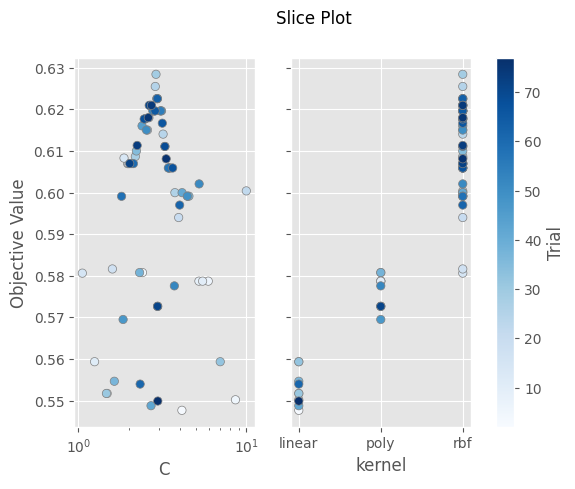

In [20]:
# study identifiers
study_name = "svm_stdscale_study_gte_cme_suicideThOnly"
storage_name = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend("./optuna_journal_storage_svm_stdscale_gte_cme_suicideThOnly.log")
)

# init classifier
clf = SVC

# tuning directory for model
if not os.path.exists(SVC_TUNING_DIR):
    os.makedirs(SVC_TUNING_DIR)

# check for a saved sampler
try:
    sampler = pickle.load(open(f"{SVC_TUNING_DIR}/{study_name}_sampler.pkl", "rb"))
except (OSError, IOError) as e:
    sampler = TPESampler(seed=SEED)

pruner = MedianPruner()
    
# create study and optimize
study = optuna.create_study(study_name=study_name, storage=storage_name,
                                sampler=sampler, pruner=pruner, direction="maximize",
                                load_if_exists=True)

study.optimize(lambda trial: TreeObjective(trial, seed=SEED, 
                                           X_train=gte_cme_train, X_val=gte_cme_val,
                                           y_train=y_train, y_val=y_val, algo=clf), 
               n_trials=200, timeout=2400)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


with open(f"{SVC_TUNING_DIR}/{study_name}_sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

# saving charts from study
try:
    save_study_charts(study=study, study_name=study_name, dir=SVC_TUNING_DIR)
except Exception as e:
    print(f"Error when trying to save charts: {e}")